# OneK1K aging signature model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy
import pertpy
import yaml

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

import process as process
import plot as plot

sys.path.append('../3_DE_analysis')
from DE_analysis_utils import *

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/

In [3]:
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

In [4]:

def parse_gene_sets(filename):
   gene_sets = {}
   with open(filename, 'r') as f:
       for line in f:
           terms = line.strip().split('\t')
           gene_sets[terms[0]] = terms[2:]
   return gene_sets

OAKPATH = '/mnt/oak/'
KEGG_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data//KEGG_2019_Human.txt')
GO_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data/GO_Biological_Process_2023.txt')

## Load perturbation effects from perturb-seq

In [5]:
datadir = f'{OAKPATH}/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_final'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 100)] = 100
for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond

adata_de.var_names = adata_de.var['gene_name'].values

# Filter very lowly expressed genes
base_mean_df = sc.get.obs_df(adata_de, adata_de.var_names.tolist() + ['culture_condition', 'chunk'], layer='baseMean')
base_mean_df = base_mean_df.drop_duplicates().sort_values('culture_condition')

# Calculate for Rest condition
base_mean_rest = base_mean_df[base_mean_df['culture_condition'] == 'Rest'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Rest'] = base_mean_rest.mean(1).fillna(0)
adata_de.var['std_baseMean_Rest'] = base_mean_rest.std(1).fillna(10000)

# Calculate for Stim8hr condition
base_mean_stim8 = base_mean_df[base_mean_df['culture_condition'] == 'Stim8hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim8hr'] = base_mean_stim8.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim8hr'] = base_mean_stim8.std(1).fillna(10000)

# Calculate for Stim48hr condition
base_mean_stim48 = base_mean_df[base_mean_df['culture_condition'] == 'Stim48hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim48hr'] = base_mean_stim48.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim48hr'] = base_mean_stim48.std(1).fillna(10000)

# Exclude from analysis genes with very low base mean (messing up reliability estimate)
gs_mask = (adata_de.var['mean_baseMean_Rest'] > 0.1) & (adata_de.var['mean_baseMean_Stim8hr'] > 0.1) & (adata_de.var['mean_baseMean_Stim48hr'] > 0.1)
adata_de = adata_de[:, gs_mask].copy()
sum(~gs_mask)

3677

In [6]:
adata_de_corr = anndata.experimental.read_lazy(datadir + f'/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad')
target_contrast_correction_dict = dict(zip(adata_de_corr.obs.to_dataframe()['target_contrast'], adata_de_corr.obs.to_dataframe()['target_contrast_corrected']))
target_contrast_name_correction_dict = dict(zip(adata_de_corr.obs.to_dataframe()['target_contrast_gene_name'], adata_de_corr.obs.to_dataframe()['target_contrast_gene_name_corrected']))

adata_de.obs['target_contrast_gene_name'] = adata_de.obs['target_contrast_gene_name'].map(target_contrast_name_correction_dict)
adata_de.obs['target_contrast'] = adata_de.obs['target_contrast'].map(target_contrast_correction_dict)

# remove missing perturb
adata_de = adata_de[~adata_de.obs['target_contrast_gene_name'].isna()].copy()

# Load summary stats
DE_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

In [7]:
DE_stats[DE_stats['target_name'] == 'UBA2']

target_contrast target_name condition  n_cells_target  n_up_genes  \
10955  ENSG00000126261        UBA2   Stim8hr            77.0         230   
17301  ENSG00000126261        UBA2  Stim48hr            55.0         127   
18702  ENSG00000126261        UBA2      Rest            80.0         344   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
10955            38               268             -6.132744   
17301            38               165             -4.406147   
18702            63               407             -6.236856   

       ontarget_significant    baseMean  offtarget_flag  \
10955                  True  132.747418           False   
17301                  True  125.946264           False   
18702                  True   71.733260           False   

      n_total_genes_category ontarget_effect_category  \
10955           >10 DE genes             on-target KD   
17301           >10 DE genes             on-target KD   
18702           >10 DE genes             on-target KD   

      target_contrast_corrected                 obs_names  \
10955           ENSG00000126261   ENSG00000126261_Stim8hr   
17301           ENSG00000126261  ENSG00000126261_Stim48hr   
18702           ENSG00000126261      ENSG00000126261_Rest   

      target_name_corrected  
10955                  UBA2  
17301                  UBA2  
18702                  UBA2

In [8]:
adata_de

AnnData object with n_obs × n_vars = 33983 × 10282
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target'
    var: 'gene_ids', 'gene_name', 'n_signif_effects_Stim8hr', 'n_signif_effects_Stim48hr', 'n_signif_effects_Rest', 'mean_baseMean_Rest', 'std_baseMean_Rest', 'mean_baseMean_Stim8hr', 'std_baseMean_Stim8hr', 'mean_baseMean_Stim48hr', 'std_baseMean_Stim48hr'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [9]:
# OAKPATH = '/oak/stanford/groups/pritch/'
figdir = 'figures/'
resultsdir = 'results/'
h5ad_file = '/mnt/oak/users/emma/data/cxg_datasets/Yazar2022.h5ad'


### Read outputs from DE analysis

Run with `1k1k_analysis.py`

In [10]:
OAKPATH='/mnt/oak/'
datadir = f'{OAKPATH}/users/emma/data/GWT/OneK1K_analysis/'

# Define cell type classes
ct_classes = ['CD4T', 'CD8T', 'NK', 'B']

# Dictionary to store results for each cell type
train_signatures = {}
val_signatures = {}

# Load results for each cell type
for ct in ct_classes:
    pbulk_adata = sc.read_h5ad(datadir + f"Yazar2022_{ct}_processed.pbulk.h5ad")
    pbulk_adata.var_names.isin(adata_de.var.index).sum()
    # Read and process training data
    train_df = pd.read_csv(f'results/DE_age_cat_{ct}_train.csv', index_col=0)
    train_df = train_df[(train_df['baseMean'] > 0)]
    train_df = train_df.rename({'log2FoldChange':'log_fc', 'padj':'adj_p_value', 'ensembl_id':'variable'}, axis=1)
    if 'variable' not in train_df.columns:
        train_df['variable'] = train_df.index.values
    train_df['gene_name'] = pbulk_adata.var.loc[train_df.variable]['feature_name'].values
    train_df['perturbseq_gene'] = train_df['variable'].isin(adata_de.var.index)
    train_df['zscore'] = train_df['log_fc']/train_df['lfcSE']
    train_df['adj_p_value'] = train_df['adj_p_value'].fillna(1)
    train_df['adj_p_value'] = train_df['adj_p_value'].fillna(1)
    train_df = train_df.set_index('gene_name')
    train_signatures[ct] = train_df

    # Read and process validation data
    val_df = pd.read_csv(f'results/DE_age_cat_{ct}_validation.csv', index_col=0)
    val_df = val_df[(val_df['baseMean'] > 0)]
    val_df = val_df.rename({'log2FoldChange':'log_fc', 'padj':'adj_p_value', 'ensembl_id':'variable'}, axis=1)
    if 'variable' not in val_df.columns:
        val_df['variable'] = val_df.index.values
    val_df['gene_name'] = pbulk_adata.var.loc[val_df.variable]['feature_name'].values
    val_df['perturbseq_gene'] = val_df['variable'].isin(adata_de.var.index)
    val_df['zscore'] = val_df['log_fc']/val_df['lfcSE']
    val_df['adj_p_value'] = val_df['adj_p_value'].fillna(1)
    val_df = val_df.set_index('gene_name')
    val_signatures[ct] = val_df

## Train model on perturbation effetcs

In [11]:
from pert2state_model.Perturb2StateModel import Perturb2StateModel

In [12]:
def mask_cis_effects(X_perturbs):
    """Mask diagonal elements (cis effects) in perturbation matrix and impute with column means."""
    X_perturbs_masked = X_perturbs.copy()
    mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
    for idx in X_perturbs_masked.index:
        if idx in X_perturbs_masked.columns:
            mask.loc[idx, idx] = True
    X_perturbs_masked = X_perturbs_masked.mask(mask)
    # Impute masked values with column means
    X_perturbs_masked = X_perturbs_masked.fillna(X_perturbs_masked.mean())
    return X_perturbs_masked

def mask_low_zscore(X_perturbs, zscore_threshold=2.0):
    """Mask values below zscore threshold in perturbation matrix and impute with column means."""
    X_perturbs_masked = X_perturbs.copy()
    mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
    mask[abs(X_perturbs_masked) < zscore_threshold] = True
    X_perturbs_masked = X_perturbs_masked.mask(mask)
    # Impute masked values with column means
    X_perturbs_masked = X_perturbs_masked.fillna(X_perturbs_masked.mean())
    return X_perturbs_masked

def _train_model(input_adata_de, signature, perturb_layer, n_pcs, n_splits, n_repeats, model_id = 'model', scramble=False, mask_low=False, scale_y = False):
    """Train perturbation-to-state model from perturbseq DE results."""
    # Get target state values
    y_target = signature[perturb_layer].copy()
    if scale_y:
        y_target = (y_target - y_target.mean()) / y_target.std()

    # Get perturbseq responses 
    X_perturbs = sc.get.obs_df(input_adata_de, 
                                ['target_contrast_gene_name', 'culture_condition'] + list(input_adata_de.var_names), 
                                layer='zscore')
    X_perturbs = X_perturbs.set_index(X_perturbs['target_contrast_gene_name'].astype(str) + '_' + X_perturbs['culture_condition'].astype(str)).drop(['target_contrast_gene_name', 'culture_condition'], axis=1).T
    print(f"Perturbation matrix shape: {X_perturbs.shape}")
    # Assert that y_target and X_perturbs have matching indices
    assert all(y_target.index == X_perturbs.index), "Target state and perturbation matrix indices do not match"
    
    # Mask effect on target gene
    X_perturbs_masked = mask_cis_effects(X_perturbs)

    if mask_low:
        X_perturbs_masked = mask_low_zscore(X_perturbs_masked, zscore_threshold=3)

    if scramble:  
        print(f"Scrambling input")
        X_perturbs_masked = X_perturbs_masked.apply(lambda row: np.random.permutation(row.values), axis=1, result_type='broadcast')
        
    # Train model on CD4 cells
    print(f"Training model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
    p2t_model = Perturb2StateModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
    p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{model_id}')
    return(p2t_model, X_perturbs_masked, y_target)

In [13]:
# def eval_splits_on_repl(model, X_perturbs, y_target, y_target_repl, state_name=None, test_size_sample = None):
#     """
#     Calculate correlations between predictions and true values for each split of a model.
    
#     Parameters
#     ----------
#     model : object
#         Model object with get_prediction() and split_ixs attributes
#     y_target : pd.Series
#         Target values used for training
#     y_target_repl : pd.Series
#         Replicate target values to compare against
#     state_name : str, optional
#         Name of the state to include in output dataframe
        
#     Returns
#     -------
#     pd.DataFrame
#         DataFrame containing correlation metrics for each split
#     """
#     # Get predictions for each split
#     splits_pred = model.get_prediction(X_perturbs, return_splits=True)
    
#     # Get test indices for each split
#     test_indices = [x[1] for x in model.split_ixs]
#     if test_size_sample is not None:
#         # Sample a subset of test indices of specified size (to make results more comparable across models)
#         test_indices = [np.random.choice(test_idx, size=test_size_sample, replace=False) for test_idx in test_indices]
    
#     # Compare predictions to true values for each test split
#     all_split_corrs = None
#     for i, test_idx in enumerate(test_indices):
#         # Get predictions for this split from the corresponding column
#         test_pred = splits_pred.iloc[test_idx, i]
#         test_true = y_target_repl.iloc[test_idx]
#         test_input = y_target.iloc[test_idx]
        
#         # Calculate correlation for this split
#         corr = np.corrcoef(test_pred, test_true)[0,1]
#         top_corr = np.corrcoef(test_input, test_true)[0,1]
        
#         # Store correlation in dataframe
#         split_corr_df = pd.DataFrame({
#             'split': i,
#             'correlation': corr,
#             'upper_correlation': top_corr,
#             'state': state_name
#         }, index=[0])
        
#         if all_split_corrs is None:
#             all_split_corrs = split_corr_df
#         else:
#             all_split_corrs = pd.concat([all_split_corrs, split_corr_df])
            
#     return all_split_corrs

### Reconstruction performance

Sample common genes for comparison

In [14]:
comparisons = [
    'CD4T_Rest',
    'CD4T_Stim8hr',
    'CD4T_Stim48hr',
    # 'CD8T_Rest',
    # 'CD8T_Stim8hr',
    # 'CD8T_Stim48hr',
    # 'NK_Rest',
    # 'NK_Stim8hr',
    # 'NK_Stim48hr',
]

comparison_data = {}

for comp in comparisons:
    s = comp.split('_')[0] 
    c = comp.split('_')[1]

    signature = train_signatures[s].copy()
    signature_replication = val_signatures[s].copy()
    
    # Define genes to test
    y_genes = signature.index.tolist()
    y_repl_genes = signature_replication.index.tolist()
    x_genes = adata_de.var_names.tolist()
    common_gs = np.intersect1d(np.intersect1d(y_genes, y_repl_genes), x_genes)

    # Define regulators to test
    keep_targets = DE_stats[(DE_stats.n_total_de_genes >= 10)].target_name.unique().tolist()
    a = adata_de[(adata_de.obs['culture_condition'] == c) & (adata_de.obs['target_contrast_gene_name'].isin(keep_targets))][:, common_gs].copy()
    
    comp_data = (signature.loc[common_gs], a)
    comparison_data[comp] = comp_data

In [15]:
%%time
comparison_results = {}
for comp_key in comparison_data.keys():
    signature, input_adata_de = comparison_data[comp_key]
    p2t_model, X_perturbs, y_target = _train_model(
        input_adata_de = input_adata_de,
        signature = signature,
        perturb_layer = 'zscore',
        n_pcs = 60,
        n_splits = 5,
        n_repeats = 1,
        scale_y = True
    )
    comparison_results[comp_key] = p2t_model, X_perturbs, y_target


Perturbation matrix shape: (6014, 3745)
Training model with 60 PCs, 5 splits, 1 repeats
Perturbation matrix shape: (6014, 3830)
Training model with 60 PCs, 5 splits, 1 repeats
Perturbation matrix shape: (6014, 3730)
Training model with 60 PCs, 5 splits, 1 repeats
CPU times: user 48min 47s, sys: 12min 30s, total: 1h 1min 17s
Wall time: 1min 14s


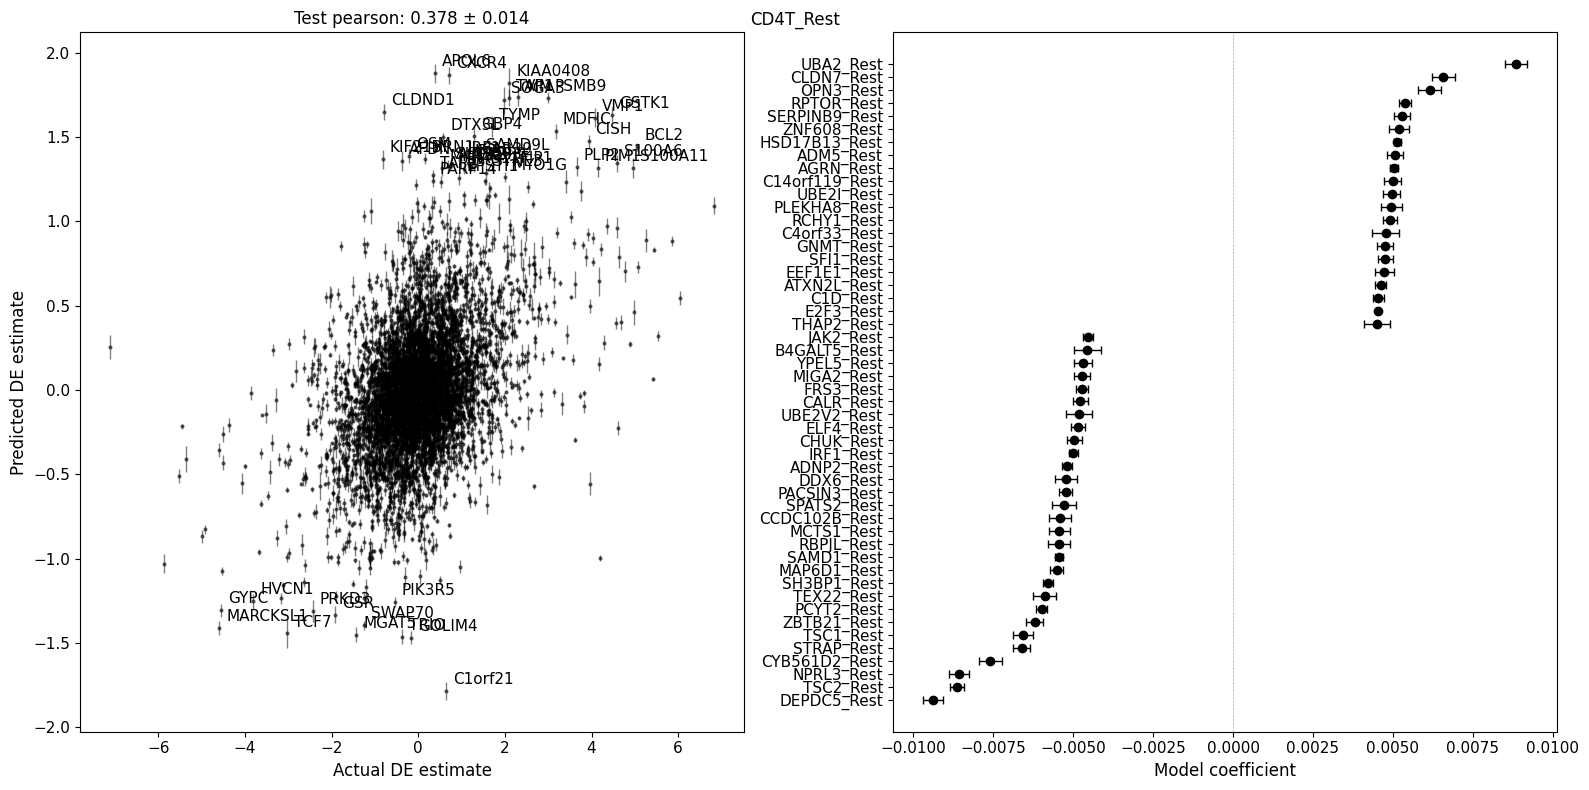

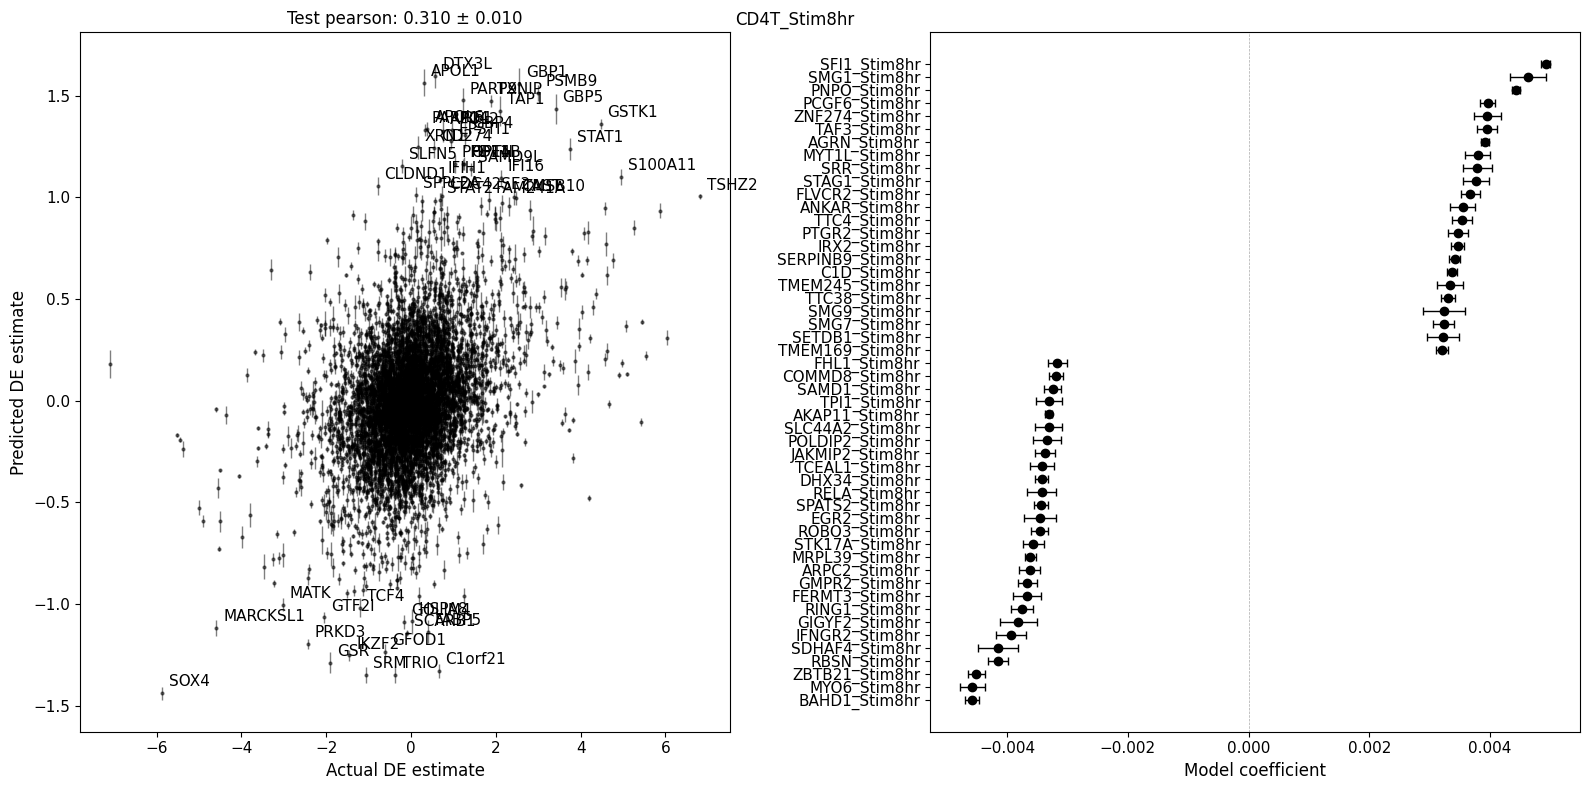

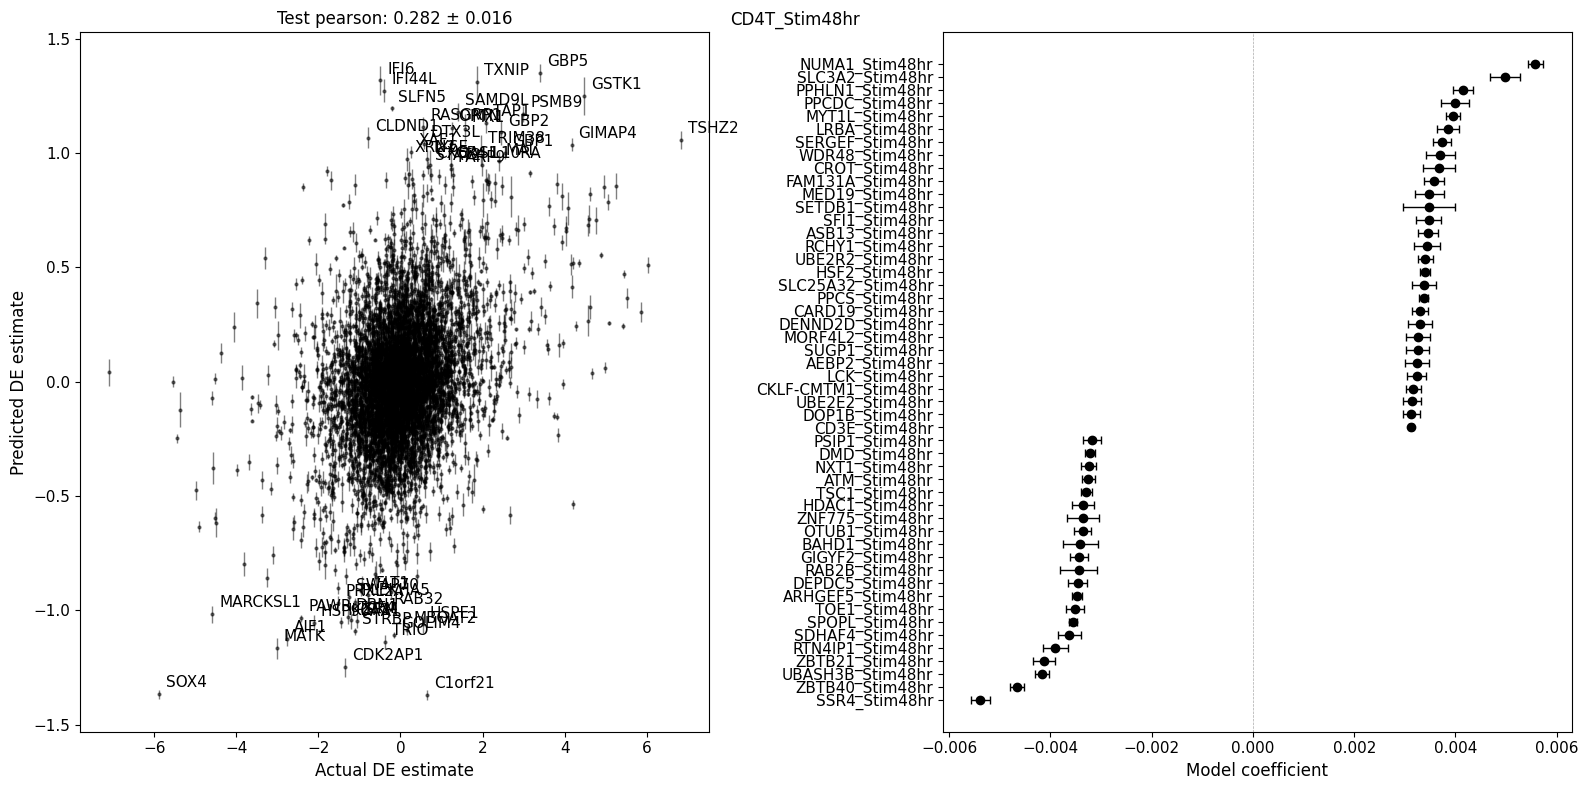

In [16]:
for dataset_key in comparison_results.keys():
    p2t_model, X_perturbs, y_target = comparison_results[dataset_key]
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    p2t_model.plot_prediction(X_perturbs, y_target, plot_metric='pearson', ax=axes[0], annotate_top_n=50)
    p2t_model.plot_coefs(top_n=50, ax=axes[1])
    fig.tight_layout()
    fig.suptitle(dataset_key)
    fig.show()

In [17]:
# Get effect of aging in replication dataset
all_split_corrs = pd.DataFrame()
for dataset_key in comparison_results.keys():
    s = dataset_key.split("_")[0]
    y_target_replication = val_signatures[s]['zscore'].copy()
    p2t_model, X_perturbs, y_target = comparison_results[dataset_key]
    # Get predictions for each train-test split
    splits_pred = p2t_model.get_prediction(X_perturbs, return_splits=True)
    test_indices = [x[1] for x in p2t_model.split_ixs]
    
    # Compare predictions to true values for each test split
    for i, test_idx in enumerate(test_indices):
        # Get predictions for this split from the corresponding column
        test_pred = splits_pred.iloc[test_idx, i]
        test_input = y_target.iloc[test_idx]
        test_true = y_target_replication.loc[test_input.index]
        
        # Calculate correlations for this split
        corr = np.corrcoef(test_pred, test_true)[0,1]
        top_corr = np.corrcoef(test_input, test_true)[0,1]
        pred_input_corr = np.corrcoef(test_pred, test_input)[0,1]
        
        # Store correlation in dataframe
        split_corr_df = pd.DataFrame({
            'split': i,
            'correlation': corr,
            'upper_correlation': top_corr,
            'pred_input_correlation': pred_input_corr,
            'dataset_key': dataset_key
        }, index=[0])
        
        all_split_corrs = pd.concat([all_split_corrs, split_corr_df])
            

In [18]:
all_split_corrs.head()

split  correlation  upper_correlation  pred_input_correlation dataset_key
0      0     0.252414           0.495204                0.402625   CD4T_Rest
0      1     0.263708           0.488522                0.410844   CD4T_Rest
0      2     0.247787           0.486055                0.374681   CD4T_Rest
0      3     0.209607           0.486388                0.376448   CD4T_Rest
0      4     0.214942           0.566142                0.325226   CD4T_Rest

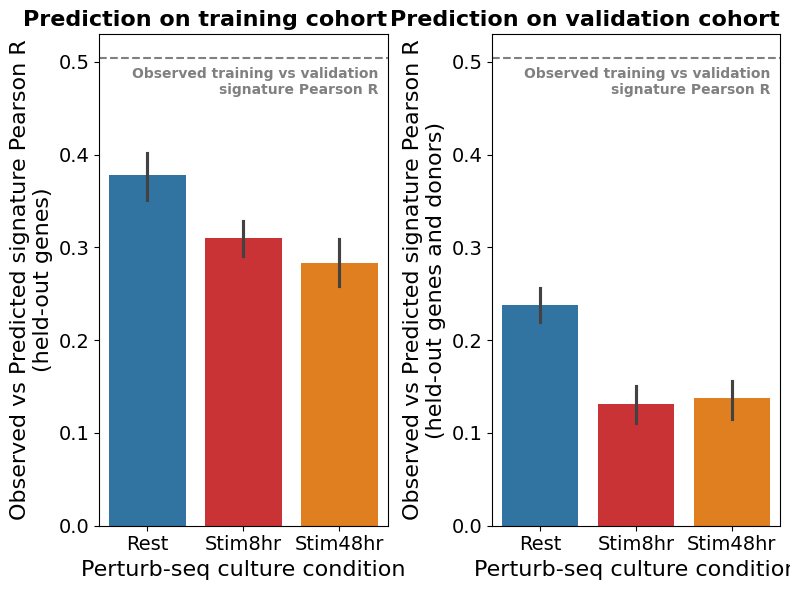

In [19]:
results_df = all_split_corrs.copy()
results_df['state'] = results_df['dataset_key'].str.split('_').str[1]
results_df['cell_type_class'] = results_df['dataset_key'].str.split('_').str[0]
results_df = results_df[results_df['cell_type_class'] == 'CD4T']
results_df['correlation_delta'] = results_df['correlation'] / results_df['upper_correlation']

fig, axs = plt.subplots(1,2, figsize=(8,6))

sns.barplot(data=results_df.fillna(0), y='pred_input_correlation', x='state', hue='state',
            ax=axs[0], palette=palettes['culture_condition'],
            hue_order=['Rest', 'Stim8hr', 'Stim48hr'])
axs[0].set_xlabel('Perturb-seq culture condition', fontsize=16)
axs[0].set_ylabel('Observed vs Predicted signature Pearson R\n(held-out genes)', fontsize=16) 
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_title('Prediction on training cohort', weight='bold', fontsize=16, loc='right')

sns.barplot(data=results_df.fillna(0), y='correlation', x='state', hue='state',
            ax=axs[1], palette=palettes['culture_condition'],
            hue_order=['Rest', 'Stim8hr', 'Stim48hr'])
axs[1].set_xlabel('Perturb-seq culture condition', fontsize=16)
axs[1].set_ylabel('Observed vs Predicted signature Pearson R\n(held-out genes and donors)', fontsize=16) 
axs[1].tick_params(axis='both', labelsize=14)
# Add horizontal line for mean upper correlation bound
axs[1].axhline(y=results_df['upper_correlation'].mean(), color='gray', linestyle='--')
axs[1].text(axs[1].get_xlim()[1]-0.1, results_df['upper_correlation'].mean()-0.01, 
        'Observed training vs validation\nsignature Pearson R', 
        color='gray',
        horizontalalignment='right', verticalalignment='top',
        weight='bold')
# Add horizontal line for mean upper correlation bound
axs[0].axhline(y=results_df['upper_correlation'].mean(), color='gray', linestyle='--')
axs[0].text(axs[1].get_xlim()[1]-0.1, results_df['upper_correlation'].mean()-0.01, 
        'Observed training vs validation\nsignature Pearson R', 
        color='gray',
        horizontalalignment='right', verticalalignment='top',
        weight='bold')
axs[1].set_title('Prediction on validation cohort', weight='bold', fontsize=16, loc='right')

# Adjust legend
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, frameon=False, title='Culture condition', title_fontsize=16)
plt.tight_layout()
plt.savefig('./results/agingCD4T_prediction_conditions.barplot.png');
plt.savefig('./results/agingCD4T_prediction_conditions.barplot.pdf');


In [20]:
# results_df = all_split_corrs.copy()
# results_df['state'] = results_df['dataset_key'].str.split('_').str[1]
# results_df['cell_type_class'] = results_df['dataset_key'].str.split('_').str[0]
# results_df['correlation_delta'] = results_df['correlation'] / results_df['upper_correlation']

# fig, ax = plt.subplots(figsize=(10,6))

# # Create barplot
# sns.barplot(data=results_df.fillna(0), y='correlation', x='cell_type_class', hue='state',
#             ax=ax, palette=palettes['culture_condition'],
#             hue_order=['Rest', 'Stim8hr', 'Stim48hr'])


# # Add dotted lines for upper correlation values
# for cell_type in results_df.cell_type_class.unique():
#     cell_type_data = results_df[results_df.cell_type_class == cell_type]
#     for i, state in enumerate(['Rest', 'Stim8hr', 'Stim48hr']):
#         state_data = cell_type_data[cell_type_data.state == state]
#         if not state_data.empty:
#             x_pos = ax.get_xticks()[list(results_df.cell_type_class.unique()).index(cell_type)]
#             # Adjust x position based on hue position
#             width = 0.8 / 3  # Approximate width of each hue bar
#             x_adj = x_pos - width + (i * width)
#             upper_corr = state_data.upper_correlation.mean()
#             ax.hlines(y=upper_corr, xmin=x_adj-width/2, xmax=x_adj+width/2, 
#                      colors='black', linestyles='dotted', linewidth=2)

# # Customize fonts and labels
# plt.xlabel('OneK1K Cell Type', fontsize=16)
# plt.ylabel('True vs predicted aging signature correlation\n(held-out genes and donors)', fontsize=16) 
# ax.tick_params(axis='both', labelsize=14)

# # Adjust legend
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, frameon=False, title='Culture condition', title_fontsize=16)
# plt.tight_layout()


In [21]:
dataset_key = 'CD4T_Rest'
model, X, y_train = comparison_results[dataset_key]
s = dataset_key.split('_')[0] 
c = dataset_key.split('_')[1]
signature = train_signatures[s].copy()
signature_replication = val_signatures[s].copy()

split_id = 1
annotate_top_n = 0
plot_metric = 'pearson'

# Plot single split with train/test colored differently
train_ixs, test_ixs = model.split_ixs[split_id]
split_predictions = model.get_prediction(X, return_splits=True).iloc[:, split_id].reset_index()

# Add train/test annotation column
split_predictions['set_type'] = 'test'
split_predictions.loc[train_ixs, 'set_type'] = 'train'
split_predictions = split_predictions.set_index('index')

# Plot only genes measured in replication dataset
y = signature_replication['zscore'].copy()
common_indices = split_predictions.index.intersection(y.index)
y = y.loc[common_indices]
y_train = y_train.loc[common_indices]
split_predictions = split_predictions.loc[common_indices]

In [22]:

# fig, ax = plt.subplots(figsize=(8, 6))

# train_mask = split_predictions['set_type'] == 'train'
# test_mask = split_predictions['set_type'] == 'test'

# if plot_metric is not None:    
#     metric_val, pval = scipy.stats.pearsonr(y[test_mask],split_predictions.loc[test_mask, 0])
#     test_genes_label = f"Held-out signature genes\n(Pearson R = {metric_val:.4f})"

#     metric_val, pval = scipy.stats.pearsonr(y[train_mask],split_predictions.loc[train_mask, 0])
#     train_genes_label = f"Training signature genes\n(Pearson R = {metric_val:.4f})"

# # Plot training points
# ax.scatter(
#     y,
#     y_train,
#     s=5,
#     alpha=0.5,
#     color="black", 
#     label=train_genes_label,
#     rasterized=True
# )

# ax.tick_params(axis="both", labelsize=11)

# ax.axhline(y=0, color='darkgrey', linestyle='--')
# ax.axvline(x=0, color='darkgrey', linestyle='--')

# # if annotate_top_n > 0:
# #     # Get indices of top and bottom n values
# #     sorted_idx = y.abs().sort_values(ascending=False).index
# #     top_idx = sorted_idx[:annotate_top_n]

# #     # Add annotations
# #     for idx in top_idx:
# #         ax.annotate(idx, (y[idx], split_predictions.loc[idx, 0]), xytext=(2, 2), textcoords="offset points", weight='bold', fontsize=14, color='white')
# #         ax.annotate(idx, (y[idx], split_predictions.loc[idx, 0]), xytext=(2, 2), textcoords="offset points", fontsize=12)


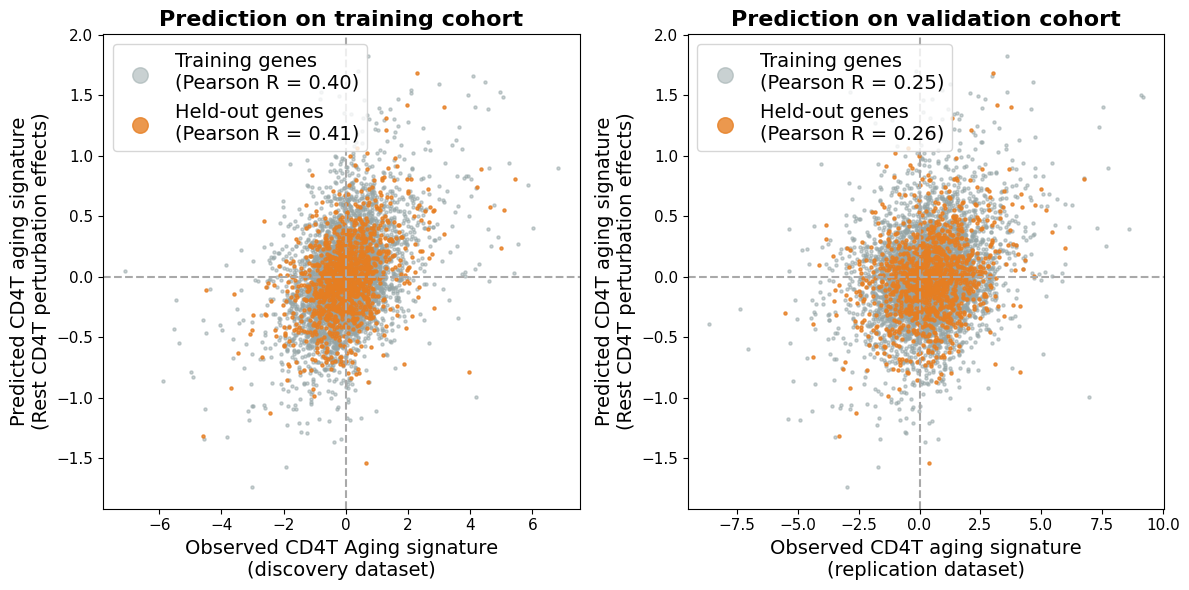

In [23]:
ylabel_str = 'Predicted CD4T aging signature\n(Rest CD4T perturbation effects)'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

train_mask = split_predictions['set_type'] == 'train'
test_mask = split_predictions['set_type'] == 'test'

if plot_metric is not None:    
    # Compute metrics for y_train correlations
    metric_val_train_test, _ = scipy.stats.pearsonr(y_train[test_mask], split_predictions.loc[test_mask, 0])
    test_genes_label_1 = f"Held-out genes\n(Pearson R = {metric_val_train_test:.2f})"

    metric_val_train_train, _ = scipy.stats.pearsonr(y_train[train_mask], split_predictions.loc[train_mask, 0])
    train_genes_label_1 = f"Training genes\n(Pearson R = {metric_val_train_train:.2f})"

    # Compute metrics for y correlations
    metric_val_y_test, _ = scipy.stats.pearsonr(y[test_mask], split_predictions.loc[test_mask, 0])
    test_genes_label_2 = f"Held-out genes\n(Pearson R = {metric_val_y_test:.2f})"

    metric_val_y_train, _ = scipy.stats.pearsonr(y[train_mask], split_predictions.loc[train_mask, 0])
    train_genes_label_2 = f"Training genes\n(Pearson R = {metric_val_y_train:.2f})"

# First subplot - compare with training values
ax1.scatter(
    y_train[train_mask],
    split_predictions.loc[train_mask, 0],
    s=5,
    alpha=0.5,
    color=palettes['train_test']['train'],
    label=train_genes_label_1,
    rasterized=True
)

ax1.scatter(
    y_train[test_mask],
    split_predictions.loc[test_mask, 0], 
    s=5,
    alpha=0.8,
    color=palettes['train_test']['test'],
    label=test_genes_label_1,
    rasterized=True
)

ax1.set_ylabel(ylabel_str, fontsize=14)
ax1.set_xlabel('Observed CD4T Aging signature\n(discovery dataset)', fontsize=14)
ax1.tick_params(axis="both", labelsize=11)
ax1.axhline(y=0, color='darkgrey', linestyle='--')
ax1.axvline(x=0, color='darkgrey', linestyle='--')
ax1.legend(fontsize=14, loc='upper left', markerscale=5)

# Second subplot - compare with replication values
ax2.scatter(
    y[train_mask],
    split_predictions.loc[train_mask, 0],
    s=5, 
    alpha=0.5,
    color=palettes['train_test']['train'],
    label=train_genes_label_2
)

ax2.scatter(
    y[test_mask],
    split_predictions.loc[test_mask, 0],
    s=5,
    alpha=0.8, 
    color=palettes['train_test']['test'],
    label=test_genes_label_2
)

ax2.set_ylabel(ylabel_str, fontsize=14)
ax2.set_xlabel('Observed CD4T aging signature\n(replication dataset)', fontsize=14)
ax2.tick_params(axis="both", labelsize=11)
ax2.axhline(y=0, color='darkgrey', linestyle='--')
ax2.axvline(x=0, color='darkgrey', linestyle='--')
ax2.legend(fontsize=14, loc='upper left', markerscale=5)

if annotate_top_n > 0:
    # Get indices of top and bottom n values
    sorted_idx = y.abs().sort_values(ascending=False).index
    top_idx = sorted_idx[:annotate_top_n]

    # Add annotations to both plots
    for idx in top_idx:
        ax1.annotate(idx, (y_train[idx], split_predictions.loc[idx, 0]), xytext=(2, 2), textcoords="offset points", weight='bold', fontsize=16, color='white')
        ax1.annotate(idx, (y_train[idx], split_predictions.loc[idx, 0]), xytext=(2, 2), textcoords="offset points", fontsize=14)
        
        ax2.annotate(idx, (y[idx], split_predictions.loc[idx, 0]), xytext=(2, 2), textcoords="offset points", weight='bold', fontsize=16, color='white')
        ax2.annotate(idx, (y[idx], split_predictions.loc[idx, 0]), xytext=(2, 2), textcoords="offset points", fontsize=14)

ax1.set_title('Prediction on training cohort', weight='bold', fontsize=16)
ax2.set_title('Prediction on validation cohort', weight='bold', fontsize=16)

plt.tight_layout()
plt.savefig('./results/agingCD4T_prediction_best_model.scatter.png');
plt.savefig('./results/agingCD4T_prediction_best_model.scatter.pdf');


In [24]:
regulator_type = {
    'TSC1':'mTORC1 pathway',
    'TSC2':'mTORC1 pathway',
    'DEPDC5':'mTORC1 pathway',
    'NPRL3':'mTORC1 pathway',
    'RPTOR':'mTORC1 pathway'
}

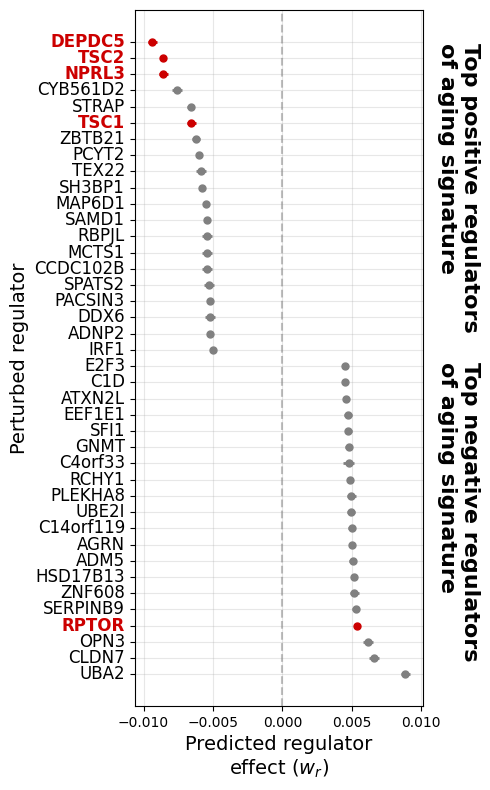

In [25]:
dataset_key = 'CD4T_Rest'
legend_on = False
model, X, y_train = comparison_results[dataset_key]
mod_coefs = model.get_coefs()
        
# Get ranks of coefficients and normalize to 0-1
coef_mean = mod_coefs['coef_mean']
coef_ranks = coef_mean.rank(ascending=False)
n_coefs = len(coef_ranks)
normalized_ranks = (coef_ranks - 1) / (n_coefs - 1)  # Normalize to 0-1 range
mod_coefs['coef_rank'] = normalized_ranks

mod_coefs['regulator'] = mod_coefs.index.str.split('_').str[0]
mod_coefs['known_regulators'] = mod_coefs['regulator'].isin(regulator_type.keys())
mod_coefs['dataset_key'] = dataset_key

# Add regulator type column
mod_coefs['regulator_type'] = mod_coefs['regulator'].map(regulator_type)
mod_coefs['regulator_type'] = mod_coefs['regulator_type'].fillna('Unknown')

# Sort by coefficient mean and get top/bottom 50
top_50 = mod_coefs.nlargest(20, 'coef_mean')
bottom_50 = mod_coefs.nsmallest(20, 'coef_mean')
plot_df = pd.concat([top_50, bottom_50]).sort_values('coef_mean', ascending=False)

# Create x-axis indices
y_indices = np.arange(len(plot_df))

# Create the plot
plt.figure(figsize=(5, 8))

# Plot points for each regulator type in specific order
regulator_palette = {
    'mTORC1 pathway':'#CC0000',
    'Unknown': 'grey'
}

for reg_type in regulator_palette.keys():
    mask = plot_df['regulator_type'] == reg_type
    plt.errorbar(x=plot_df[mask]['coef_mean'],
                y=y_indices[mask.values],
                xerr=plot_df[mask]['coef_sem'],
                fmt='o',
                capsize=0,
                label=reg_type,
                color=regulator_palette[reg_type],
                markersize=5,
                linewidth=2)

plt.yticks(y_indices, plot_df['regulator'], rotation=0, ha='right', va='center', fontsize=12)
# Color y-axis labels based on regulator type
ax = plt.gca()
for tick, regulator in zip(ax.get_yticklabels(), plot_df['regulator']):
    reg_type = plot_df[plot_df['regulator'] == regulator]['regulator_type'].iloc[0]
    if reg_type == 'Unknown':
        tick.set_color('black')
    else:
        tick.set_color(regulator_palette[reg_type])
        tick.set_fontweight('bold')

plt.xlabel('Predicted regulator\neffect ($w_r$)', fontsize=14)
plt.ylabel('Perturbed regulator', fontsize=14)
if legend_on:
    legend = plt.legend(['mTORC1 pathway'], loc='upper right', title='', fontsize=16, frameon=True)
    legend.get_title().set_fontweight('bold')
else:
    plt.legend([], frameon=False)

plt.grid(True, alpha=0.3)

# Add vertical line at x=0
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Calculate midpoint between top and bottom regulators
mid_point = len(plot_df) // 2
plt.annotate('Top negative regulators\nof aging signature', xy=(plt.xlim()[1], mid_point/2), 
            xytext=(10, 0), textcoords='offset points', rotation=270,
            ha='left', va='center', weight='bold', fontsize=16)
plt.annotate('Top positive regulators\nof aging signature', xy=(plt.xlim()[1], mid_point + mid_point/2),
            xytext=(10, 0), textcoords='offset points', rotation=270,
            ha='left', va='center', weight='bold', fontsize=16)

plt.tight_layout()
plt.savefig('./results/aging_regulators_coefs.png');
plt.savefig('./results/aging_regulators_coefs.pdf');

plt.show()

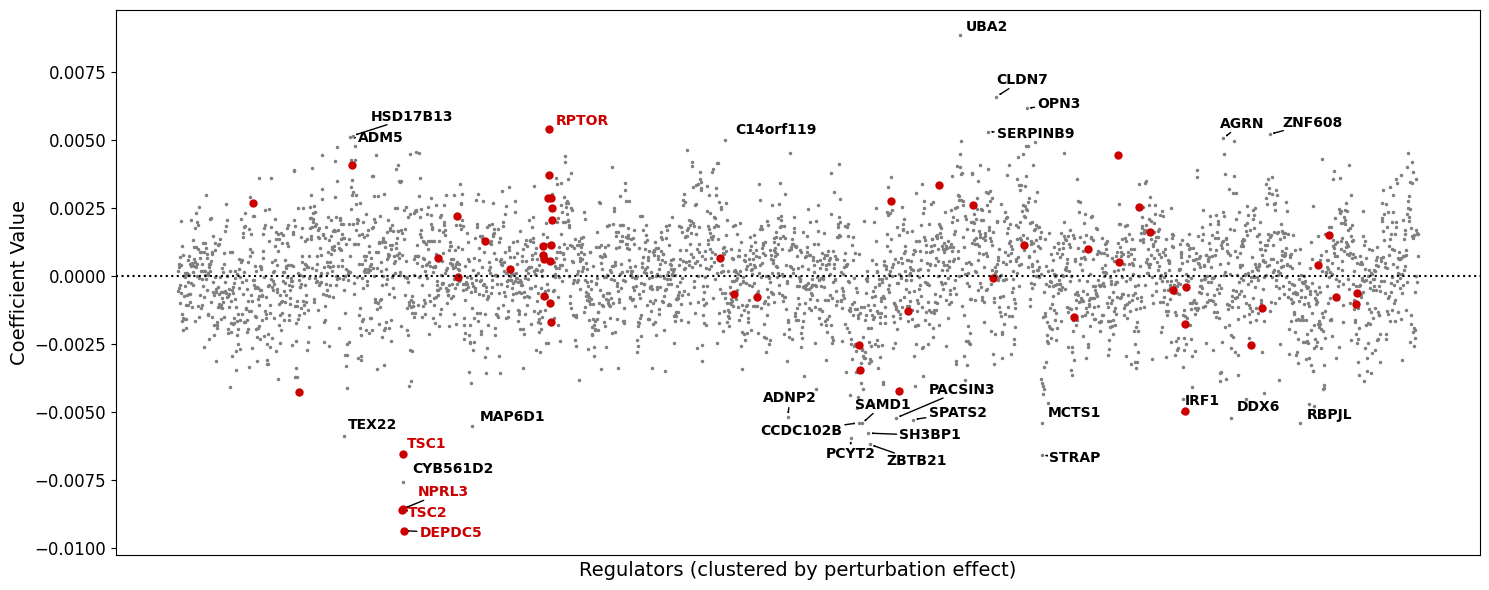

In [26]:
mtor_targets = DE_stats[DE_stats['target_name'].isin(KEGG_sets['mTOR signaling pathway']) & (DE_stats.n_total_de_genes > 3)].target_name.unique()

pca_df = pd.DataFrame(model.pcas[0].components_, columns=model.get_coefs().index.tolist())
pca_df = pca_df.T  # Transpose to cluster genes
pca_df_clustered = pca_df.iloc[scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(pca_df, method='ward'))]
ordered_regs = pca_df_clustered.index.tolist()
coef_mean_pl = coef_mean.loc[ordered_regs]
coef_mean_pl.index = coef_mean_pl.index.str.split("_").str[0]
# Add rank to x-axis
coef_mean_pl = coef_mean_pl.reset_index()
coef_mean_pl['rank'] = range(len(coef_mean_pl))
coef_mean_pl = coef_mean_pl.set_index('index')

mtor_targets_pl = np.intersect1d(mtor_targets, coef_mean_pl.index)

# Get top 20 genes by absolute coefficient value
top_20_genes = coef_mean_pl['coef_mean'].abs().nlargest(30)

plt.figure(figsize=(15, 6))
plt.plot(coef_mean_pl['rank'], coef_mean_pl.coef_mean, '.', color='grey', markersize=3, rasterized=True)
plt.plot(coef_mean_pl.loc[mtor_targets_pl]['rank'], coef_mean_pl.loc[mtor_targets_pl].coef_mean, '.', color='#CC0000', markersize=10, rasterized=True)

# Add dotted line at coefficient = 0
plt.axhline(y=0, color='black', linestyle=':', alpha=1)

# Annotate top 20 genes using adjusttext
from adjustText import adjust_text

texts = []
for gene, value in top_20_genes.items():
    idx = ordered_regs.index(gene + '_Rest')
    if gene in mtor_targets_pl:
        texts.append(plt.text(idx, coef_mean.loc[ordered_regs].values[idx], gene, color='#CC0000',
                    fontweight='bold', fontsize=10))
    else:
        texts.append(plt.text(idx, coef_mean.loc[ordered_regs].values[idx], gene, 
                    fontweight='bold', fontsize=10))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

# plt.title('Coefficient Values with Top 20 Genes Annotated')
plt.xlabel('Regulators (clustered by perturbation effect)', fontsize=14)
plt.ylabel('Coefficient Value', fontsize=14)
plt.xticks([], fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('./results/aging_regulators_coefs_full.png');
plt.savefig('./results/aging_regulators_coefs_full.pdf');

Compare baseline expression

In [27]:
# Comparison of baseline mean expression
pseq_base_means = get_DE_results_long(adata_de, targets=['GATA3'], effect_estimates='baseMean', gene_id_col='gene_ids')
pseq_base_means = pseq_base_means.pivot(columns='culture_condition', index='gene_ids', values='baseMean').dropna()
onek1k_base_means = pd.concat([x[['variable', 'baseMean']].set_index('variable').rename({'baseMean':k}, axis=1) for k,x in train_results.items()], axis=1)
all_base_means = pd.concat([pseq_base_means, onek1k_base_means], axis=1).dropna()
from scipy.spatial.distance import pdist, squareform
base_means_dist = pd.DataFrame(squareform(pdist(all_base_means.T)), 
                             index=all_base_means.columns,
                             columns=all_base_means.columns)
pseq_cols = pseq_base_means.columns
onek1k_cols = onek1k_base_means.columns

# Calculate cosine distances between conditions
from scipy.spatial.distance import cosine
dist_long = pd.DataFrame([
    {'onek1k_condition': col1,
     'pseq_condition': col2, 
     'distance': cosine(all_base_means[col1], all_base_means[col2])}
    for col1 in onek1k_cols
    for col2 in pseq_cols
])

# Create heatmap
plt.figure(figsize=(4,3))
sns.heatmap(data=dist_long.pivot(index='onek1k_condition', columns='pseq_condition', values='distance'),
            cmap='RdBu_r', annot=True, fmt='.2f',
            cbar_kws={'label': 'Cosine Distance'})
plt.xticks(rotation=45, ha='right');
plt.yticks(rotation=0);
plt.xlabel('Perturb-seq condition');
plt.ylabel('OneK1K cell type');
plt.title('Baseline expression distance');
plt.tight_layout()

NameError: name 'train_results' is not defined

In [314]:
# # Get top 20 components and plot as heatmap
# components = p2t_model.pcas[0].components_[:20]
# plt.figure(figsize=(12, 8))
# sns.clustermap(components, cmap='RdBu_r', center=0)
# plt.xlabel('Genes')
# plt.ylabel('PC')
# plt.title('Top 20 Principal Components')

## Train best model

In [120]:
# from pert2state_model.Perturb2StateModel import Perturb2StateModel
# perturb_layer = 'zscore'
# target_state = 'age'
# signif_zscore = 0
# n_pcs=50
# n_splits=5
# n_repeats=3

# ct = 'CD4T'
# cond = 'Rest'

# train_df = train_signatures[ct]
# train_df['contrast'] = target_state

# # Get target state values
# y_target = train_df.pivot_table(index='gene_name', columns='contrast', values=perturb_layer)[target_state]
# y_target = y_target - y_target.mean()
# y_target.hist()
# y_target = y_target[train_df.pivot_table(index='gene_name', columns='contrast', values='adj_p_value')[target_state] < 0.05]
# # Center y_target at 0 by subtracting its mean


# # common_genes = np.intersect1d(y_target.index, y_target_val.index)
# # y_target = y_target.loc[common_genes]

# # Find common genes between all DE results
# common_gs = np.intersect1d(y_target.index, adata_de.var_names)
# print(f"Common genes between target and adata_de: {len(common_gs)}")
# y_target = y_target.loc[common_gs]

# print(f"\nTraining models for condition: {cond}")

# # Get responses for this condition
# X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
#                         ['target_contrast_gene_name'] + list(common_gs), 
#                         layer=perturb_layer)
# X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
# print(f"Perturbation matrix shape: {X_perturbs.shape}")

# # Mask effects in cis and based on zscore thresh
# X_perturbs_masked = X_perturbs.copy()
# mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
# # Mask cis effects
# for idx in X_perturbs_masked.index:
#     if idx in X_perturbs_masked.columns:
#         mask.loc[idx, idx] = True
# # Mask non-significant effects
# # mask = mask | (np.abs(X_perturbs) < signif_zscore)
# X_perturbs_masked = X_perturbs_masked.mask(mask)
# # Impute masked values with column means
# X_perturbs_masked = X_perturbs_masked.fillna(0)

# # Train main model
# print(f"Training model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
# p2t_model = Perturb2StateModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
# p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{ct}_{cond}', stratify_y=False)

# p2t_model.plot_prediction(X_perturbs_masked, y_target, plot_metric='pearson')
# print(f"Model training for {target_state} completed successfully")

p2t_model, X, y_train = comparison_results[dataset_key]

<Axes: xlabel='Model coefficient'>

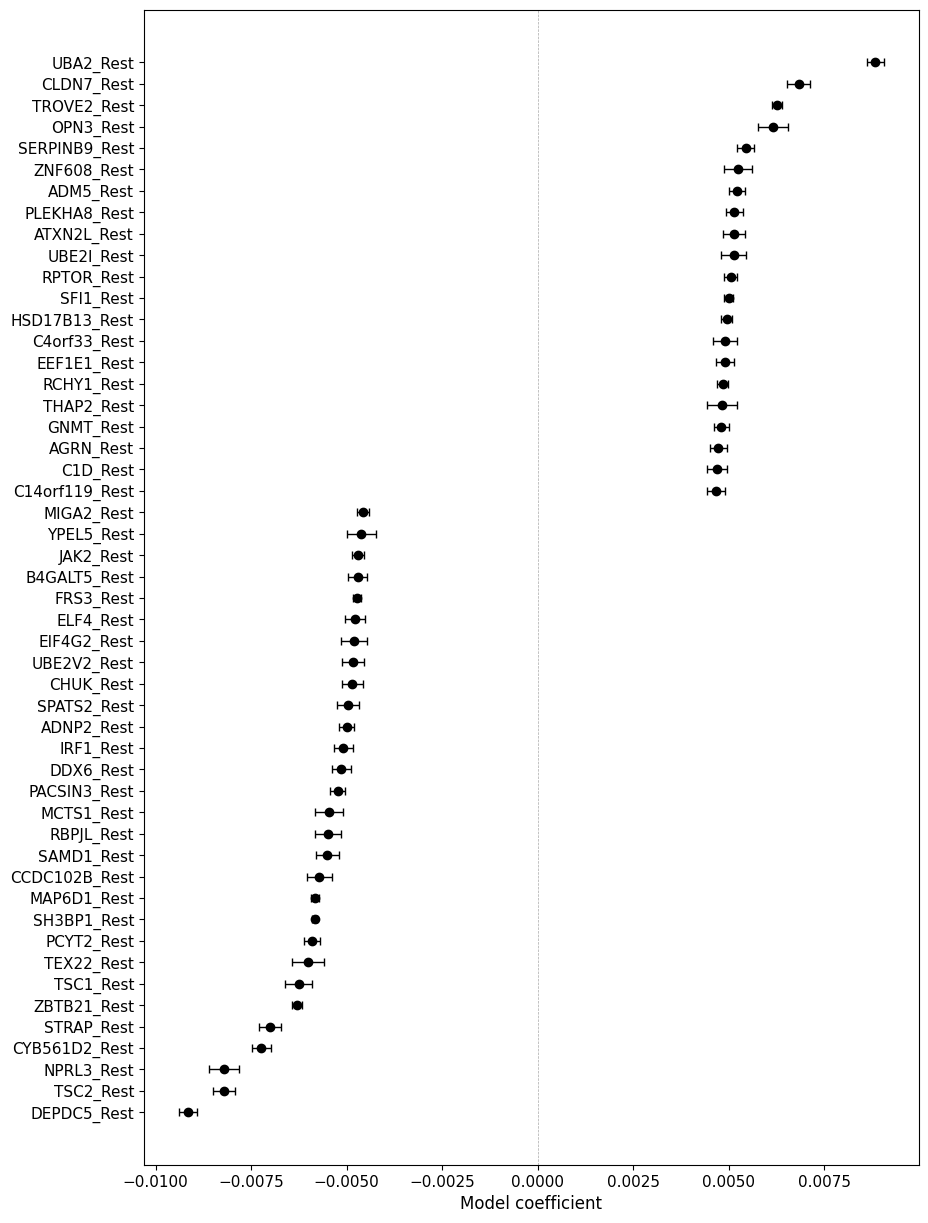

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
p2t_model.plot_coefs(top_n=50,ax=ax, return_ax=True, show_labels=True)

In [68]:
# fig, ax = plt.subplots(figsize=(10,10))
# p2t_model.plot_prediction(X_perturbs_masked, y_target, plot_metric='pearson', annotate_top_n=50, ax=ax)
# plt.show()

cluster top regulators by effect on signature genes

In [122]:
def plot_regulator_effects(adata_de, genes, regulators, y_target, sort_by='perturbation', figsize=(18, 6), condition='Rest'):
    """Plot effects of regulators on target genes.
    
    Args:
        top_rows: List of target genes to plot
        gr: List of regulators to analyze
        wide_de_results: DataFrame with DE results
        wide_de_results_signif: DataFrame with significance values
        y_target: Series with aging effects
    """

    # Get DE results and pivot to wide format
    long_de_results = get_DE_results_long(adata_de, targets=regulators, genes=genes, gene_id_col='gene_name')
    long_de_results = long_de_results[long_de_results['culture_condition'] == condition].copy()
    wide_de_results = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='zscore').T
    wide_de_results_signif = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='adj_p_value').T

    pl_df = wide_de_results.loc[regulators, genes].reset_index().melt(id_vars='target_contrast_gene_name')
    signif = wide_de_results_signif.loc[regulators, genes] < 0.1
    # Calculate mean values per gene
    gene_means = pl_df.groupby('gene')['value'].mean()
    # Sort either by aging effect (y_target) or mean perturbation effect
    if sort_by == 'aging':
        gene_order = y_target.loc[genes].sort_values().index
    elif sort_by == 'perturbation':
        gene_order = wide_de_results.loc[regulators, genes].mean().sort_values().index
    else:
        gene_order = genes # Keep original order
    pl_df['aging_effect'] = y_target.loc[pl_df['gene']].values
    pl_df['target_contrast_gene_name'] = pl_df['target_contrast_gene_name'].astype(str)
    pl_df['significant'] = False
    for gene in regulators:
        for target in genes:
            pl_df.loc[(pl_df['target_contrast_gene_name'] == gene) & (pl_df['gene'] == target), 'significant'] = signif.loc[gene, target]

    plt.figure(figsize=figsize)
    plt.axvline(x=0, color='grey', linestyle=':', zorder=0)

    palette = {name: sns.color_palette('Pastel1')[i] 
              for i, name in enumerate(pl_df['target_contrast_gene_name'].unique())}

    # Create base stripplot with legend using ordered regulators
    ax = sns.stripplot(data=pl_df[~pl_df.significant], y='gene', x='value', 
                      hue='target_contrast_gene_name', dodge=False, palette=palette, legend=False,
                      order=gene_order, size=8, alpha=0.5)

    # Add points with black outline for significant values, no legend
    ax = sns.stripplot(data=pl_df[pl_df.significant], y='gene', x='value', 
                      hue='target_contrast_gene_name', dodge=False, 
                      edgecolor='black', linewidth=1, palette=palette, legend=True,
                      order=gene_order, size=8, alpha=0.7)

    # Add scatter points for aging effect
    sns.scatterplot(data=pl_df, y='gene', x='aging_effect', 
                    s=200, color='black', marker='*', label='Aging signature effect')

    # Adjust y-axis labels
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Add axis labels
    plt.ylabel('Signature genes', fontsize=14)
    plt.xlabel('Perturb-seq effect size\n(DE z-score)', fontsize=14)

    # Add white point with black outline to legend to indicate significance
    plt.scatter([], [], c='white', edgecolor='black', linewidth=1, s=80, label='Significant effect (10% FDR)')

    # Move legend outside with larger font
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Target gene', fontsize=12, title_fontsize=14, frameon=False)
    plt.tight_layout()

In [123]:
mtor_genes_up = KEGG_sets['mTOR signaling pathway'] + reactome_gene_sets['REACTOME_MTOR_SIGNALLING'] + reactome_gene_sets['REACTOME_AMINO_ACIDS_REGULATE_MTORC1'] + reactome_gene_sets['REACTOME_MTORC1_MEDIATED_SIGNALLING']
plot_regulator_effects(adata_de, np.intersect1d(mtor_genes_up, y_target.index), gr, y_target, figsize=(10,4))
plt.xlabel('CD4T aging signature genes (mTOR signalling pathway)')


NameError: name 'reactome_gene_sets' is not defined

In [124]:
mtor_signif_aging = signature[signature['gene_name'].isin(KEGG_sets['mTOR signaling pathway']) & (signature['adj_p_value'] < 0.01)]['gene_name'].values
mtor_signif_aging

KeyError: 'gene_name'

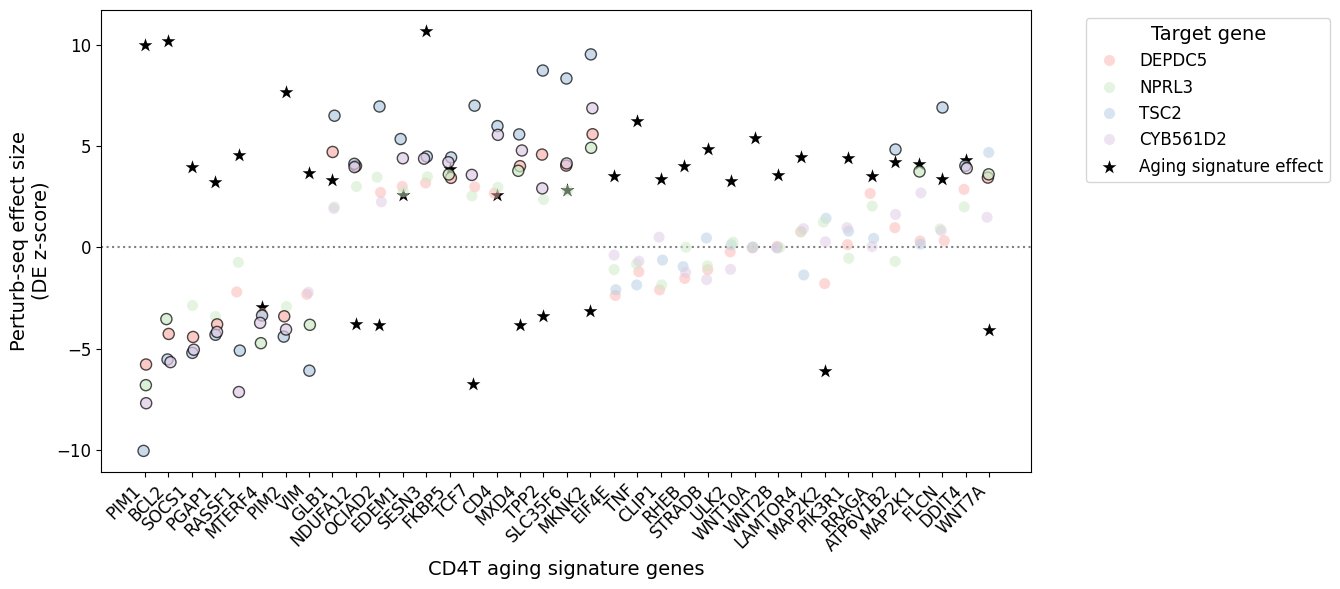

In [83]:
gr = ['DEPDC5', 'TSC2', 'NPRL3', 'CYB561D2']
# Get absolute means for each row
gene_means = wide_de_results.loc[gr].mean()
abs_means = wide_de_results.loc[gr].abs().mean()

# Sort by absolute means and get top n rows
top_n = 20  # Adjust this value as needed
top_n_genes = abs_means.nlargest(top_n).index

# Get all mTOR genes
mtor_genes = pd.Index(mtor_signif_aging)
# Combine top_n and all mTOR genes, preserving order and removing duplicates
concatenated = np.concatenate([top_n_genes, mtor_genes])
top_rows = pd.Index(pd.Series(concatenated).drop_duplicates(), name='gene')
signif = wide_de_results_signif.T.loc[gr, top_rows] < 0.1

pl_df = wide_de_results.loc[gr, means.loc[top_rows].sort_values().index].reset_index().melt(id_vars='target_contrast_gene_name')
signif = wide_de_results_signif.T.loc[gr, top_rows] < 0.1

# Calculate mean values per gene separately for top_n and mTOR genes
gene_means = pl_df.groupby('gene')['value'].mean()
top_n_means = gene_means[top_n_genes].sort_values()
mtor_means = gene_means[mtor_genes].sort_values()

# Combine ordered indices
concatenated = np.concatenate([top_n_means.index, mtor_means.index])
gene_order = pd.Index(pd.Series(concatenated).drop_duplicates())

pl_df['aging_effect'] = y_target.loc[pl_df['gene']].values
pl_df['target_contrast_gene_name'] = pl_df['target_contrast_gene_name'].astype(str)
pl_df['significant'] = False
for gene in gr:
    for target in top_rows:
        pl_df.loc[(pl_df['target_contrast_gene_name'] == gene) & (pl_df['gene'] == target), 'significant'] = signif.loc[gene, target]

plt.figure(figsize=(12, 6))
plt.axhline(y=0, color='grey', linestyle=':', zorder=0)

palette = {name: sns.color_palette('Pastel1')[i] 
          for i, name in enumerate(pl_df['target_contrast_gene_name'].unique())}


# Create base stripplot with legend using ordered genes
ax = sns.stripplot(data=pl_df[~pl_df.significant], x='gene', y='value', 
                  hue='target_contrast_gene_name', dodge=False, palette=palette,
                  order=gene_order, size=8, alpha=0.5)

# Add points with black outline for significant values, no legend
ax = sns.stripplot(data=pl_df[pl_df.significant], x='gene', y='value', 
                  hue='target_contrast_gene_name', dodge=False, 
                  edgecolor='black', linewidth=1, palette=palette, legend=False,
                  order=gene_order, size=8, alpha=0.7)

# Add scatter points for aging effect
sns.scatterplot(data=pl_df, x='gene', y='aging_effect', s=200, color='black', marker='*', label='Aging signature effect')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add axis labels
plt.xlabel('CD4T aging signature genes', fontsize=14)
plt.ylabel('Perturb-seq effect size\n(DE z-score)', fontsize=14)

# Move legend outside with larger font
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add axis labels
plt.xlabel('CD4T aging signature genes', fontsize=14)
plt.ylabel('Perturb-seq effect size\n(DE z-score)', fontsize=14)

# Move legend outside with larger font
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Target gene', fontsize=12, title_fontsize=14)

In [88]:
long_de_results[(long_de_results['target_contrast_gene_name'] == 'TSC2') & (long_de_results['gene_name'] == 'TNF')]

index gene    log_fc    zscore  adj_p_value  \
98718  ENSG00000103197_Rest  TNF -0.343021 -1.864545     0.257071   

       significant gene_name culture_condition  target_contrast  \
98718        False       TNF              Rest  ENSG00000103197   

      target_contrast_gene_name  
98718                      TSC2

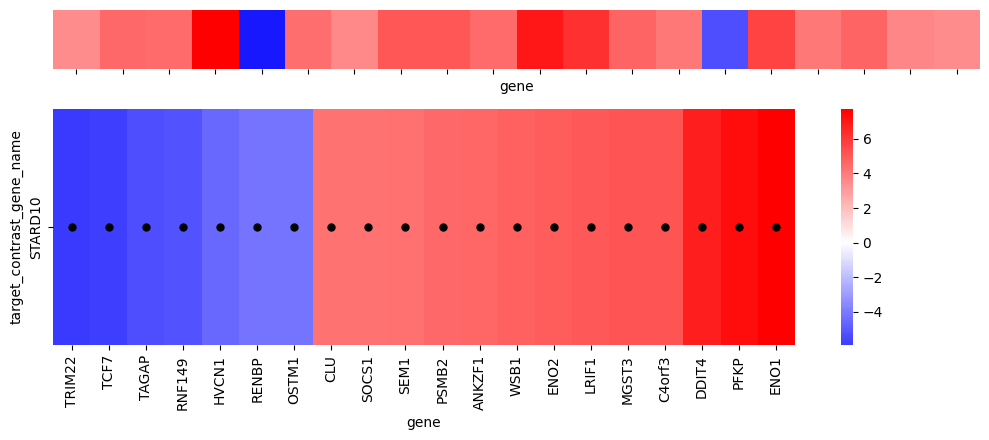

In [331]:
gr = ['TEX22', 'TAP1', 'RAB2B', 'AMIGO1', 'C4orf47', 'RBPJL', 'YPEL5']
gr = ['STARD10']
# Get absolute means for each row
# means = y_target
means = wide_de_results.loc[gr].mean()
abs_means = wide_de_results.loc[gr].abs().mean()

# Sort by absolute means and get top n rows
top_n = 20  # Adjust this value as needed
top_rows = abs_means.nlargest(top_n).index
signif = wide_de_results_signif.T.loc[gr, top_rows] < 0.1

sign_effect = y_target.loc[top_rows]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(n_cols/2, n_rows/2 + 1), 
                              gridspec_kw={'height_ratios': [1, 4]}, sharex=True)

# Plot sign effect heatmap on top
sns.heatmap(sign_effect.to_frame().T, 
            cmap='bwr',
            center=0,
            ax=ax1,
            xticklabels=True,
            yticklabels=False,
            cbar=False)

# Plot main heatmap below
sns.heatmap(wide_de_results.loc[gr, means.loc[top_rows].sort_values().index],
            cmap='bwr',
            center=0, 
            xticklabels=True,
            yticklabels=True,
            ax=ax2)

# Add significance markers
for y, row in enumerate(wide_de_results.loc[gr, top_rows].index):
    for x, col in enumerate(wide_de_results.loc[gr, top_rows].columns):
        if signif.loc[row, col]:
            ax2.plot(x + 0.5, y + 0.5, 'o', markersize=5, color='black')

plt.tight_layout()


In [320]:
wide_de_results.loc[gr, means.loc[top_rows].sort_values().index]

gene                          PSMB9    ARID5B    TMBIM4     PSMB8    COMMD6  \
target_contrast_gene_name                                                     
TEX22                     -1.428723 -1.153653 -2.599479 -1.836247  0.245474   
TAP1                      -7.062777 -0.467053 -0.983610 -7.228208 -2.033591   
RAB2B                     -1.749144 -3.634128 -2.790990 -1.072344 -2.872929   
AMIGO1                    -1.054912 -0.432658  0.103269 -0.864337  0.852177   
C4orf47                   -0.510677 -2.170972 -1.184742  0.110103 -1.528485   
RBPJL                      0.302608 -1.101771 -0.601119  0.009775 -0.826874   
YPEL5                     -0.120142 -2.230391 -2.987506 -0.069406 -2.770267   

gene                         PSMB10    ZNF397     PARP9     CCNL2     OARD1  \
target_contrast_gene_name                                                     
TEX22                     -1.686650 -1.404988 -1.780737  1.172427  1.119446   
TAP1                      -1.735755  1.359160 -1.150737 -1.021401 -3.007945   
RAB2B                     -2.295998 -0.778304 -0.970977 -1.860274  1.046007   
AMIGO1                    -1.759696 -2.211136 -1.354077  0.361269 -2.369764   
C4orf47                   -2.496481 -2.018743 -1.805157 -0.705323 -2.663374   
RBPJL                     -0.661474 -1.821611  1.471906 -4.349655 -0.427197   
YPEL5                      1.749300 -1.806054 -2.928669 -1.811342 -1.836531   

gene                         NT5DC1    ZNF580      CNN2      CNBP     TENT2  \
target_contrast_gene_name                                                     
TEX22                      2.106257 -0.320316  0.130694 -1.277166  3.073273   
TAP1                      -2.218911  3.712319 -1.311742  2.992775  1.308140   
RAB2B                     -1.998112 -1.883051 -2.642070  1.143975 -2.845761   
AMIGO1                    -2.081646  0.754143 -0.978109 -1.627312  2.326457   
C4orf47                    1.055300 -1.560452 -1.156447  1.058049 -1.540645   
RBPJL                     -2.139816 -1.567650 -0.600798 -1.053677 -1.059345   
YPEL5                      1.061531 -1.643446  5.032531 -2.490333  0.949399   

gene                          CTLA4     MPRIP     ERO1A     AP2S1     RBM38  
target_contrast_gene_name                                                    
TEX22                      8.268802 -0.329842  2.716437  1.483713  3.882282  
TAP1                       0.222890 -0.548192 -0.184410  3.590788  1.471637  
RAB2B                     -0.279076  4.349950  2.474598  1.318633  0.789106  
AMIGO1                     3.628035  1.202282  3.031875  0.513569  2.783765  
C4orf47                   -0.516736  1.840921  2.633380  1.541640  0.317033  
RBPJL                      0.328548  1.806229  0.291716  2.446878  1.412827  
YPEL5                     -0.808144  2.644872  0.695219  0.795777  2.154858

target_contrast_gene_name     MCTS1    TCEAL1
target_contrast_gene_name                    
MCTS1                      1.000000  0.342203
TCEAL1                     0.342203  1.000000

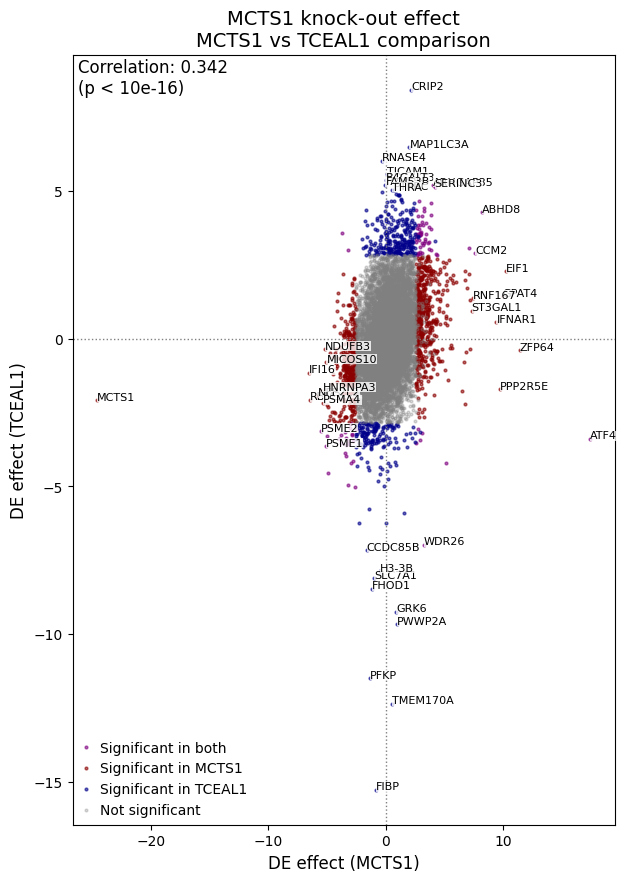

In [200]:
outs = plot_effect_comparison(
    adata_de,
    comparison_params = {'culture_condition':['Rest'], 'target_contrast_gene_name':['MCTS1', 'TCEAL1'], 'stat':['zscore']},
    n_top_genes=10,
    plot_correlation=True,
    axis_label='DE effect',
    figsize=(7, 10),
    # ax=None,
    # annotate_genes=pg[(pg.source=='PI3K') & (pg.padj < 0.1)]['target'].tolist()
    annotate_significant=True
)
outs[2].dropna().corr()

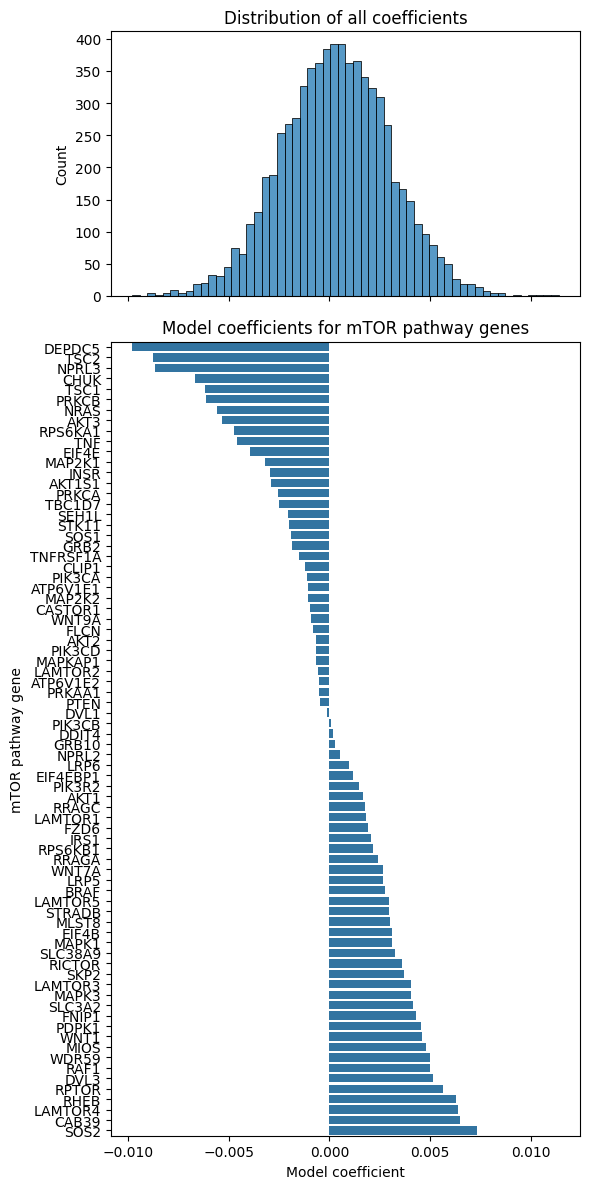

In [122]:
coefs_df = p2t_model.get_coefs()

# Get coefficients for mTOR pathway genes
mtor_genes = KEGG_sets['mTOR signaling pathway']
mtor_coefs = coefs_df.loc[coefs_df.index.intersection(mtor_genes)]
mtor_coefs = mtor_coefs.sort_values('coef_mean')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12), height_ratios=[1,3], sharex=True)

# Plot histogram of all coefficients on top subplot
sns.histplot(data=coefs_df, x='coef_mean', ax=ax1)
ax1.set_xlabel('Model coefficient')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of all coefficients')

# Plot sorted mTOR coefficients on bottom subplot
sns.barplot(data=mtor_coefs.reset_index(), x='coef_mean', y='index', ax=ax2)
ax2.set_xlabel('Model coefficient')
ax2.set_ylabel('mTOR pathway gene')
ax2.set_title('Model coefficients for mTOR pathway genes')

plt.tight_layout()

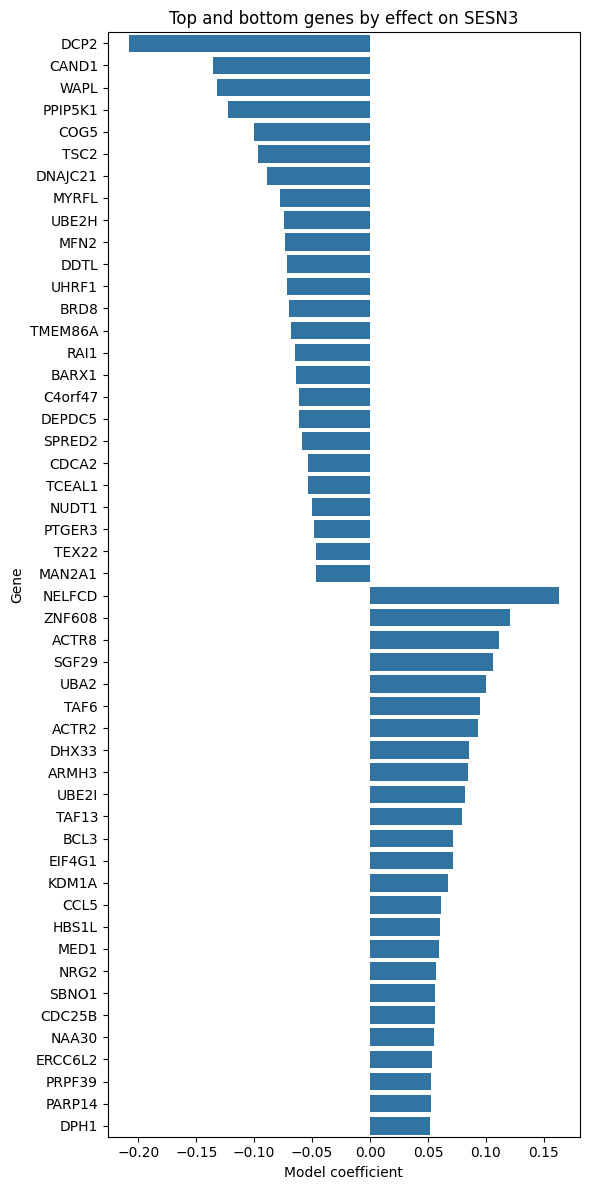

In [112]:
g = 'CISH'
g_coefs_df = p2t_model.get_effect_per_gene(X_perturbs_masked, g).sort_values('pred_mean')
effect = g_coefs_df['pred_mean'] * X_perturbs.loc[g]

# Get top and bottom 25 genes by coefficient
top_genes = effect.nlargest(25)
bottom_genes = effect.nsmallest(25)
plot_genes = pd.concat([bottom_genes, top_genes])
plot_genes = plot_genes.reset_index()
plot_genes['target_contrast_gene_name'] = plot_genes['target_contrast_gene_name'].astype(str)

plt.figure(figsize=(6,12))
sns.barplot(data=plot_genes.reset_index(), x=0, y='target_contrast_gene_name')
plt.xlabel('Model coefficient')
plt.ylabel('Gene')
plt.title('Top and bottom genes by effect on SESN3')
plt.tight_layout()

(array([3.000e+00, 3.000e+00, 0.000e+00, 3.000e+00, 3.000e+01, 3.370e+02,
        6.335e+03, 1.540e+02, 2.700e+01, 4.000e+00]),
 array([-0.15049899, -0.12673473, -0.10297047, -0.07920621, -0.05544195,
        -0.03167769, -0.00791343,  0.01585083,  0.03961509,  0.06337935,
         0.08714361]),
 <BarContainer object of 10 artists>)

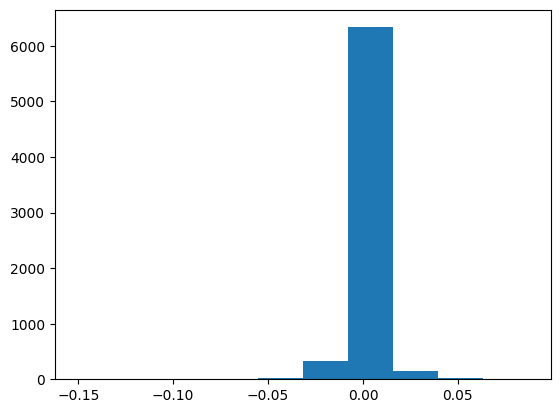

In [118]:
g = 'SESN3'
g_coefs_df = p2t_model.get_effect_per_gene(X_perturbs_masked, g).sort_values('pred_mean')
g_coefs_df['pred_mean'] * X_perturbs.loc[g]

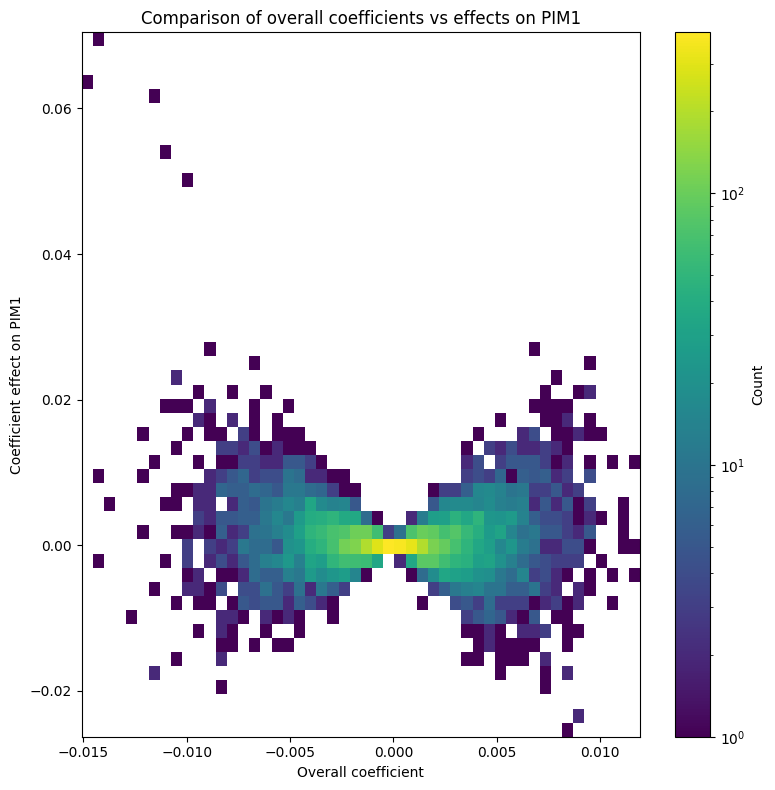

In [104]:
# Get coefficients for PIM1 effects and overall coefficients
g_coefs_df = p2t_model.get_effect_per_gene(X_perturbs_masked, 'PIM1').sort_values('pred_mean')
coefs_df = p2t_model.get_coefs()

# Merge the two coefficient dataframes
merged_coefs = pd.merge(
    g_coefs_df['pred_mean'].reset_index().rename(columns={'pred_mean': 'pim1_coef'}),
    coefs_df['coef_mean'].reset_index().rename(columns={'coef_mean': 'overall_coef', 'index':'target_contrast_gene_name'}),
    on='target_contrast_gene_name'
)

# Create 2D histogram plot with log-normalized colors
plt.figure(figsize=(8, 8))
plt.hist2d(merged_coefs['overall_coef'], merged_coefs['pim1_coef'], 
           bins=50, norm=matplotlib.colors.LogNorm())
plt.colorbar(label='Count')
plt.xlabel('Overall coefficient')
plt.ylabel('Coefficient effect on PIM1')
plt.title('Comparison of overall coefficients vs effects on PIM1')


plt.tight_layout()
plt.show()


### mTORC1 

In [125]:
import gseapy as gp
from gseapy import Msigdb
from gseapy import barplot, dotplot

msig = Msigdb()
kegg_gene_sets = msig.get_gmt(category= 'c2.cp.kegg_legacy', dbver="2025.1.Hs")
reactome_gene_sets = msig.get_gmt(category= 'c2.cp.reactome', dbver="2025.1.Hs")

In [126]:
aging_down = res_df[(res_df['adj_p_value'] < 0.05) & (res_df.log_fc < 0)]['gene_name'].tolist()
aging_up = res_df[(res_df['adj_p_value'] < 0.05) & (res_df.log_fc > 0)]['gene_name'].tolist()
aging_all = res_df['gene_name'].tolist()

NameError: name 'res_df' is not defined

In [12]:
enr = gp.enrichr(gene_list=aging_up, # or "./tests/data/gene_list.txt",
                 gene_sets={**reactome_gene_sets, **kegg_gene_sets},
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                 background=aging_all
                )
enrichr_results_aging_up = enr.results.sort_values('Adjusted P-value')

enr = gp.enrichr(gene_list=aging_down, # or "./tests/data/gene_list.txt",
                 gene_sets={**reactome_gene_sets, **kegg_gene_sets},
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                 background=aging_all
                )
enrichr_results_aging_down = enr.results.sort_values('Adjusted P-value')


In [13]:
enrichr_results_aging_up[enrichr_results_aging_up['Term'].str.contains('PI3K')]

Gene_set                                               Term Overlap  \
680   gs_ind_0  REACTOME_G_BETA_GAMMA_SIGNALLING_THROUGH_PI3KG...    3/25   
327   gs_ind_0         REACTOME_CD28_DEPENDENT_PI3K_AKT_SIGNALING    3/27   
187   gs_ind_0      REACTOME_ACTIVATED_NTRK3_SIGNALS_THROUGH_PI3K     1/6   
865   gs_ind_0          REACTOME_MET_ACTIVATES_PI3K_AKT_SIGNALING     1/6   
186   gs_ind_0      REACTOME_ACTIVATED_NTRK2_SIGNALS_THROUGH_PI3K     1/7   
938   gs_ind_0  REACTOME_NEGATIVE_REGULATION_OF_THE_PI3K_AKT_N...   9/121   
1048  gs_ind_0                       REACTOME_PI3K_AKT_ACTIVATION     1/9   
1051  gs_ind_0            REACTOME_PI3K_EVENTS_IN_ERBB4_SIGNALING    1/10   
543   gs_ind_0  REACTOME_ERYTHROPOIETIN_ACTIVATES_PHOSPHOINOSI...    1/12   
1050  gs_ind_0            REACTOME_PI3K_EVENTS_IN_ERBB2_SIGNALING    1/16   
1049  gs_ind_0              REACTOME_PI3K_AKT_SIGNALING_IN_CANCER   6/113   
386   gs_ind_0  REACTOME_CONSTITUTIVE_SIGNALING_BY_ABERRANT_PI...    4/86   

       P-value  Adjusted P-value  Odds Ratio  Combined Score  \
680   0.242962          0.362464    2.117116        2.995399   
327   0.280831          0.407169    1.944176        2.469106   
187   0.346615          0.453874    3.710714        3.931654   
865   0.346615          0.453874    3.710714        3.931654   
186   0.391359          0.494552    3.139743        2.945485   
938   0.448566          0.547699    1.149010        0.921160   
1048  0.471869          0.566174    2.400839        1.803162   
1051  0.508038          0.599622    2.148056        1.454660   
543   0.573119          0.651467    1.774377        0.987729   
1050  0.678598          0.740978    1.316318        0.510371   
1049  0.793637          0.834272    0.821863        0.189957   
386   0.848406          0.879613    0.741354        0.121876   

                                                  Genes  
680                                     GNG2;GNG10;GNG5  
327                                  THEM4;PIK3R1;TRIB3  
187                                              PIK3R1  
865                                              PIK3R1  
186                                              PIK3R1  
938   PIP5K1A;IRAK4;TRIB3;TRAT1;FLT3LG;PPP2R5A;PIK3R...  
1048                                             PIK3R1  
1051                                             PIK3R1  
543                                              PIK3R1  
1050                                             PIK3R1  
1049             TRAT1;FLT3LG;PIK3R1;CDKN1B;ESR2;CDKN1A  
386                            FLT3LG;PIK3R1;ESR2;TRAT1

/tmp/ipykernel_3512110/2172689222.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_df['term_label'] = up_df['Term'] + "\n(" + up_df['Genes'] + ")"
/tmp/ipykernel_3512110/2172689222.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_df['term_label'] = down_df['Term'] + "\n(" + down_df['Genes'] + ")"


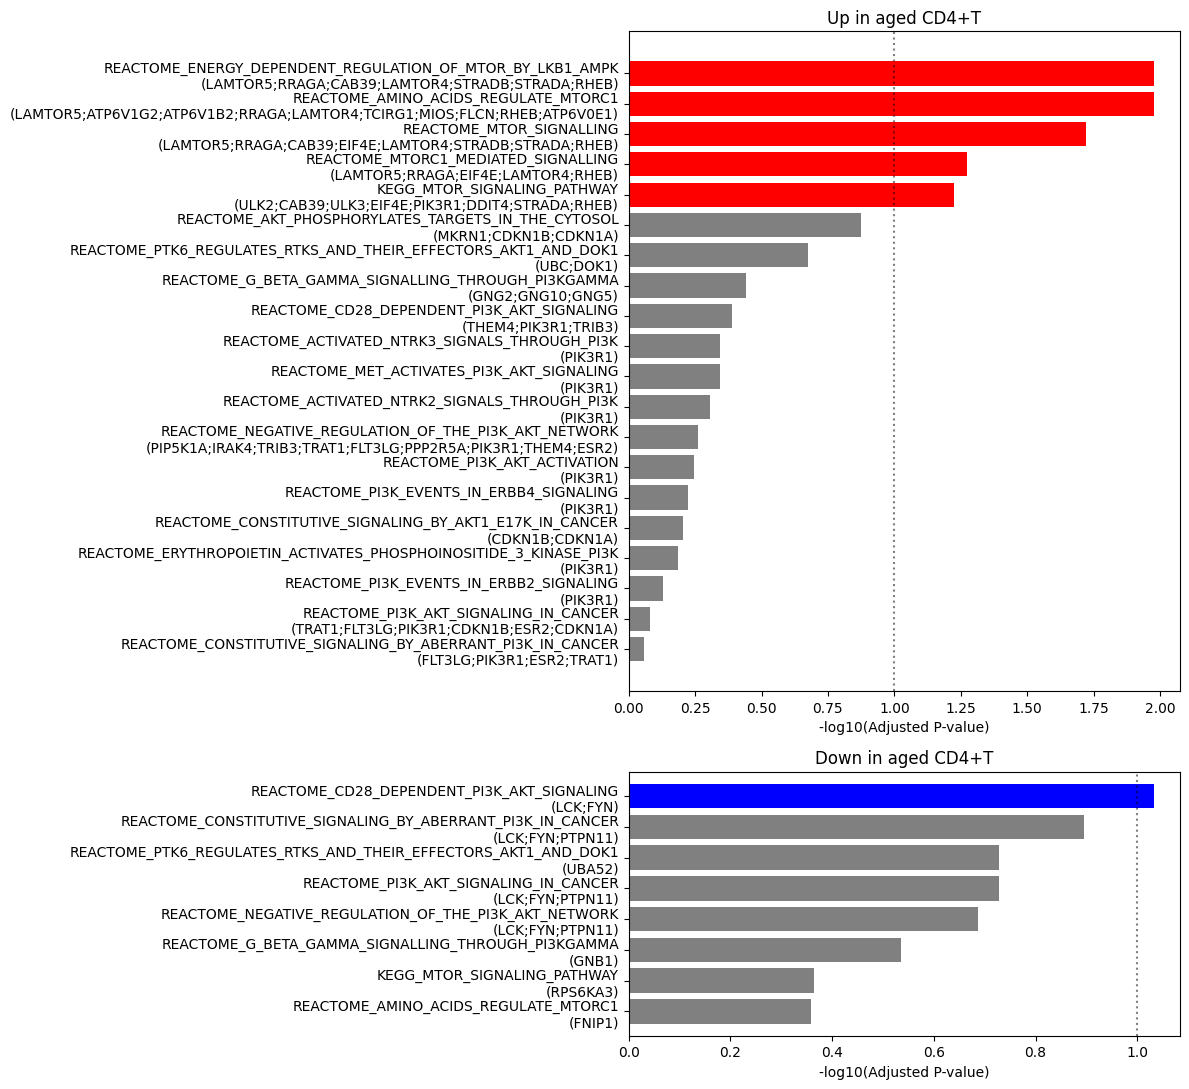

In [28]:
# Get number of terms in each plot for proportional heights
up_df = enrichr_results_aging_up[enrichr_results_aging_up['Term'].str.contains('MTOR|PI3K|AKT')]
down_df = enrichr_results_aging_down[enrichr_results_aging_down['Term'].str.contains('MTOR|PI3K|AKT')]
up_terms = len(up_df)
down_terms = len(down_df)
total_terms = up_terms + down_terms

# Calculate proportional heights
up_height = 10 * (up_terms/total_terms)
down_height = 10 * (down_terms/total_terms)
# Set up figure and subplots with height ratios
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 11), 
                              height_ratios=[up_height, down_height])

# Plot for up-regulated genes
up_df['term_label'] = up_df['Term'] + "\n(" + up_df['Genes'] + ")"

# Create bar colors based on significance
colors = ['red' if p < 0.1 else 'grey' for p in up_df['Adjusted P-value']]

ax1.barh(y=up_df['term_label'], 
         width=-np.log10(up_df['Adjusted P-value']),
         height=0.8,
         color=colors)

# Add dotted line at p=0.1 threshold
ax1.axvline(-np.log10(0.1), color='black', linestyle=':', alpha=0.5)

ax1.set_xlabel('-log10(Adjusted P-value)')
ax1.set_title('Up in aged CD4+T')
ax1.invert_yaxis() # Put lowest p-values at top

# Plot for down-regulated genes
down_df['term_label'] = down_df['Term'] + "\n(" + down_df['Genes'] + ")"

# Create bar colors based on significance
colors = ['blue' if p < 0.1 else 'grey' for p in down_df['Adjusted P-value']]

ax2.barh(y=down_df['term_label'], 
         width=-np.log10(down_df['Adjusted P-value']),
         height=0.8,
         color=colors)

# Add dotted line at p=0.1 threshold
ax2.axvline(-np.log10(0.1), color='black', linestyle=':', alpha=0.5)

ax2.set_xlabel('-log10(Adjusted P-value)')
ax2.set_title('Down in aged CD4+T')
ax2.invert_yaxis() # Put lowest p-values at top

plt.tight_layout()



In [62]:
up_df[up_df['Adjusted P-value'] < 0.1]

Gene_set                                               Term Overlap  \
528  gs_ind_0  REACTOME_ENERGY_DEPENDENT_REGULATION_OF_MTOR_B...    7/29   
231  gs_ind_0               REACTOME_AMINO_ACIDS_REGULATE_MTORC1   10/53   
911  gs_ind_0                           REACTOME_MTOR_SIGNALLING    8/41   
910  gs_ind_0                REACTOME_MTORC1_MEDIATED_SIGNALLING    5/24   
96   gs_ind_0                        KEGG_MTOR_SIGNALING_PATHWAY    8/52   

      P-value  Adjusted P-value  Odds Ratio  Combined Score  \
528  0.002861          0.010550    4.543944       26.612173   
231  0.002869          0.010550    3.292367       19.272260   
911  0.005963          0.018998    3.459090       17.717877   
910  0.021312          0.053295    3.842138       14.786454   
96   0.024210          0.059735    2.603193        9.686424   

                                                 Genes  \
528     LAMTOR5;RRAGA;CAB39;LAMTOR4;STRADB;STRADA;RHEB   
231  LAMTOR5;ATP6V1G2;ATP6V1B2;RRAGA;LAMTOR4;TCIRG1...   
911  LAMTOR5;RRAGA;CAB39;EIF4E;LAMTOR4;STRADB;STRAD...   
910                   LAMTOR5;RRAGA;EIF4E;LAMTOR4;RHEB   
96      ULK2;CAB39;ULK3;EIF4E;PIK3R1;DDIT4;STRADA;RHEB   

                                            term_label  
528  REACTOME_ENERGY_DEPENDENT_REGULATION_OF_MTOR_B...  
231  REACTOME_AMINO_ACIDS_REGULATE_MTORC1\n(LAMTOR5...  
911  REACTOME_MTOR_SIGNALLING\n(LAMTOR5;RRAGA;CAB39...  
910  REACTOME_MTORC1_MEDIATED_SIGNALLING\n(LAMTOR5;...  
96   KEGG_MTOR_SIGNALING_PATHWAY\n(ULK2;CAB39;ULK3;...

In [63]:
mtor_genes_up = [gene for genes in up_df[up_df['Adjusted P-value'] < 0.1]['Genes'].str.split(';') for gene in genes]
mtor_genes_up = KEGG_sets['mTOR signaling pathway'] + reactome_gene_sets['REACTOME_MTOR_SIGNALLING'] + reactome_gene_sets['REACTOME_AMINO_ACIDS_REGULATE_MTORC1'] + reactome_gene_sets['REACTOME_MTORC1_MEDIATED_SIGNALLING']
# mtor_genes_up = 

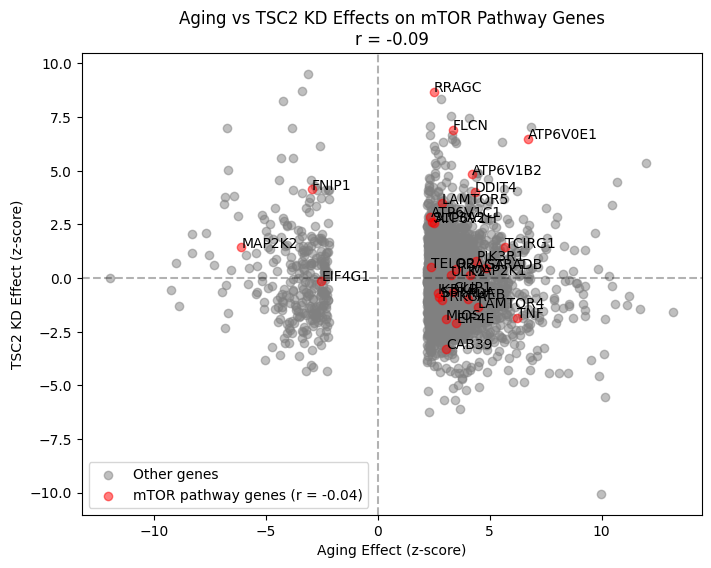

In [64]:
# Get aging effect for all significant genes
aging_effect = res_df[res_df['adj_p_value'] < 0.1]
pseq_effect = get_DE_results_long(adata_de[adata_de.obs['culture_condition'] == 'Rest'], targets=['TSC2']).dropna()

# Get genes present in both datasets
common_genes = np.intersect1d(aging_effect.gene_name, pseq_effect.gene_name)
aging_effect = aging_effect.set_index('gene_name').loc[common_genes].reset_index()
pseq_effect = pseq_effect.set_index('gene_name').loc[common_genes].reset_index()

# Calculate correlation coefficient
corr = np.corrcoef(aging_effect['zscore'], pseq_effect['zscore'])[0,1]

# Create scatter plot
plt.figure(figsize=(8,6))

# Plot all genes in gray
plt.scatter(aging_effect[~aging_effect.gene_name.isin(mtor_genes_up)]['zscore'], 
           pseq_effect[~aging_effect.gene_name.isin(mtor_genes_up)]['zscore'], 
           alpha=0.5, color='gray', label='Other genes')
# Plot mTOR genes in red and calculate their correlation
mtor_mask = aging_effect.gene_name.isin(mtor_genes_up)
mtor_corr = np.corrcoef(aging_effect[mtor_mask]['zscore'], 
                        pseq_effect[mtor_mask]['zscore'])[0,1]
plt.scatter(aging_effect[mtor_mask]['zscore'],
           pseq_effect[mtor_mask]['zscore'], 
           alpha=0.5, color='red', 
           label=f'mTOR pathway genes (r = {mtor_corr:.2f})')

plt.xlabel('Aging Effect (z-score)')
plt.ylabel('TSC2 KD Effect (z-score)')

# Add gene labels for mTOR genes
for i, row in aging_effect[aging_effect.gene_name.isin(mtor_genes_up)].iterrows():
    plt.annotate(row['gene_name'], 
                (row['zscore'], pseq_effect.loc[i, 'zscore']))

plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.title(f'Aging vs TSC2 KD Effects on mTOR Pathway Genes\nr = {corr:.2f}')
plt.legend()

Text(0.5, 0, 'CD4T aging signature genes (mTOR signalling pathway)')

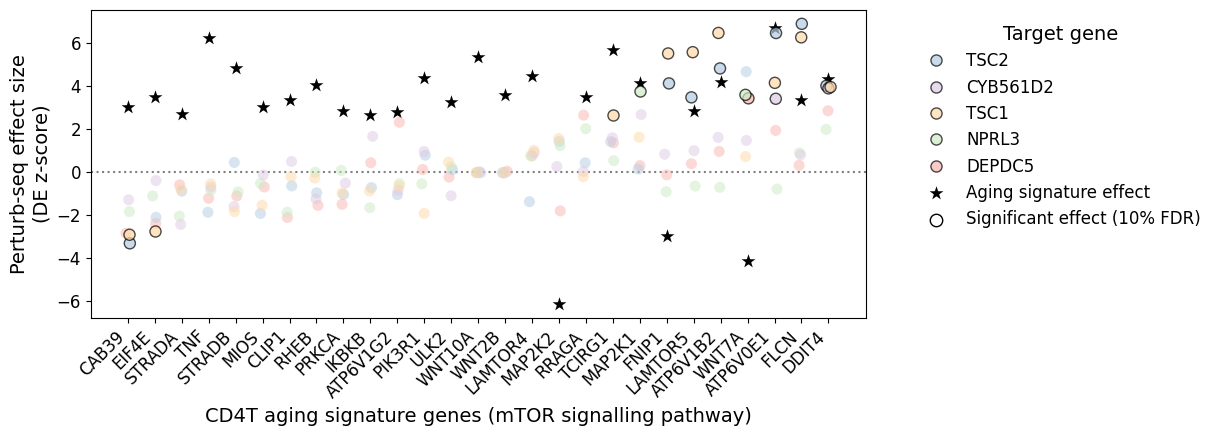

In [99]:
mtor_genes_up = KEGG_sets['mTOR signaling pathway'] + reactome_gene_sets['REACTOME_MTOR_SIGNALLING'] + reactome_gene_sets['REACTOME_AMINO_ACIDS_REGULATE_MTORC1'] + reactome_gene_sets['REACTOME_MTORC1_MEDIATED_SIGNALLING']
plot_regulator_effects(adata_de, np.intersect1d(mtor_genes_up, y_target.index), gr, y_target, figsize=(10,4))
plt.xlabel('CD4T aging signature genes (mTOR signalling pathway)')

In [149]:
import decoupler as dc

pg = dc.op.progeny()
pg.source.unique()

array(['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK',
       'NFkB', 'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],
      dtype=object)

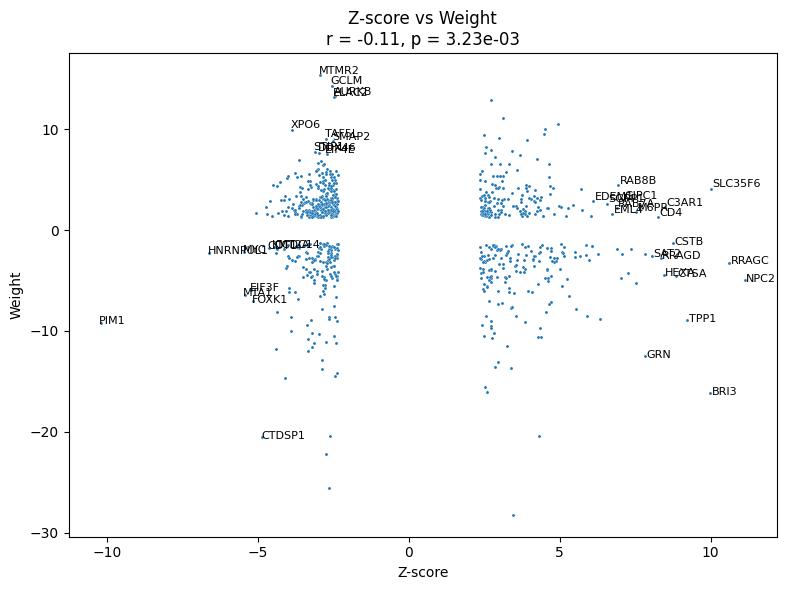

In [150]:
# signature = res_df.copy()
signature = get_DE_results_long(adata_de[adata_de.obs['culture_condition'] == 'Rest'], targets=['TSC1'])
signature = pd.merge(signature, pg[pg.source == 'PI3K'].rename({'target':'gene_name'}, axis=1), how='inner').dropna()
signature = signature[signature['adj_p_value'] < 0.1]  # Filter to significant genes
signature['PROGENy_signed_padj'] = -np.log10(signature['padj']) * np.sign(signature.weight)
# Calculate correlation coefficient and p-value
corr, pval = scipy.stats.pearsonr(signature['zscore'], signature['PROGENy_signed_padj'])

plt.figure(figsize=(8,6))
sns.scatterplot(data=signature, x='zscore', y='PROGENy_signed_padj', s=5)

# Get top 3 genes in each quadrant
q1 = signature[(signature['zscore'] > 0) & (signature['PROGENy_signed_padj'] > 0)].nlargest(10, 'zscore')
q2 = signature[(signature['zscore'] < 0) & (signature['PROGENy_signed_padj'] > 0)].nlargest(10, 'PROGENy_signed_padj') 
q3 = signature[(signature['zscore'] < 0) & (signature['PROGENy_signed_padj'] < 0)].nsmallest(10, 'zscore')
q4 = signature[(signature['zscore'] > 0) & (signature['PROGENy_signed_padj'] < 0)].nlargest(10, 'zscore')

# Annotate genes in each quadrant
for df, offset in [(q1, (0.1, 0.1)), (q2, (-0.1, 0.1)), (q3, (-0.1, -0.1)), (q4, (0.1, -0.1))]:
    for _, row in df.iterrows():
        plt.annotate(row['gene_name'], 
                    (row['zscore'], row['PROGENy_signed_padj']),
                    xytext=(10*offset[0], 10*offset[1]), 
                    textcoords='offset points',
                    fontsize=8)

plt.xlabel('Z-score')
plt.ylabel('Weight')
plt.title(f'Z-score vs Weight\nr = {corr:.2f}, p = {pval:.2e}')
plt.tight_layout()

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'TSC1 knock-out effect\nRICTOR vs TSC1 comparison'}, xlabel='DE effect (RICTOR)', ylabel='DE effect (TSC1)'>,
 target_contrast_gene_name    RICTOR      TSC1
 gene                                         
 A2M                             NaN       NaN
 A4GALT                    -0.397279 -0.482546
 AAAS                       0.060090 -2.055204
 AACS                      -0.477015 -1.926299
 AAGAB                      1.023613  0.797505
 ...                             ...       ...
 ZYG11A                     1.163788 -0.220807
 ZYG11B                     1.076941  3.166825
 ZYX                        0.317257 -1.436141
 ZZEF1                     -1.202908 -1.971023
 ZZZ3                      -0.643166  0.491626
 
 [13959 rows x 2 columns])

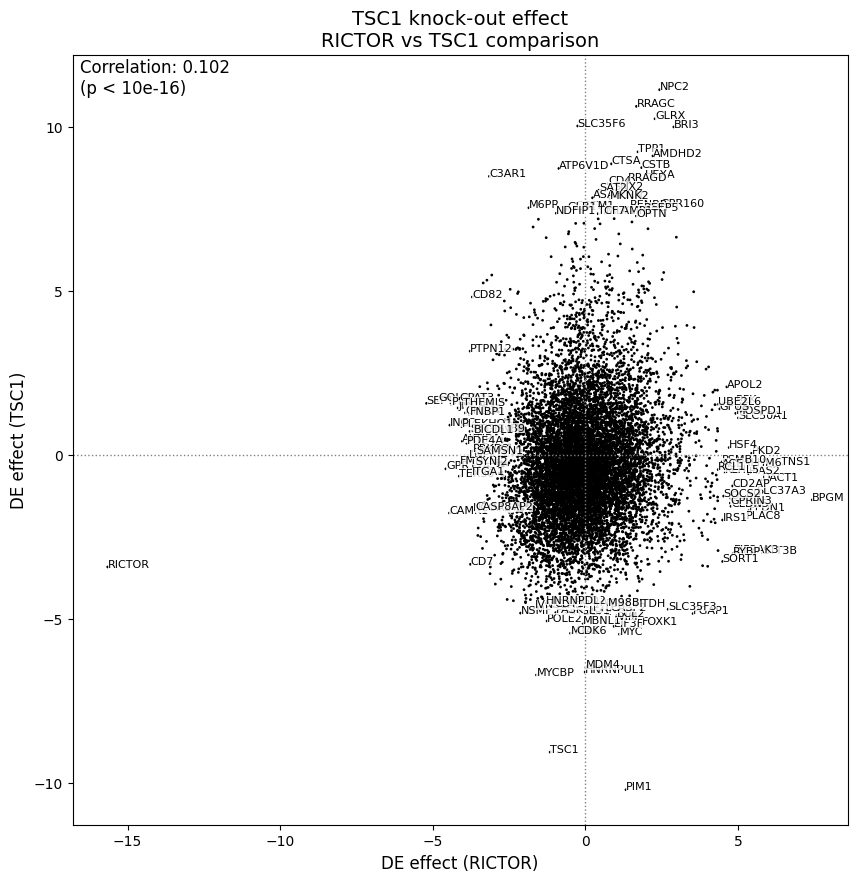

In [24]:
plot_effect_comparison(
    adata_de,
    comparison_params = {'culture_condition':['Rest'], 'target_contrast_gene_name':['TSC1', 'RICTOR'], 'stat':['zscore']},
    n_top_genes=30,
    plot_correlation=True,
    axis_label='DE effect',
    figsize=(10, 10),
    # ax=None,
    # annotate_genes=pg[(pg.source=='PI3K') & (pg.padj < 0.1)]['target'].tolist()
)

In [28]:
targets = DE_stats[DE_stats['target_name'].isin(KEGG_sets['mTOR signaling pathway']) & (DE_stats.n_total_de_genes > 3)].target_name.unique()
# targets = DE_stats[DE_stats['target_name'].isin(KEGG_sets['PI3K-Akt signaling pathway']) & (DE_stats.n_total_de_genes > 3)].target_name.unique()
pseq_effect = get_DE_results_long(adata_de[adata_de.obs['culture_condition'] == 'Rest'], targets=targets)
pseq_effect

index    gene    log_fc    zscore  adj_p_value  \
0       ENSG00000063046_Rest     A2M       NaN       NaN          NaN   
1       ENSG00000063046_Rest  A4GALT -0.003127 -0.001822          NaN   
2       ENSG00000063046_Rest    AAAS  0.058794  0.573324     0.881618   
3       ENSG00000063046_Rest    AACS  0.012612  0.068863     0.988288   
4       ENSG00000063046_Rest   AAGAB -0.047107 -0.664379     0.855456   
...                      ...     ...       ...       ...          ...   
697945  ENSG00000250565_Rest  ZYG11A -1.670477 -1.652601          NaN   
697946  ENSG00000250565_Rest  ZYG11B -0.000418 -0.004756     0.999860   
697947  ENSG00000250565_Rest     ZYX -0.179092 -2.420584     0.838049   
697948  ENSG00000250565_Rest   ZZEF1  0.031413  0.523142     0.994614   
697949  ENSG00000250565_Rest    ZZZ3 -0.025683 -0.290621     0.996048   

        significant gene_name culture_condition  target_contrast  \
0             False       A2M              Rest  ENSG00000063046   
1             False    A4GALT              Rest  ENSG00000063046   
2             False      AAAS              Rest  ENSG00000063046   
3             False      AACS              Rest  ENSG00000063046   
4             False     AAGAB              Rest  ENSG00000063046   
...             ...       ...               ...              ...   
697945        False    ZYG11A              Rest  ENSG00000250565   
697946        False    ZYG11B              Rest  ENSG00000250565   
697947        False       ZYX              Rest  ENSG00000250565   
697948        False     ZZEF1              Rest  ENSG00000250565   
697949        False      ZZZ3              Rest  ENSG00000250565   

       target_contrast_gene_name  
0                          EIF4B  
1                          EIF4B  
2                          EIF4B  
3                          EIF4B  
4                          EIF4B  
...                          ...  
697945                  ATP6V1E2  
697946                  ATP6V1E2  
697947                  ATP6V1E2  
697948                  ATP6V1E2  
697949                  ATP6V1E2  

[697950 rows x 10 columns]

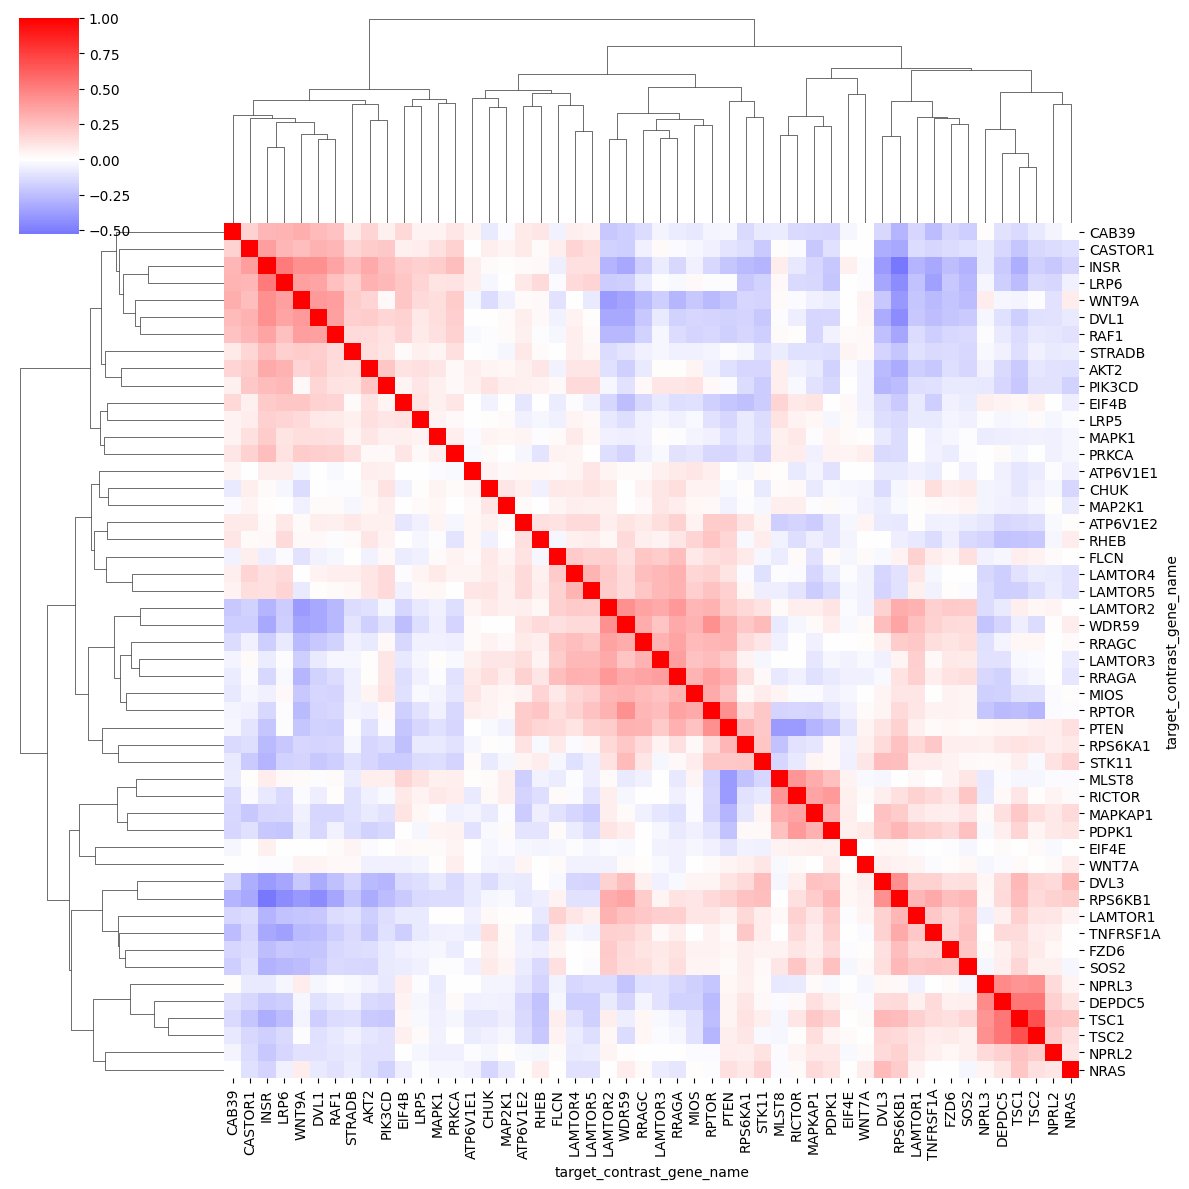

In [29]:
# Create color mapping for culture conditions
pivoted = pseq_effect.pivot(columns='target_contrast_gene_name', index='gene', values='zscore')
corr_matrix = pivoted.corr()
# conditions = corr_matrix.columns.get_level_values('culture_condition')

# color_map = {
#     'Rest': [0.8, 0.2, 0.2],
#     'Stim48hr': [0.2, 0.2, 0.8], 
#     'Stim8hr': [0.2, 0.8, 0.2]
# }

# col_colors = pd.DataFrame(
#     [color_map[cond] for cond in conditions],
#     index=corr_matrix.columns
# )

# # Create list of RGBA colors
# col_colors_rgba = [[*color_map[cond], 1.0] for cond in conditions]

sns.clustermap(
    corr_matrix,
    cmap='bwr',
    center=0,
    xticklabels=True,
    yticklabels=True,
    figsize=(12,12),
    # col_colors=col_colors_rgba,
    # row_colors=col_colors_rgba
)

In [35]:
corr_matrix.loc['TSC1', 'PIK3CD']

np.float64(-0.21783667070507365)

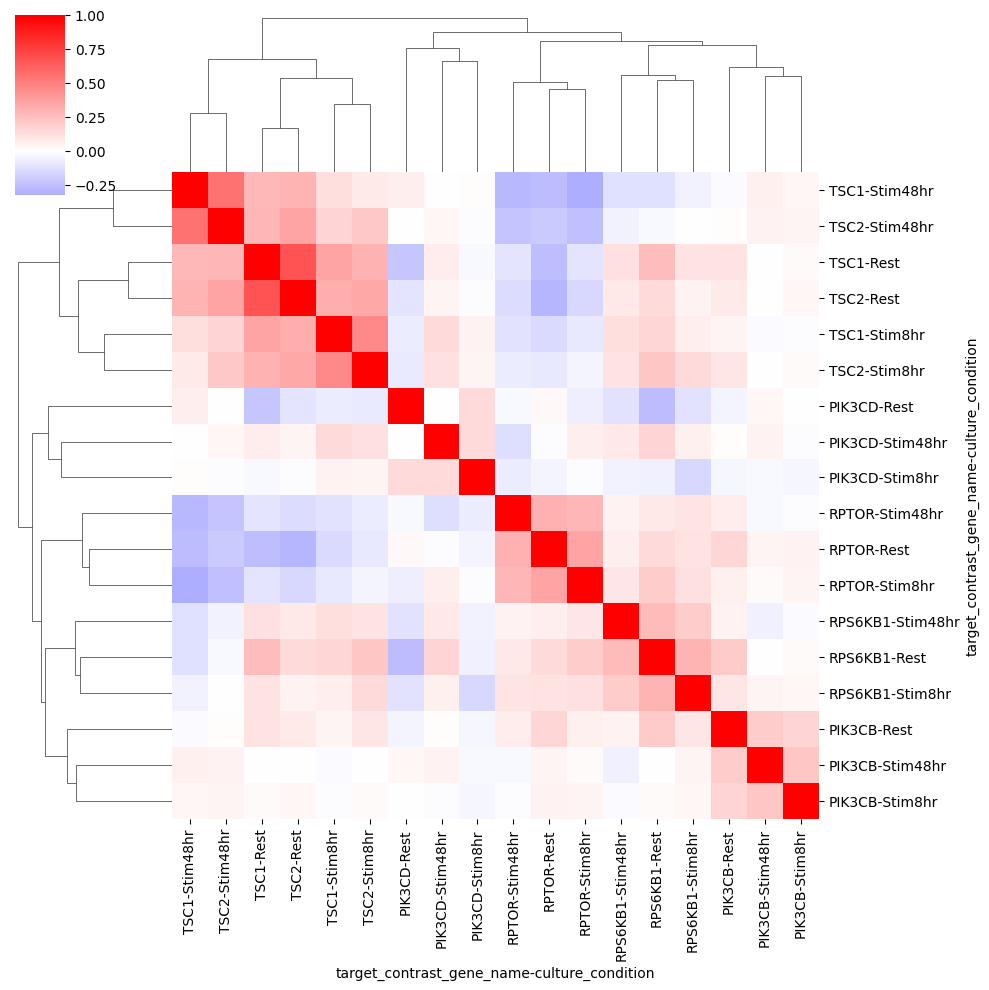

In [ ]:
feedback_loop = ['TSC1', 'TSC2', 'RHEB', 'RPTOR', 'RPS6KB1']
downstream = ['LPIN1',
 'GRB10',
 'RHOA',
 'PRKCA',
 'PRKCB',
 'PRKCG',
 'RPS6KB1',
 'RPS6KB2',
 'CLIP1',
 'SGK1',
 'LPIN3',
 'LPIN2',
 'IRS1']

targets = DE_stats[DE_stats['target_name'].isin(feedback_loop) & (DE_stats.n_total_de_genes > 3)].target_name.unique()
# targets = DE_stats[DE_stats['target_name'].isin(KEGG_sets['PI3K-Akt signaling pathway']) & (DE_stats.n_total_de_genes > 3)].target_name.unique()
pseq_effect = get_DE_results_long(adata_de, targets=targets)
pseq_effect[pseq_effect['target_contrast_gene_name'] == 'Rest']

 # Create color mapping for culture conditions
pivoted = pseq_effect.pivot(columns=['target_contrast_gene_name', 'culture_condition'], index='gene', values='zscore')
# Fill diagonal with 0 to mask self-correlations
np.fill_diagonal(corr_matrix.values, 0)

corr_matrix = pivoted.corr()

sns.clustermap(corr_matrix.loc[feedback_loop, feedback_loop], cmap='bwr', center=0)

target_contrast_gene_name      RHEB      TSC2
target_contrast_gene_name                    
RHEB                       1.000000 -0.218378
TSC2                      -0.218378  1.000000

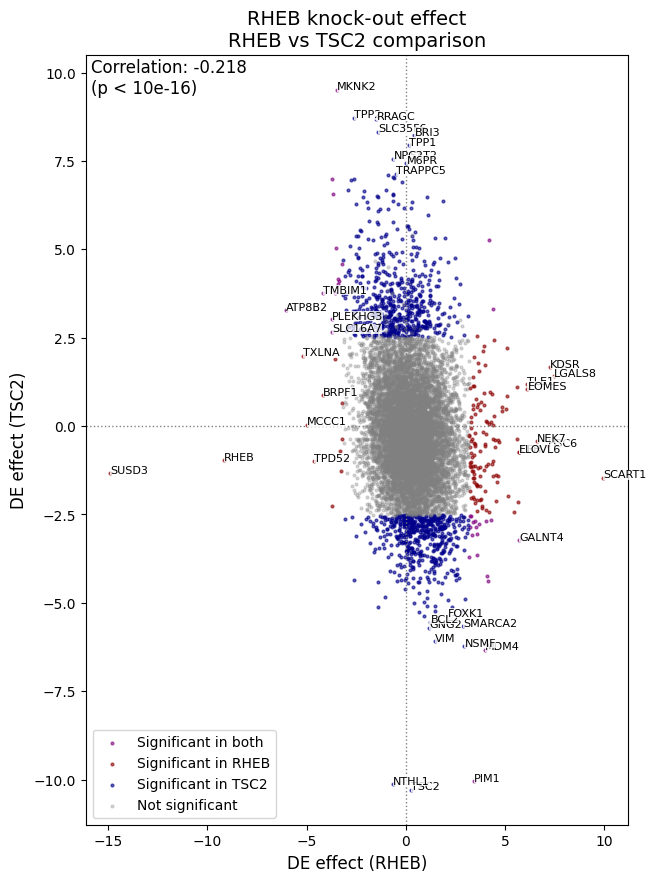

In [45]:
# pseq_effect = get_DE_results_long(adata_de, targets=['RPS6KB1', 'TSC1'])
# pseq_effect = pseq_effect[pseq_effect['culture_condition'] == 'Rest'].dropna()
# pseq_effect.pivot(index=0)
outs = plot_effect_comparison(
    adata_de,
    comparison_params = {'culture_condition':['Rest'], 'target_contrast_gene_name':['RHEB', 'TSC2'], 'stat':['zscore']},
    n_top_genes=10,
    plot_correlation=True,
    axis_label='DE effect',
    figsize=(7, 10),
    # ax=None,
    # annotate_genes=pg[(pg.source=='PI3K') & (pg.padj < 0.1)]['target'].tolist()
    annotate_significant=True
)
outs[2].dropna().corr()

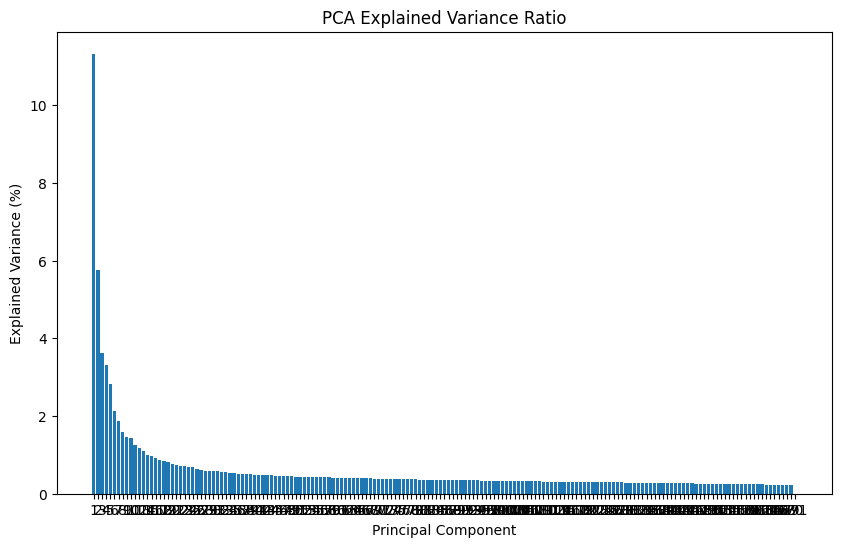

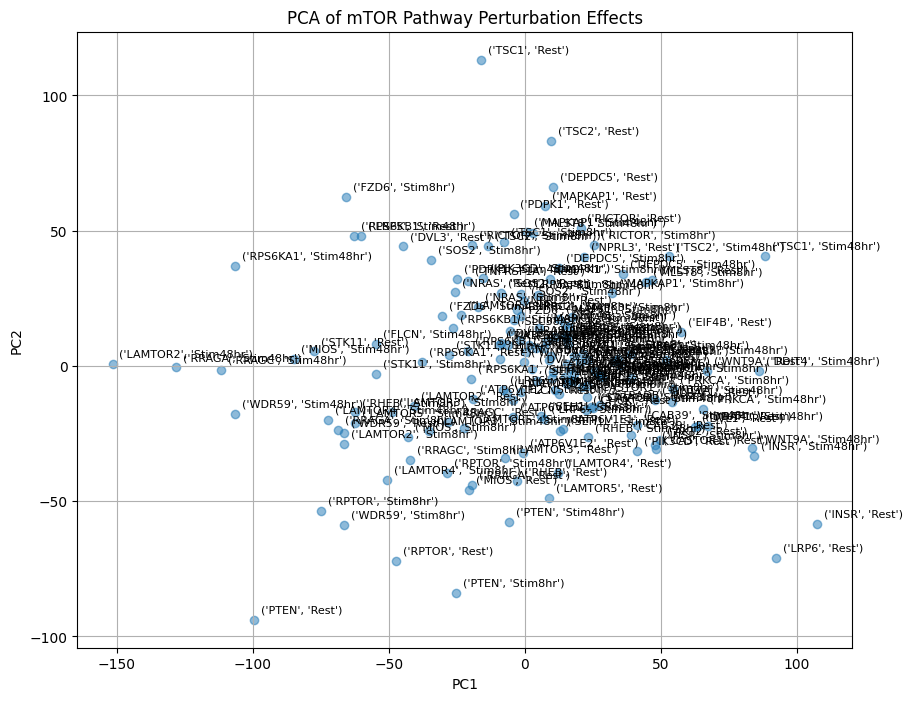

In [93]:
X_perturb_mtor = pseq_effect.pivot(columns=['target_contrast_gene_name', 'culture_condition'], index='gene', values='zscore')
from sklearn.decomposition import PCA

# Run PCA
pca = PCA()
pca_result = pca.fit_transform(X_perturb_mtor.T.fillna(0))
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
    index=X_perturb_mtor.index
)

# Convert to dataframe with original index
pca_df = pd.DataFrame(
    pca_result, 
    index=X_perturb_mtor.columns,
    columns=[f'PC{i+1}' for i in range(pca_result.shape[1])]
)

# Calculate and plot explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_ * 100

plt.figure(figsize=(10,6))
plt.bar(range(1, len(explained_var_ratio) + 1), explained_var_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('PCA Explained Variance Ratio')
plt.xticks(range(1, len(explained_var_ratio) + 1))
plt.show()

plt.figure(figsize=(10,8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)

# Add gene labels for each point
for idx, row in pca_df.iterrows():
    plt.annotate(idx, (row['PC1'], row['PC2']), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=8)

plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('PCA of mTOR Pathway Perturbation Effects')
plt.grid(True)
plt.show()

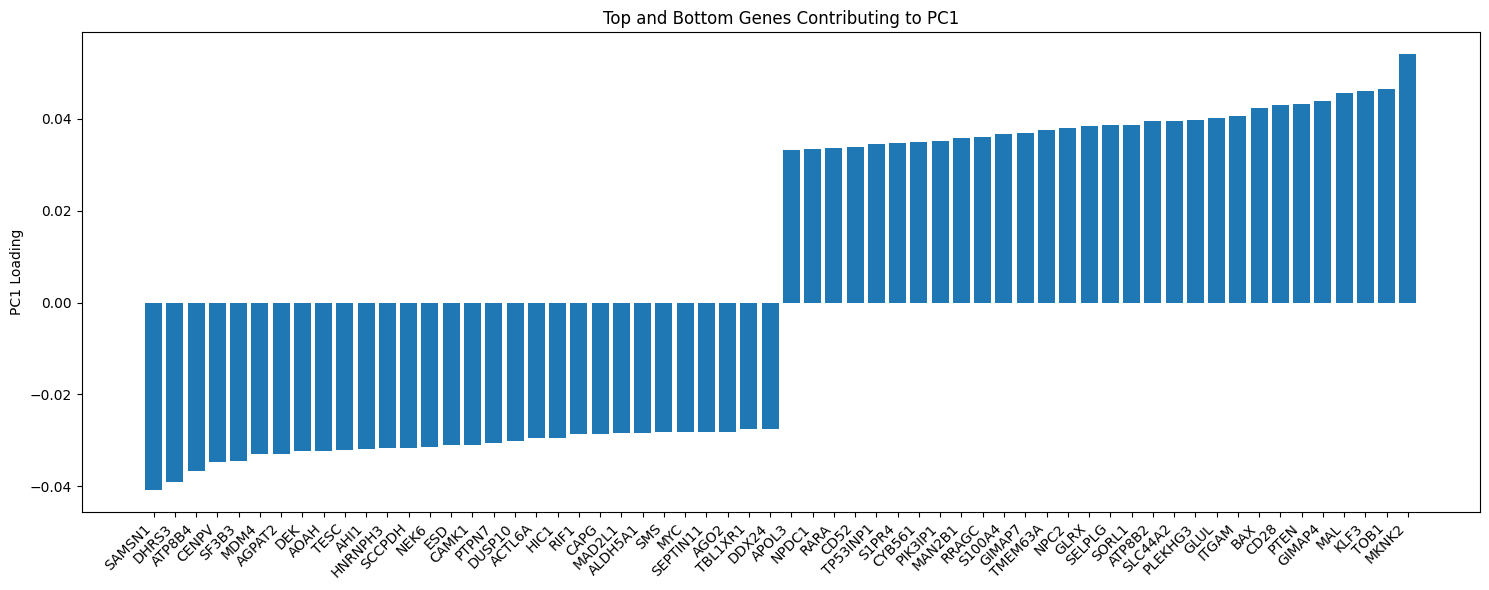

In [94]:
# Sort PC1 loadings and get top/bottom 10 genes
pc1_sorted = loadings['PC2'].sort_values()
top_bottom_genes = pd.concat([pc1_sorted.head(30), pc1_sorted.tail(30)])

# Create bar plot
plt.figure(figsize=(15,6))
plt.bar(range(len(top_bottom_genes)), top_bottom_genes)
plt.xticks(range(len(top_bottom_genes)), top_bottom_genes.index, rotation=45, ha='right')
plt.ylabel('PC1 Loading')
plt.title('Top and Bottom Genes Contributing to PC1')
plt.tight_layout()
plt.show()

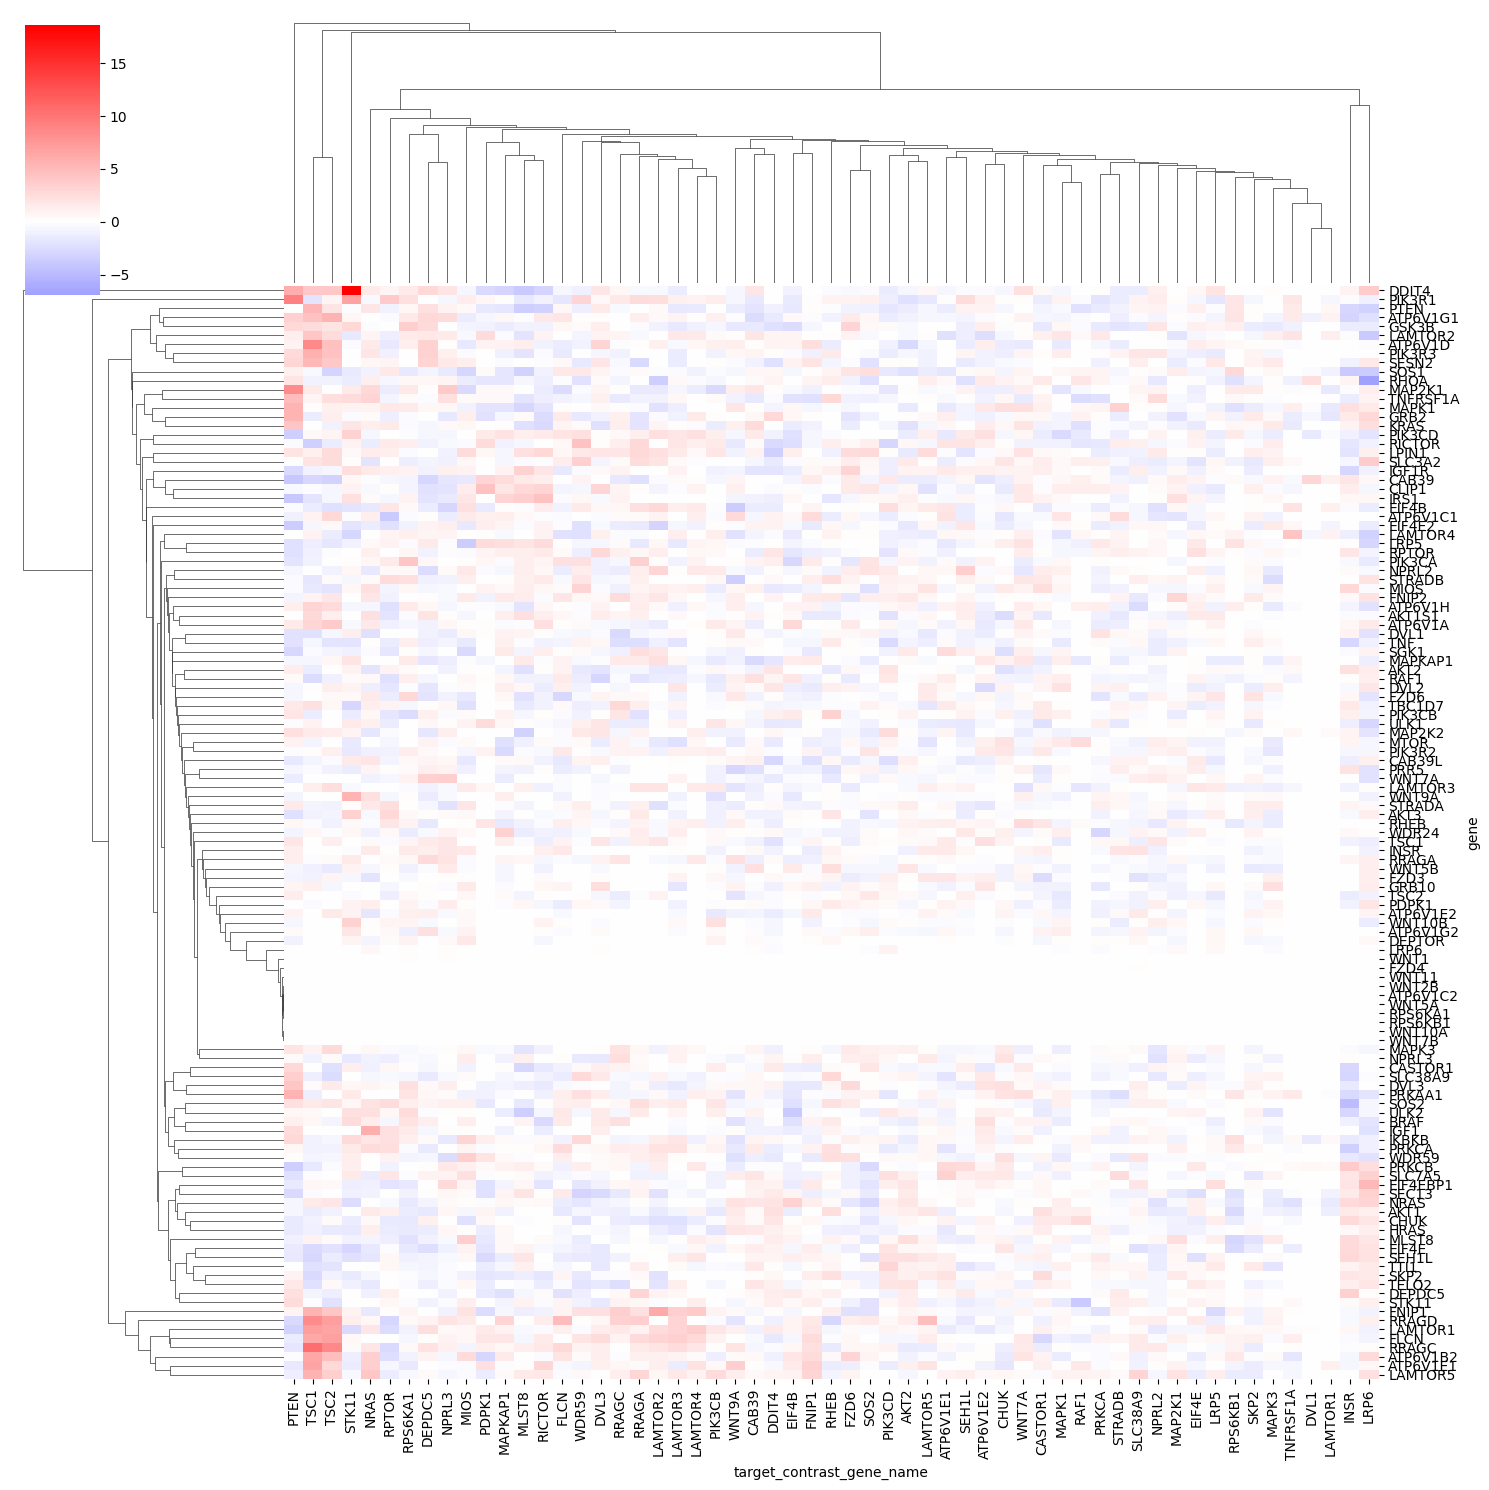

In [42]:
targets = DE_stats[DE_stats['target_name'].isin(KEGG_sets['mTOR signaling pathway']) & (DE_stats.n_total_de_genes > 3)].target_name.unique()
pseq_effect = get_DE_results_long(adata_de[adata_de.obs['culture_condition'] == 'Rest'], genes=KEGG_sets['mTOR signaling pathway'], targets=targets).dropna()
pseq_effect = pseq_effect.pivot(columns='target_contrast_gene_name', index='gene', values='zscore').fillna(0)
for k in pseq_effect.columns:
    pseq_effect.loc[k,k] = 0
# pseq_effect = pseq_effect[pseq_effect.sum(1) > 0]
sns.clustermap(pseq_effect.fillna(0), cmap='bwr', center=0, xticklabels=True, yticklabels=True, 
    figsize=(15,15)
)

In [ ]:
res_df[res_df.gene_name.isin(KEGG_sets['mTOR signaling pathway']) & (res_df.adj_p_value < 0.1)]['gene_name']

baseMean    log_fc     lfcSE      stat        pvalue   adj_p_value  \
601     8.177586  0.020984  0.009028  2.324309  2.010891e-02  7.901844e-02   
840     3.971778  0.029162  0.011716  2.488967  1.281150e-02  5.720343e-02   
1655   22.715725  0.017112  0.006011  2.846863  4.415243e-03  2.585625e-02   
1698    0.494091  0.107902  0.030238  3.568361  3.592217e-04  3.683827e-03   
5427    3.312204  0.066169  0.013649  4.847975  1.247282e-06  3.405643e-05   
5621    1.432806  0.095005  0.017685  5.372079  7.783418e-08  3.046783e-06   
5746    6.335413  0.028578  0.009421  3.033568  2.416801e-03  1.642138e-02   
6088    2.386345 -0.060304  0.014678 -4.108401  3.984075e-05  6.253718e-04   
8680    7.738465  0.031680  0.009047  3.501625  4.624302e-04  4.486728e-03   
9957   24.862218  0.036490  0.008308  4.392289  1.121637e-05  2.214899e-04   
10450  10.420791 -0.021461  0.007271 -2.951491  3.162434e-03  2.008880e-02   
11703   0.282253  0.106188  0.037889  2.802632  5.068745e-03  2.866529e-02   
11706   7.816295  0.102775  0.016530  6.217321  5.057143e-10  3.513523e-08   
13170   2.063461  0.046489  0.015253  3.047857  2.304797e-03  1.580602e-02   
13982  68.249780  0.015432  0.003461  4.458902  8.238045e-06  1.706461e-04   
14642  11.417407  0.030954  0.007678  4.031515  5.541838e-05  8.125988e-04   
14976   2.970174  0.054427  0.012934  4.208193  2.574211e-05  4.413408e-04   
15268   5.518753  0.025205  0.009405  2.679801  7.366584e-03  3.796294e-02   
15343   9.113508  0.020093  0.007959  2.524673  1.158060e-02  5.311509e-02   
15806   1.675691  0.040442  0.017225  2.347898  1.887969e-02  7.569350e-02   
16353   5.044923  0.037153  0.010601  3.504507  4.574536e-04  4.454936e-03   
18186  29.151121  0.046373  0.010738  4.318725  1.569329e-05  2.953901e-04   
19909  16.550635  0.017930  0.007437  2.410911  1.591272e-02  6.705898e-02   
22713   7.996015  0.027134  0.008061  3.366283  7.618842e-04  6.642709e-03   
25863   9.327872  0.033337  0.008078  4.127169  3.672565e-05  5.843518e-04   
26538   1.991301  0.036389  0.015276  2.382104  1.721406e-02  7.082278e-02   
28529   2.864622  0.043504  0.013021  3.341176  8.342433e-04  7.132995e-03   
28609   1.376091  0.056831  0.017437  3.259252  1.117063e-03  8.994800e-03   
29612   6.124985  0.025961  0.009555  2.717045  6.586775e-03  3.485108e-02   
29651  11.980148  0.027570  0.009639  2.860366  4.231527e-03  2.497881e-02   
31040   5.175958 -0.102130  0.016686 -6.120594  9.322709e-10  6.064331e-08   
35437   8.519397 -0.026245  0.008752 -2.998650  2.711787e-03  1.792102e-02   

              variable gene_name  perturbseq_gene contrast    zscore  \
601    ENSG00000117676   RPS6KA1            False      age  2.324309   
840    ENSG00000116954     RRAGC             True      age  2.488967   
1655   ENSG00000134248   LAMTOR5             True      age  2.846863   
1698   ENSG00000134245     WNT2B             True      age  3.568361   
5427   ENSG00000082146    STRADB             True      age  4.847975   
5621   ENSG00000135925    WNT10A             True      age  5.372079   
5746   ENSG00000135932     CAB39             True      age  3.033568   
6088   ENSG00000154764     WNT7A             True      age -4.108401   
8680   ENSG00000151247     EIF4E             True      age  3.501625   
9957   ENSG00000145675    PIK3R1             True      age  4.392289   
10450  ENSG00000217128     FNIP1             True      age -2.951491   
11703  ENSG00000213760  ATP6V1G2             True      age  2.802632   
11706  ENSG00000232810       TNF             True      age  6.217321   
13170  ENSG00000164654      MIOS             True      age  3.047857   
13982  ENSG00000188186   LAMTOR4             True      age  4.458902   
14642  ENSG00000106615      RHEB             True      age  4.031515   
14976  ENSG00000147416  ATP6V1B2             True      age  4.208193   
15268  ENSG00000104365     IKBKB             True      age  2.679801   
15343  ENSG00000047249   ATP6V1H             True      age  2.524

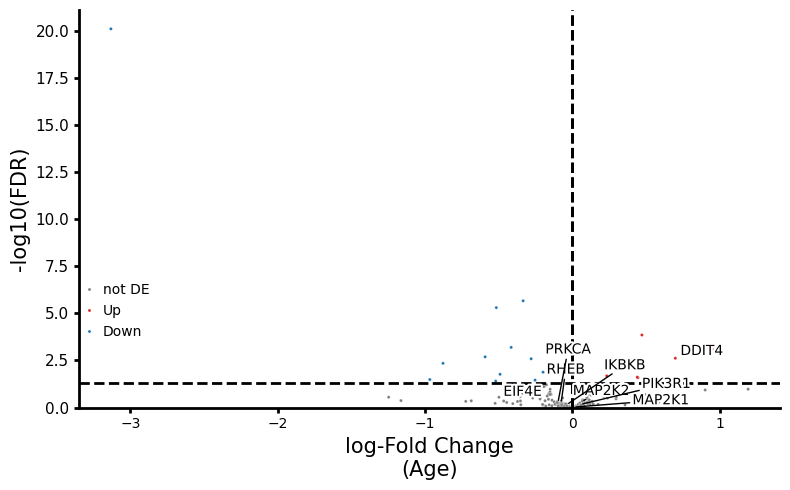

In [ ]:
predicted_effects_on_pathway = pg[(pg.source=='PI3K') & (pg.padj < 0.1) & (pg.target.isin(KEGG_sets['PI3K-Akt signaling pathway']))].sort_values('weight', ascending=False)
pseq_effect = get_DE_results_long(adata_de[adata_de.obs['culture_condition'] == 'Rest'], targets=['TSC2']).dropna()

onek1k_design = f"~ male + age_cat"
model = pertpy.tl.PyDESeq2(pbulk_adata, design=onek1k_design)

fig = model.plot_volcano(
    # res_df[res_df.gene_name.isin(KEGG_sets['mTOR signaling pathway'])], 
    pseq_effect[pseq_effect.gene_name.isin(KEGG_sets['PI3K-Akt signaling pathway'])], 
    log2fc_thresh=0, 
    return_fig=True, 
    to_label = res_df[res_df.gene_name.isin(KEGG_sets['mTOR signaling pathway']) & (res_df.adj_p_value < 0.05)]['gene_name'],
    symbol_col='gene_name',
    figsize=(8, 5),  # Increased figure size
    s=5,
    legend_pos = (0.11,0.33),
    y_label = '-log10(FDR)', x_label='log-Fold Change\n(Age)'
    )
fig.tight_layout()  
fig.show()  

In [34]:
enrichr_results_aging_up

Gene_set                                               Term   Overlap  \
415   gs_ind_0       REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM   169/779   
1274  gs_ind_0           REACTOME_RNA_POLYMERASE_II_TRANSCRIPTION  231/1355   
1080  gs_ind_0   REACTOME_POST_TRANSLATIONAL_PROTEIN_MODIFICATION  238/1484   
727   gs_ind_0                        REACTOME_INFECTIOUS_DISEASE  190/1065   
1640  gs_ind_0                  REACTOME_VIRAL_INFECTION_PATHWAYS   164/874   
...        ...                                                ...       ...   
1110  gs_ind_0  REACTOME_PROTEIN_PROTEIN_INTERACTIONS_AT_SYNAPSES      1/87   
380   gs_ind_0                        REACTOME_COMPLEMENT_CASCADE     2/114   
108   gs_ind_0                        KEGG_OLFACTORY_TRANSDUCTION     2/384   
800   gs_ind_0                            REACTOME_KERATINIZATION     3/217   
1338  gs_ind_0                        REACTOME_SENSORY_PERCEPTION    12/611   

           P-value  Adjusted P-value  Odds Ratio  Combined Score  \
415   5.501406e-42      9.148838e-39    3.977385    3.778658e+02   
1274  7.489002e-39      6.227105e-36    2.983090    2.618776e+02   
1080  1.152560e-35      6.389022e-33    2.770759    2.229034e+02   
727   1.125756e-34      4.680331e-32    3.120481    2.439263e+02   
1640  1.158507e-32      3.853193e-30    3.299793    2.426522e+02   
...            ...               ...         ...             ...   
1110  9.979257e-01      1.000000e+00    0.235380    4.887581e-04   
380   9.971405e-01      1.000000e+00    0.301525    8.634412e-04   
108   1.000000e+00      1.000000e+00    0.087979    3.325720e-12   
800   9.999713e-01      1.000000e+00    0.220823    6.328986e-06   
1338  1.000000e+00      1.000000e+00    0.279977    1.555046e-09   

                                                  Genes  
415   MX2;TRIM14;IFITM2;IL23A;MX1;GBP4;EIF4E;MTAP;ED...  
1274  ACTL6A;SRSF2;ZNF230;BCL2L14;ZNF302;H2BC15;RPA3...  
1080  ACTL6A;PSMB10;PIGM;SENP5;H2BC15;CBX5;GPAA1;ETF...  
727   RPL36AL;H2BC15;FXYD1;RPS4Y1;PATJ;CD4;RPL35;OST...  
1640  RPL36AL;H2BC15;FXYD1;RPS4Y1;PATJ;CD4;RPL35;OST...  
...                                                 ...  
1110                                            PPFIBP1  
380                                            CLU;CD46  
108                                         OR4D1;CALM2  
800                                   KRT72;CAPN1;KRT18  
1338  EPS8L2;CAPZA2;CAPZA1;MYO1C;TWF2;PRKCA;SYP;DHRS...  

[1663 rows x 8 columns]

Text(0.5, 1.0, 'Aging vs TSC2 KD Effects on mTOR Pathway Genes\nr = -0.21')

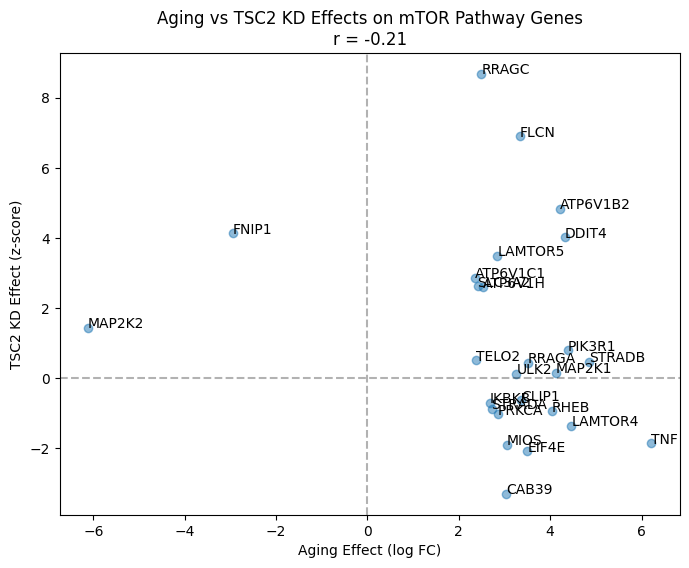

In [33]:
# Get aging and TSC2 KD effects
aging_effect = res_df[res_df.gene_name.isin(KEGG_sets['mTOR signaling pathway']) & (res_df.adj_p_value < 0.1)]
pseq_effect = get_DE_results_long(adata_de[adata_de.obs['culture_condition'] == 'Rest'], targets=['TSC2']).dropna()
pseq_effect = pseq_effect[pseq_effect.gene_name.isin(KEGG_sets['mTOR signaling pathway'])]

# Get genes present in both datasets
common_genes = np.intersect1d(aging_effect.gene_name, pseq_effect.gene_name)
aging_effect = aging_effect.set_index('gene_name').loc[common_genes].reset_index()
pseq_effect = pseq_effect.set_index('gene_name').loc[common_genes].reset_index()

# Calculate correlation coefficient
corr = np.corrcoef(aging_effect['zscore'], pseq_effect['zscore'])[0,1]

# Create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(aging_effect['zscore'], pseq_effect['zscore'], alpha=0.5)
plt.xlabel('Aging Effect (log FC)')
plt.ylabel('TSC2 KD Effect (z-score)')

# Add gene labels
for i, gene in enumerate(aging_effect['gene_name']):
    plt.annotate(gene, (aging_effect['zscore'].iloc[i], pseq_effect['zscore'].iloc[i]))

plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.title(f'Aging vs TSC2 KD Effects on mTOR Pathway Genes\nr = {corr:.2f}')

In [90]:
pseq_effect

index      gene    log_fc    zscore   adj_p_value  \
980    ENSG00000103197_Rest  ATP6V1B2  0.286823  4.825146  1.241587e-04   
981    ENSG00000103197_Rest  ATP6V1C1  0.203067  2.857229  5.328491e-02   
990    ENSG00000103197_Rest   ATP6V1H  0.151099  2.581841  8.904745e-02   
1529   ENSG00000103197_Rest     CAB39 -0.188555 -3.307010  1.857779e-02   
2354   ENSG00000103197_Rest     CLIP1 -0.044147 -0.636922  7.618505e-01   
2984   ENSG00000103197_Rest     DDIT4  0.699271  4.016497  2.407399e-03   
3586   ENSG00000103197_Rest     EIF4E -0.160297 -2.097627  1.894884e-01   
4234   ENSG00000103197_Rest      FLCN  0.454403  6.898229  2.500056e-09   
4269   ENSG00000103197_Rest     FNIP1  0.253421  4.128336  1.709270e-03   
5483   ENSG00000103197_Rest     IKBKB -0.040548 -0.713718  7.307239e-01   
6189   ENSG00000103197_Rest   LAMTOR4 -0.060851 -1.369830  4.402889e-01   
6190   ENSG00000103197_Rest   LAMTOR5  0.206438  3.479403  1.187074e-02   
6630   ENSG00000103197_Rest    MAP2K1  0.006878  0.147083  9.533424e-01   
6631   ENSG00000103197_Rest    MAP2K2  0.077959  1.427408  4.187868e-01   
6970   ENSG00000103197_Rest      MIOS -0.203118 -1.917726  2.396632e-01   
8594   ENSG00000103197_Rest    PIK3R1  0.051628  0.790193  6.975644e-01   
9094   ENSG00000103197_Rest     PRKCA -0.098552 -1.035440  5.863543e-01   
9786   ENSG00000103197_Rest      RHEB -0.076896 -0.959902  6.229120e-01   
9998   ENSG00000103197_Rest     RRAGA  0.035322  0.437221  8.434034e-01   
10000  ENSG00000103197_Rest     RRAGC  0.547261  8.679008  6.318569e-15   
10755  ENSG00000103197_Rest    SLC3A2  0.204662  2.614592  8.333180e-02   
11376  ENSG00000103197_Rest    STRADA -0.101451 -0.883539  6.563023e-01   
11377  ENSG00000103197_Rest    STRADB  0.060414  0.453617  8.353269e-01   
11725  ENSG00000103197_Rest     TELO2  0.055987  0.501425  8.171071e-01   
12186  ENSG00000103197_Rest       TNF -0.343021 -1.864545  2.570707e-01   
12800  ENSG00000103197_Rest      ULK2  0.021621  0.122872  9.628517e-01   

       significant gene_name culture_condition  target_contrast  \
980           True  ATP6V1B2              Rest  ENSG00000103197   
981           True  ATP6V1C1              Rest  ENSG00000103197   
990           True   ATP6V1H              Rest  ENSG00000103197   
1529          True     CAB39              Rest  ENSG00000103197   
2354         False     CLIP1              Rest  ENSG00000103197   
2984          True     DDIT4              Rest  ENSG00000103197   
3586         False     EIF4E              Rest  ENSG00000103197   
4234          True      FLCN              Rest  ENSG00000103197   
4269          True     FNIP1              Rest  ENSG00000103197   
5483         False     IKBKB              Rest  ENSG00000103197   
6189         False   LAMTOR4              Rest  ENSG00000103197   
6190          True   LAMTOR5              Rest  ENSG00000103197   
6630         False    MAP2K1              Rest  ENSG00000103197   
6631         False    MAP2K2              Rest  ENSG00000103197   
6970         False      MIOS              Rest  ENSG00000103197   
8594         False    PIK3R1              Rest  ENSG00000103197   
9094         False     PRKCA              Rest  ENSG00000103197   
9786         False      RHEB              Rest  ENSG00000103197   
9998         False     RRAGA              Rest  ENSG00000103197   
10000         True     RRAGC              Rest  ENSG00000103197   
10755         True    SLC3A2              Rest  ENSG00000103197   
11376        False    STRADA              Rest  ENSG00000103197   
11377        False    STRADB              Rest  ENSG00000103197   
11725        False     TELO2              Rest  ENSG00000103197   
12186        False       TNF              Rest  ENSG00000103197   
12800        False      ULK2              Rest  ENSG00000103197   

      target_contrast_gene_name  
980                        TSC2  
981                        TSC2  
990                        TSC2  
1529                       TSC2  
2354            

In [139]:
# pg[(pg.source == 'PI3K') & (pg.target.isin(KEGG_sets['PI3K-Akt signaling pathway']))]

KEGG pathway to interaction (https://github.com/everest-castaneda/knext):
```
knext genes hsa04150.xml --names
knext convert hsa hsa04150.tsv
```

In [25]:
gene_table = pd.read_table('mart_export.txt')
KEGG_interactions = pd.read_table('ncbi_hsa04150.tsv')
all_gs = np.union1d(KEGG_interactions['entry1'].unique(), KEGG_interactions['entry2'].unique())
id_to_name = gene_table[gene_table['NCBI gene (formerly Entrezgene) ID'].isin(all_gs)].rename(columns={'NCBI gene (formerly Entrezgene) ID':'entry'})[['entry','Gene name']]

KEGG_interactions = pd.merge(KEGG_interactions, id_to_name.rename(columns={'Gene name':'gene_name_1'}), how='left', left_on='entry1', right_on='entry').drop('entry', axis=1)
KEGG_interactions = pd.merge(KEGG_interactions, id_to_name.rename(columns={'Gene name':'gene_name_2'}), how='left', left_on='entry2', right_on='entry').drop('entry', axis=1)
KEGG_interactions['gene_name_1'] = np.where(KEGG_interactions.entry1 == 101927180, 'ATP6V1FP2', KEGG_interactions['gene_name_1'])

# KEGG_interactions = KEGG_interactions.drop(['entry1', 'entry2'], axis=1)
KEGG_interactions['type'] = KEGG_interactions['type'].str.split(",").str[0]
KEGG_interactions['value'] = KEGG_interactions['value'].str.split(",").str[0]
KEGG_interactions['name'] = KEGG_interactions['name'].str.split(",").str[0]
KEGG_interactions = KEGG_interactions[KEGG_interactions['type'] == 'PPrel']

# Create adjacency matrix from interactions
KEGG_interactions_mat = KEGG_interactions.drop_duplicates().pivot(index='gene_name_1', columns='gene_name_2', values='name')
# Convert activation to 1, inhibition to -1, others to 0
KEGG_interactions_mat = KEGG_interactions_mat.applymap(lambda x: 1 if x == 'activation' else (-1 if x == 'inhibition' else 0))

# Fill NaN with 0
KEGG_interactions_mat = KEGG_interactions_mat.fillna(0)
# Get all unique genes
all_genes = sorted(set(KEGG_interactions_mat.index) | set(KEGG_interactions_mat.columns))

# Create square matrix with same genes in rows and columns
square_mat = pd.DataFrame(0, index=all_genes, columns=all_genes)

# Fill in the known interactions
for i in KEGG_interactions_mat.index:
    for j in KEGG_interactions_mat.columns:
        if KEGG_interactions_mat.loc[i,j] == 1:
            square_mat.loc[i,j] = 1
            
KEGG_interactions_mat = square_mat
KEGG_interactions_mat

def compute_signed_effects_matrix_powers(signed_matrix, max_path_length=5, damping=0.8):
    """
    Compute overall effects using matrix powers approach
    
    Args:
        signed_matrix: pandas DataFrame with 1 (activation), -1 (inhibition), 0 (no interaction)
        max_path_length: maximum path length to consider
        damping: damping factor for longer paths (0-1)
    
    Returns:
        pandas DataFrame with overall effect scores
    """
    A = signed_matrix.values.astype(float)
    n = A.shape[0]
    
    # Initialize overall effects matrix
    total_effects = np.zeros_like(A)
    
    # Current power of the matrix
    A_power = np.eye(n)  # A^0 = Identity
    
    for k in range(1, max_path_length + 1):
        A_power = A_power @ A  # A^k
        
        # Apply damping for longer paths
        damped_effects = A_power * (damping ** (k - 1))
        total_effects += damped_effects
    
    # Convert back to DataFrame
    effects_df = pd.DataFrame(
        total_effects,
        index=signed_matrix.index,
        columns=signed_matrix.columns
    )
    
    return effects_df

compute_signed_effects_matrix_powers(KEGG_interactions_mat).index

# KEGG_interactions_mat = (~KEGG_interactions_mat.isna()).astype(int)



Index(['AKT1', 'AKT1S1', 'AKT2', 'AKT3', 'ATP6V1A', 'ATP6V1B1', 'ATP6V1B2',
       'ATP6V1C1', 'ATP6V1C2', 'ATP6V1D',
       ...
       'SOS1', 'SOS2', 'TELO2', 'TNF', 'TNFRSF1A', 'TTI1', 'ULK1', 'ULK2',
       'WDR24', 'WDR59'],
      dtype='object', length=128)

In [29]:
KEGG_interactions[(KEGG_interactions['gene_name_1'] == 'MTOR') & (KEGG_interactions.name == 'activation')]['gene_name_2'].tolist()

['LPIN1',
 'GRB10',
 'RHOA',
 'PRKCA',
 'PRKCB',
 'PRKCG',
 'RPS6KB1',
 'RPS6KB2',
 'CLIP1',
 'SGK1',
 'LPIN3',
 'LPIN2']

In [209]:
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix

def compute_shortest_paths_scipy(adjacency_matrix):
    """
    Compute shortest paths using SciPy (faster for large networks)
    
    Args:
        adjacency_matrix: pandas DataFrame with 0/1 values
    
    Returns:
        pandas DataFrame with shortest path distances
    """
    # Convert to sparse matrix for efficiency
    sparse_matrix = csr_matrix(adjacency_matrix.values)
    
    # Compute shortest paths (Floyd-Warshall algorithm)
    distances = shortest_path(sparse_matrix, directed=True, return_predecessors=False)
    
    # Convert back to DataFrame
    distance_df = pd.DataFrame(
        distances, 
        index=adjacency_matrix.index, 
        columns=adjacency_matrix.columns
    )
    
    return distance_df

shortest_paths_mat = compute_shortest_paths_scipy(KEGG_interactions_mat)
shortest_paths_long = shortest_paths_mat.reset_index().melt(id_vars='index').sort_values('value')
shortest_paths_long.columns = ['gene_name_1', 'gene_name_2', 'shortest_path']
shortest_paths_long = shortest_paths_long[shortest_paths_long['shortest_path'] != 0]
shortest_paths_long.sort_values('shortest_path')

gene_name_1 gene_name_2  shortest_path
2688         AKT1        CHUK            1.0
7823     ATP6V1G2     LAMTOR5            1.0
7822     ATP6V1G1     LAMTOR5            1.0
7821    ATP6V1FP2     LAMTOR5            1.0
7820      ATP6V1F     LAMTOR5            1.0
...           ...         ...            ...
16378    TNFRSF1A       WDR59            inf
16379        TTI1       WDR59            inf
16380        ULK1       WDR59            inf
16381        ULK2       WDR59            inf
16382       WDR24       WDR59            inf

[16256 rows x 3 columns]

entry1  entry2   type value                 name gene_name_1  \
0        10000    1147  PPrel   -->           activation        AKT3   
1        10000    1147  PPrel   -->           activation        AKT3   
2        10000   84335  PPrel   --|           inhibition        AKT3   
3        10000   84335  PPrel   --|           inhibition        AKT3   
4    101927180   10542  PPrel   -->           activation   ATP6V1FP2   
..         ...     ...    ...   ...                  ...         ...   
307       9550    8649  PPrel   -->           activation    ATP6V1G1   
308      96459  201163  PPrel   ---  binding/association       FNIP1   
309       9681   10325  PPrel   --|           inhibition      DEPDC5   
310       9681   10670  PPrel   --|           inhibition      DEPDC5   
311       9894    9675  PPrel   ---  binding/association       TELO2   

    gene_name_2  
0          CHUK  
1          CHUK  
2        AKT1S1  
3        AKT1S1  
4       LAMTOR5  
..          ...  
307     LAMTOR3  
308        FLCN  
309       RRAGB  
310       RRAGA  
311        TTI1  

[312 rows x 7 columns]

In [215]:
corr_matrix.index

CategoricalIndex(['AKT2', 'ATP6V1E1', 'ATP6V1E2', 'CAB39', 'CASTOR1', 'CHUK',
                  'DDIT4', 'DEPDC5', 'DVL1', 'DVL3', 'EIF4B', 'EIF4E', 'FLCN',
                  'FNIP1', 'FZD6', 'INSR', 'LAMTOR1', 'LAMTOR2', 'LAMTOR3',
                  'LAMTOR4', 'LAMTOR5', 'LRP5', 'LRP6', 'MAP2K1', 'MAPK1',
                  'MAPK3', 'MAPKAP1', 'MIOS', 'MLST8', 'NPRL2', 'NPRL3',
                  'NRAS', 'PDPK1', 'PIK3CB', 'PIK3CD', 'PRKCA', 'PTEN', 'RAF1',
                  'RHEB', 'RICTOR', 'RPS6KA1', 'RPS6KB1', 'RPTOR', 'RRAGA',
                  'RRAGC', 'SEH1L', 'SKP2', 'SLC38A9', 'SOS2', 'STK11',
                  'STRADB', 'TNFRSF1A', 'TSC1', 'TSC2', 'WDR59', 'WNT7A',
                  'WNT9A'],
                 categories=['AKT2', 'ATP6V1E1', 'ATP6V1E2', 'CAB39', ..., 'TSC2', 'WDR59', 'WNT7A', 'WNT9A'], ordered=False, dtype='category', name='gene_name_1')

In [1]:
feedback_loop = ['TSC1', 'TSC2', 'RPTOR', 'RPS6KB1', 'PIK3CB', 'PIK3CD']
sns.heatmap(corr_matrix.loc[feedback_loop, feedback_loop], cmap='bwr', center=0, annot=True)

NameError: name 'sns' is not defined

In [223]:
DE_stats[DE_stats['target_name'].isin(feedback_loop)]

target_contrast target_name condition  n_cells_target  n_up_genes  \
2100   ENSG00000051382      PIK3CB      Rest           918.0           0   
5169   ENSG00000141564       RPTOR      Rest           283.0         458   
7098   ENSG00000103197        TSC2      Rest           631.0         577   
11853  ENSG00000108443     RPS6KB1      Rest           420.0         176   
16270  ENSG00000165699        TSC1      Rest           492.0         748   
31655  ENSG00000171608      PIK3CD      Rest           499.0           6   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
2100              4                 4             -9.420258   
5169            181               639             -3.109146   
7098            524              1101            -10.287862   
11853           320               496                   NaN   
16270           928              1676             -9.057551   
31655             2                 8            -11.787265   

       ontarget_significant    baseMean  offtarget_flag  \
2100                   True   11.868079           False   
5169                   True   61.690896           False   
7098                   True   16.242152            True   
11853                 False         NaN           False   
16270                  True   17.133781           False   
31655                  True  334.537446           False   

      n_total_genes_category ontarget_effect_category  
2100           2-10 DE genes             on-target KD  
5169            >10 DE genes             on-target KD  
7098            >10 DE genes             on-target KD  
11853           >10 DE genes          no on-target KD  
16270           >10 DE genes             on-target KD  
31655          2-10 DE genes             on-target KD

<Axes: xlabel='name', ylabel='correlation'>

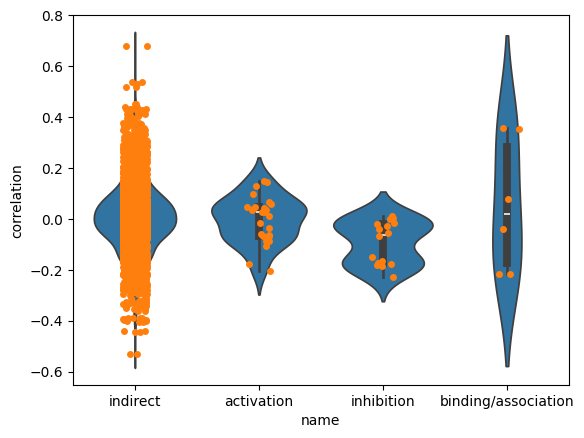

In [175]:
corr_matrix.index.name = 'gene_name_1'
corr_matrix.columns.name = 'gene_name_2'
corr_matrix_long = corr_matrix.reset_index().melt(id_vars='gene_name_1', value_name='correlation')

corr_matrix_long = pd.merge(corr_matrix_long, KEGG_interactions[['gene_name_1', 'gene_name_2', 'name']], how='left' )
corr_matrix_long = corr_matrix_long[corr_matrix_long['correlation'] != 1]
corr_matrix_long['name'] = corr_matrix_long['name'].fillna('indirect')

sns.violinplot(data=corr_matrix_long, x='name', y='correlation')
sns.stripplot(data=corr_matrix_long, x='name', y='correlation')

In [23]:
network_df.loc['TSC2']

KeyError: 'TSC2'

In [ ]:
# pseq_effect[pseq_effect['gene'].isin(down_genes)].sort_values("adj_p_value")[0:30]

index      gene    log_fc    zscore  adj_p_value  \
9094   ENSG00000141564_Rest     PRKCA  0.290376  2.432364     0.170555   
3589   ENSG00000141564_Rest  EIF4EBP1 -0.424020 -1.895066     0.345243   
3585   ENSG00000141564_Rest     EIF4B  0.160885  1.827782     0.370288   
10423  ENSG00000141564_Rest      SGK1 -0.603103 -1.772149     0.392218   
12799  ENSG00000141564_Rest      ULK1 -0.238301 -1.289362     0.588735   
6387   ENSG00000141564_Rest     LPIN1  0.159477  1.288192     0.589621   
9789   ENSG00000141564_Rest      RHOA -0.038936 -0.630098     0.861829   
4834   ENSG00000141564_Rest     GRB10 -0.371522 -0.571437     0.882198   
2354   ENSG00000141564_Rest     CLIP1  0.017220  0.170475     0.975920   

       significant gene_name culture_condition  target_contrast  \
9094         False     PRKCA              Rest  ENSG00000141564   
3589         False  EIF4EBP1              Rest  ENSG00000141564   
3585         False     EIF4B              Rest  ENSG00000141564   
10423        False      SGK1              Rest  ENSG00000141564   
12799        False      ULK1              Rest  ENSG00000141564   
6387         False     LPIN1              Rest  ENSG00000141564   
9789         False      RHOA              Rest  ENSG00000141564   
4834         False     GRB10              Rest  ENSG00000141564   
2354         False     CLIP1              Rest  ENSG00000141564   

      target_contrast_gene_name       age  
9094                      RPTOR  4.979769  
3589                      RPTOR -2.946158  
3585                      RPTOR       NaN  
10423                     RPTOR       NaN  
12799                     RPTOR       NaN  
6387                      RPTOR       NaN  
9789                      RPTOR       NaN  
4834                      RPTOR       NaN  
2354                      RPTOR  4.144659

### Plot DE effects of predicted regulators

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

st = 'age'
top_quant = 0.01
n_top = 50
alpha = 0.01
c = "Rest"
ct = 'CD4T'
p2t_model = comparison_results[f"{ct}_{c}"][0]

# Get top DE genes for input signature
train_df = train_signatures[ct]
train_df['contrast'] = ct

# Get target state values
state_results_df = train_df.reset_index()
signature_effect_size = state_results_df[(state_results_df['adj_p_value'] < alpha) & 
                                       (abs(state_results_df['zscore']) > 6)].sort_values('zscore')
signature_gs = signature_effect_size.gene_name.tolist()
len(signature_gs)

# Get top x% of coefficients by absolute value
n = len(p2t_model.get_coefs()['coef_mean'])
st_coefs = p2t_model.get_coefs()
abs_coefs = st_coefs['coef_mean'].abs()
# top_abs_coefs = abs_coefs.nlargest(int(n * top_quant))
top_abs_coefs = abs_coefs.nlargest(n_top)
top_regs = st_coefs['coef_mean'][top_abs_coefs.index]
predicted_effect_size = top_regs.sort_values(ascending=False)
predicted_regulators = predicted_effect_size.index.tolist()
predicted_regulators = [x.replace(f"_{c}", '') for x in predicted_regulators]
predicted_effect_size.index = predicted_regulators

# Get DE results and pivot to wide format
long_de_results = get_DE_results_long(adata_de, targets=predicted_regulators, genes=signature_gs, gene_id_col='gene_name')
long_de_results = long_de_results[long_de_results['culture_condition'] == c].copy()
wide_de_results = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='zscore')
wide_de_results_signif = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='adj_p_value')

# Create a mask for diagonal values and low zscore values
mask = pd.DataFrame(False, index=wide_de_results.index, columns=wide_de_results.columns)
for idx in wide_de_results.index:
    if idx in wide_de_results.columns:
        mask.loc[idx, idx] = True
# Add mask for abs zscore < 1
mask = mask | (wide_de_results.abs() < 1)
wide_de_results = wide_de_results.mask(mask, 0)
wide_de_results = wide_de_results.T

# Define axis labels
wide_de_results.index.name = 'Regulators (CRISPRi targets)'
wide_de_results.columns.name = f'{st} signature genes ({alpha*100}% FDR)'
wide_de_results = wide_de_results.dropna(axis=1)

<Figure size 640x480 with 0 Axes>

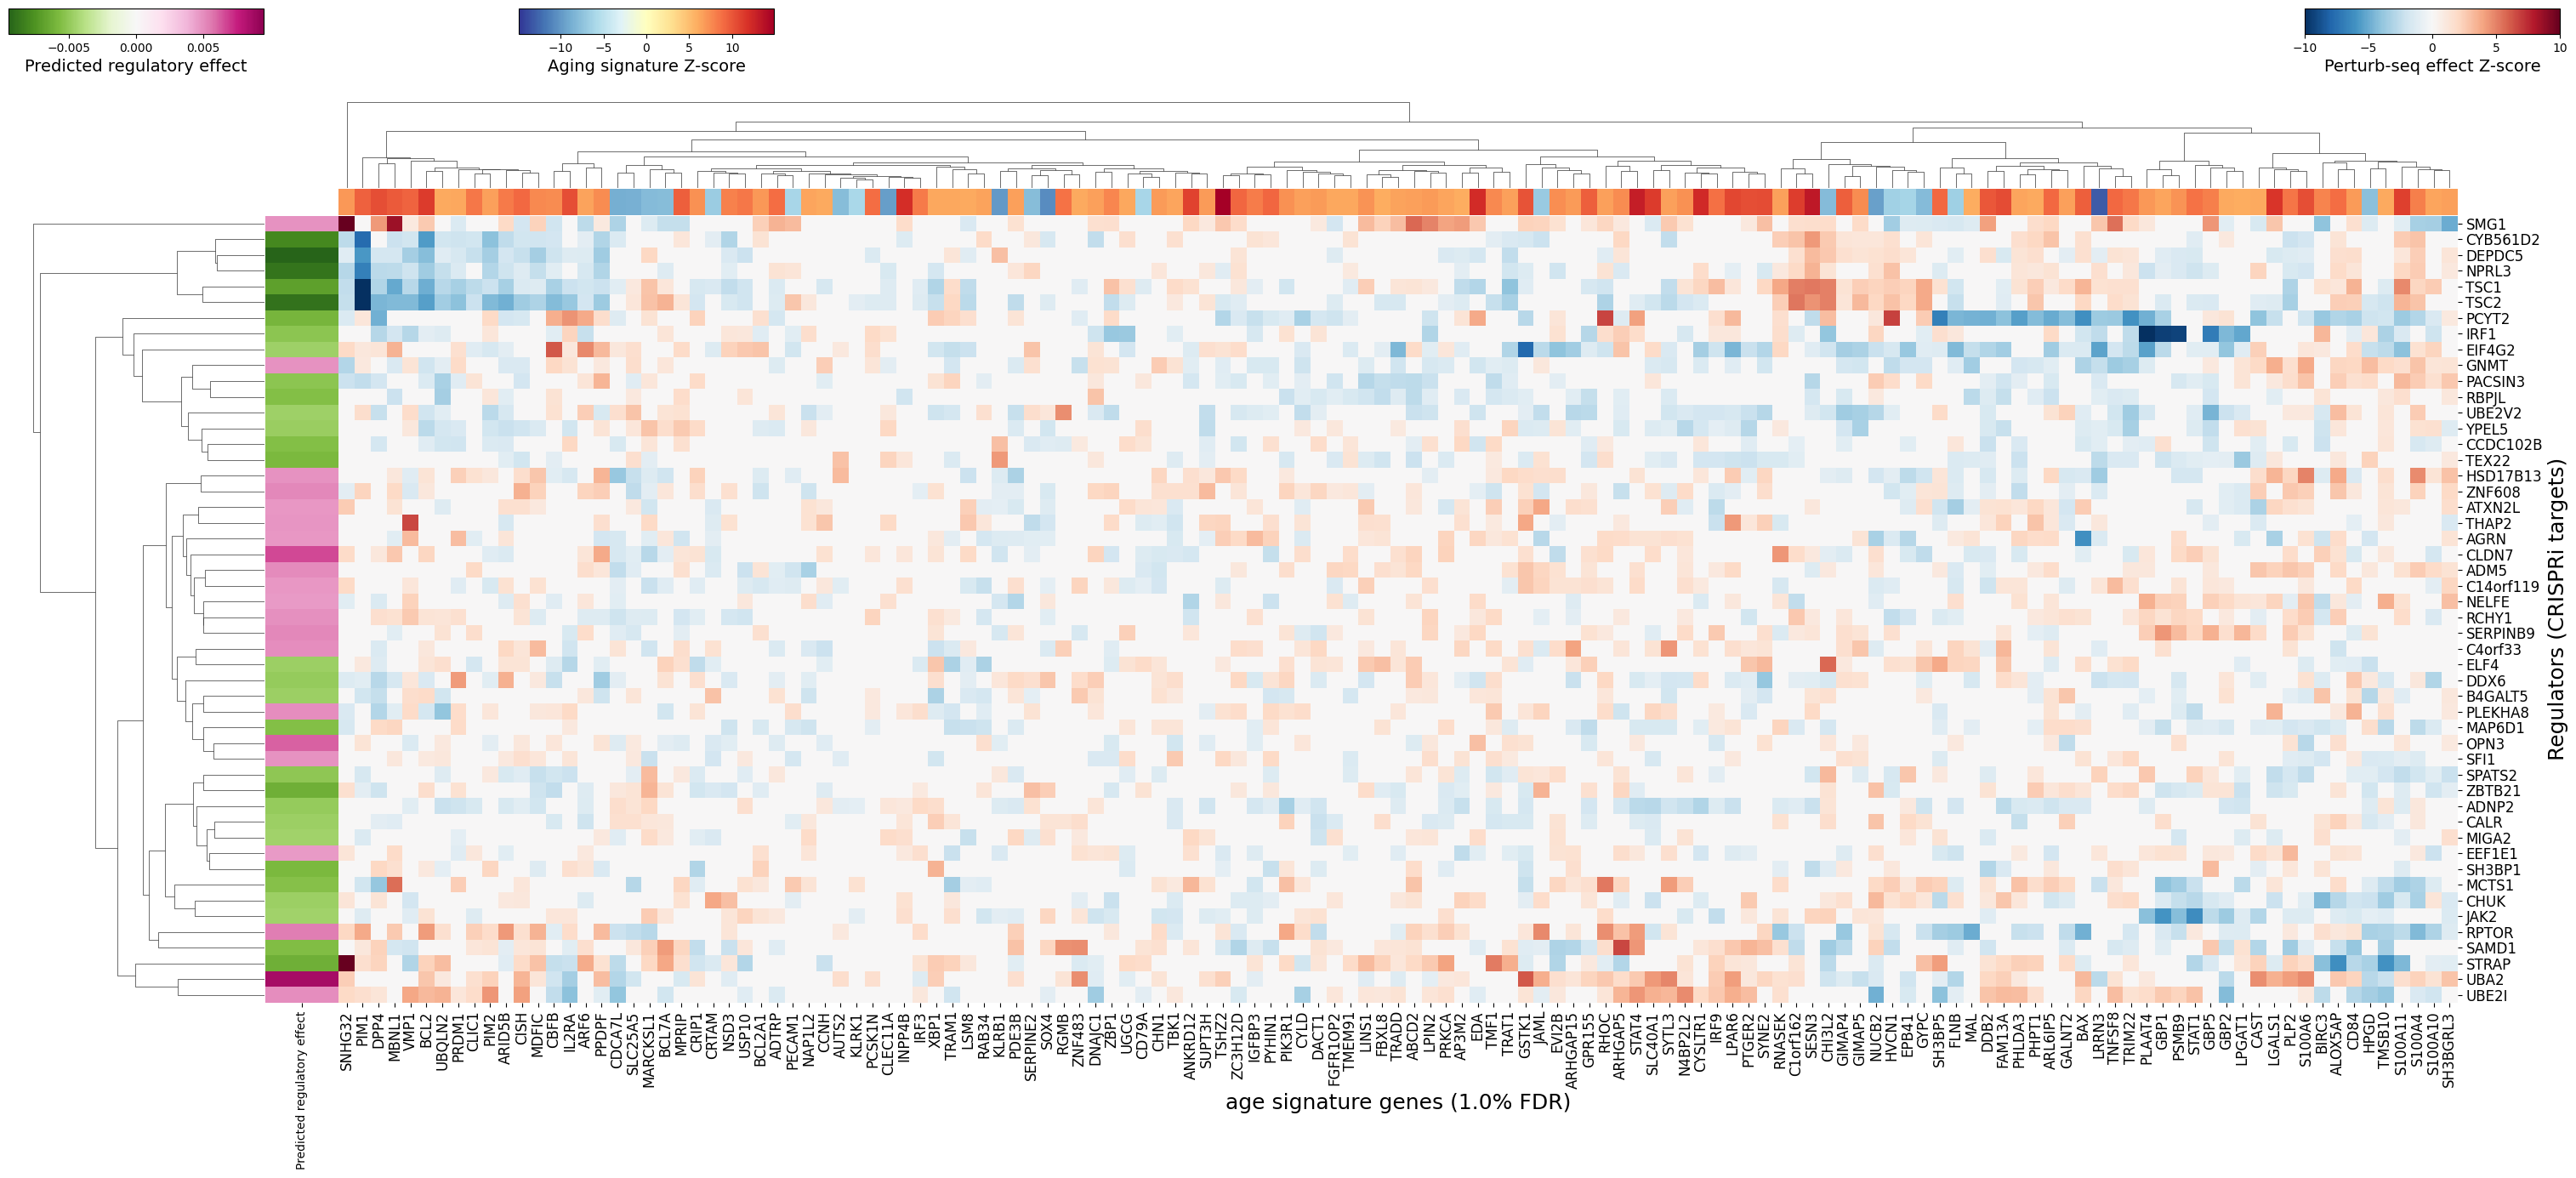

In [28]:
# Create row annotation dataframe with predicted effect sizes (now rows after transpose)
row_annot = pd.DataFrame({
    'Predicted regulatory effect': predicted_effect_size[wide_de_results.index]
})

# Create column annotation dataframe with signature zscores (now columns after transpose)
col_annot = pd.DataFrame({
    'zscore': signature_effect_size.set_index('gene_name').loc[wide_de_results.columns, 'zscore']
})

# Create different color maps for annotations
cmap_row = plt.cm.PiYG_r    # Pink-Yellow-Green for row annotation (predicted effect size)
cmap_col = plt.cm.RdYlBu_r  # Red-Yellow-Blue for column annotation (signature zscore)

# Center the colormaps at 0 by using symmetric vmin/vmax
vmax_row = max(abs(row_annot['Predicted regulatory effect'].min()), abs(row_annot['Predicted regulatory effect'].max()))
vmax_col = max(abs(col_annot['zscore'].min()), abs(col_annot['zscore'].max()))
# Create color series for annotations (seaborn expects Series, not DataFrame with RGBA)
row_colors = row_annot['Predicted regulatory effect'].apply(lambda x: cmap_row((x + vmax_row) / (2 * vmax_row)))
col_colors = col_annot['zscore'].apply(lambda x: cmap_col((x + vmax_col) / (2 * vmax_col)))

# Create the clustermap
plt.figure()
vmax = 10
g = sns.clustermap(wide_de_results,
                   cmap='RdBu_r',
                   center=0,
                   vmin=-vmax,
                   vmax=vmax,
                   row_cluster=True,
                   col_cluster=True,
                   xticklabels=True,
                   yticklabels=True,
                   method='ward',
                   figsize=(30, 15),
                   row_colors=row_colors,
                   col_colors=[col_colors],
                   cbar_pos=None,
                   dendrogram_ratio=(0.1, 0.1)) # Set row dendrogram ratio to 0 to hide it

# Adjust layout to make room for additional colorbars
plt.subplots_adjust(top=0.85)

# Add colorbars for annotations - all same width and height
colorbar_width = 0.1
colorbar_height = 0.02
colorbar_left = 0
colorbar_right = 0.9

# Main heatmap colorbar - bottom
cbar_ax_main = g.fig.add_axes([colorbar_right, 0.9, colorbar_width, colorbar_height])
vmax_main = vmax
sm_main = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-vmax_main, vmax=vmax_main))
sm_main.set_array([])
cbar_main = plt.colorbar(sm_main, cax=cbar_ax_main, orientation='horizontal')
cbar_main.set_label('Perturb-seq effect Z-score', fontsize=14)

# Row annotation colorbar (predicted effect size)
cbar_ax_row = g.fig.add_axes([colorbar_left, 0.9, colorbar_width, colorbar_height])
sm_row = plt.cm.ScalarMappable(cmap=cmap_row, norm=plt.Normalize(vmin=-vmax_row, vmax=vmax_row))
sm_row.set_array([])
cbar_row = plt.colorbar(sm_row, cax=cbar_ax_row, orientation='horizontal')
cbar_row.set_label('Predicted regulatory effect', fontsize=14)

# Column annotation colorbar (signature zscore)
cbar_ax_col = g.fig.add_axes([0.2, 0.9, colorbar_width, colorbar_height])
sm_col = plt.cm.ScalarMappable(cmap=cmap_col, norm=plt.Normalize(vmin=-vmax_col, vmax=vmax_col))
sm_col.set_array([])
cbar_col = plt.colorbar(sm_col, cax=cbar_ax_col, orientation='horizontal')
cbar_col.set_label('Aging signature Z-score', fontsize=14)

# Rotate x-axis labels
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center', fontsize=12)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=12)

g.ax_heatmap.set_xlabel(f'{st} signature genes ({alpha*100}% FDR)', fontsize=18)
g.ax_heatmap.set_ylabel('Regulators (CRISPRi targets)', fontsize=18)
# plt.savefig('figures/regulator_target_heatmap.pdf', bbox_inches='tight')
# plt.savefig('figures/regulator_target_heatmap.png', bbox_inches='tight')
# plt.close()
plt.show()

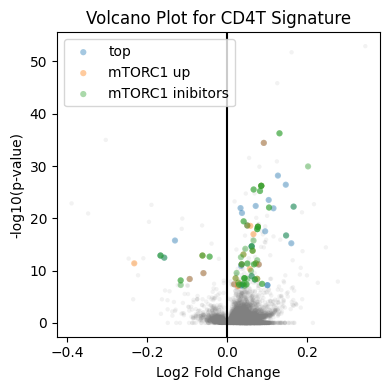

In [29]:
groups = {
    'top':['UBA2', 'SAMD1'],
    'mTORC1 up':['RPTOR'],
    'mTORC1 inibitors':['DEPDC5', 'TSC1','TSC2', 'NPRL3']}
res_df = train_signatures['CD4T'].copy()
res_df['log10_fdr'] = -np.log10(res_df['adj_p_value'])

plt.figure(figsize=(4, 4))
sns.scatterplot(data=res_df, x='log_fc', y='log10_fdr',s=10, edgecolor='none', color='grey', alpha=0.1)
for name,gr in groups.items():
    controlled_by_gr = long_de_results[(long_de_results['target_contrast_gene_name'].isin(gr)) & (long_de_results.significant)]['gene_name'].tolist()
    sns.scatterplot(data=res_df.loc[controlled_by_gr], x='log_fc', y='log10_fdr', label=name, s=20, edgecolor='none', alpha=0.4)

plt.title('Volcano Plot for CD4T Signature')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')

# Add horizontal and vertical lines for significance thresholds
# plt.axhline(y=-np.log10(0.05), color='blue', linestyle='--')
plt.axvline(x=0, color='black', linestyle='-')
# plt.title(name)
plt.tight_layout()
plt.show()

In [286]:
st = 'age'
top_quant = 0.01
n_top = 50
alpha = 0.01
c = "Rest"
ct = 'CD4T'
p2t_model = comparison_results[f"{ct}_{c}"][0]

# Get top DE genes for input signature
train_df = train_signatures[ct]
train_df['contrast'] = ct

# Get target state values
state_results_df = train_df.reset_index()
signature_effect_size = state_results_df[(state_results_df['adj_p_value'] < alpha) & 
                                       (abs(state_results_df['zscore']) > 6)].sort_values('zscore')
signature_gs = signature_effect_size.gene_name.tolist()
len(signature_gs)

# Get top x% of coefficients by absolute value
n = len(p2t_model.get_coefs()['coef_mean'])
st_coefs = p2t_model.get_coefs()
abs_coefs = st_coefs['coef_mean'].abs()
# top_abs_coefs = abs_coefs.nlargest(int(n * top_quant))
top_abs_coefs = abs_coefs.nlargest(n_top)
top_regs = st_coefs['coef_mean'][top_abs_coefs.index]
predicted_effect_size = top_regs.sort_values(ascending=False)
predicted_regulators = predicted_effect_size.index.tolist()
predicted_regulators = [x.replace(f"_{c}", '') for x in predicted_regulators]
predicted_effect_size.index = predicted_regulators

# Get DE results and pivot to wide format
long_de_results = get_DE_results_long(adata_de, targets=predicted_regulators, genes=signature_gs, gene_id_col='gene_name')
long_de_results = long_de_results[long_de_results['culture_condition'] == c].copy()
wide_de_results = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='zscore')
wide_de_results_signif = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='adj_p_value')

In [290]:
wide_de_results

target_contrast_gene_name      ADM5     ADNP2      AGRN    ATXN2L   B4GALT5  \
gene                                                                          
ABCD2                      2.036784 -0.658488 -0.332513  1.133694  1.057945   
ADTRP                     -1.147353  0.183550  0.245673  0.755865  1.546434   
ALOX5AP                    1.973868 -0.228711  1.861500  0.281018  0.023093   
ANKRD12                   -0.838835 -0.667439  0.804256 -0.370823  0.833606   
AP3M2                     -0.798503 -2.269786  0.509351  1.356012 -0.275436   
...                             ...       ...       ...       ...       ...   
VMP1                       0.327992 -1.138515  3.160887  0.133629  1.774062   
XBP1                      -0.148260  1.763415  1.099858  0.191326 -3.157524   
ZBP1                       0.940625 -0.999381 -0.063752  0.156130 -0.052551   
ZC3H12D                    1.161393  0.228814  1.984891 -0.568910  0.222177   
ZNF483                    -0.372493  0.090797  0.562779 -0.606794  2.641016   

target_contrast_gene_name        C1D   C4orf33  C14orf119  CCDC102B      CHUK  \
gene                                                                            
ABCD2                       2.341411 -0.604690   0.272688 -1.021476  1.429173   
ADTRP                       0.849149 -1.469796  -1.190785 -0.674377  0.169117   
ALOX5AP                     1.445050 -2.052682  -0.371575  0.371452 -2.858234   
ANKRD12                     2.505107  0.573711   0.205815 -0.680599 -0.145380   
AP3M2                       1.180632  2.125451   0.933340  2.039055  2.307914   
...                              ...       ...        ...       ...       ...   
VMP1                       28.518010 -0.057622   1.230736 -0.603311 -1.863747   
XBP1                       -1.050659 -2.165457  -0.351334 -0.054416 -0.022466   
ZBP1                        1.457370 -1.182553   1.151312 -0.717662 -2.247649   
ZC3H12D                    -0.340121  1.869982   0.653926 -1.945654 -1.342274   
ZNF483                     -0.115534 -0.084382   2.235377  1.003570 -1.020524   

target_contrast_gene_name  ...     THAP2    TROVE2      TSC1      TSC2  \
gene                       ...                                           
ABCD2                      ...  0.340847  0.525213  1.349244  0.700707   
ADTRP                      ... -0.144223 -0.022165 -1.439039 -1.344670   
ALOX5AP                    ... -0.882165 -1.396546  1.245537  2.491308   
ANKRD12                    ...  0.185974  0.457727  1.544639 -0.838512   
AP3M2                      ...  1.618014  2.856947 -2.575682 -1.358087   
...                        ...       ...       ...       ...       ...   
VMP1                       ...  6.698752  1.212288 -2.764641 -4.448049   
XBP1                       ...  0.143012 -1.576404 -3.045687 -2.314798   
ZBP1                       ...  1.902425 -1.593467  2.895187 -2.456391   
ZC3H12D                    ... -0.899918 -0.626592  1.100321 -1.190480   
ZNF483                     ...  0.069801 -0.603410 -1.224587 -0.830260   

target_contrast_gene_name      UBA2     UBE2I    UBE2V2     YPEL5    ZBTB21  \
gene                                                                          
ABCD2                     -0.459270  0.661841 -2.239079  0.985618 -0.928075   
ADTRP                     -0.730315 -1.475882  1.260842 -1.465868  0.542315   
ALOX5AP                    2.673411  0.055900  3.113725  1.248517  1.366510   
ANKRD12                   -0.149293  0.853343 -0.646470 -0.689800 -0.273982   
AP3M2                      1.249309 -0.261267  0.146549  1.713591 -1.116188   
...                             ...       ...       ...       ...       ...   
VMP1                      -0.020321  3.885619  1.840261  1.107252  0.299761   
XBP1                       2.493052  0.406374 -2.088364  0.096062  0.655992   
ZBP1                      -0.081073  0.738258 -2.557567 -0.968770 -1.704156   
ZC3H12D                   -0.232146 -1.568808 -1.673096  0.916784  1.105966   
ZNF483 

In [ ]:


res_df = train_signatures['CD4T'].copy()

def plot_regulator_effects_volcano(res_df, wide_de_results, wide_de_results_signif, regulators, regulator_list_name, regulator_sign=1, ax=None):
    """
    Create a scatter plot showing the effects of specific regulators on gene expression.
    
    Parameters:
    -----------
    res_df : pd.DataFrame
        DataFrame with baseline gene expression results
    wide_de_results : pd.DataFrame
        Wide-format DataFrame of differential expression results 
    wide_de_results_signif : pd.DataFrame
        Wide-format DataFrame of significance values
    regulators : list
        List of regulators to analyze
    regulator_list_name : str
        Name of the regulator list for plot title
    regulator_sign: int
        Sign of regulation
    
    Returns:
    --------
    matplotlib.figure.Figure
        The generated scatter plot
    """
    res_df['log10_fdr'] = -np.log10(res_df['adj_p_value'])
    
    # Get perturbation effects for specified regulators
    perturb_effects = wide_de_results[regulators].copy()
    perturb_effects[wide_de_results_signif[regulators] >= 0.1] = np.nan
    perturb_effects = perturb_effects.mean(1).reset_index()
    perturb_effects.columns = ['gene', 'zscore']
    
    # Merge perturbation effects with baseline results
    pl_res_df = pd.merge(   
        res_df.reset_index().rename(columns={'gene_name':'gene'}),
        perturb_effects,
        on='gene', how='left'
    )
    
    # Take sign of zscore
    pl_res_df['zscore_y'] = np.where(np.sign(pl_res_df['zscore_y']) != (np.sign(pl_res_df['zscore_x']) * regulator_sign), np.nan, pl_res_df['zscore_y'])
    pl_res_df['zscore_y'] = np.sign(pl_res_df['zscore_y'])
    
    # Create plot
    if ax is None:
        plt.figure(figsize=(5, 4))  # Slightly wider to accommodate legend
        ax = plt.gca()
    
    pl_res_df_sorted = pl_res_df.reindex(pl_res_df['zscore_y'].abs().sort_values(ascending=True).index)
    
    # Background scatter
    ax.scatter(pl_res_df_sorted['log_fc'], pl_res_df_sorted['log10_fdr'], s=10, color='lightgrey', edgecolor='none')
    
    # Colored scatter based on regulator effect
    sns.scatterplot(x=pl_res_df_sorted['log_fc'], y=pl_res_df_sorted['log10_fdr'], 
                         s=20, hue=pl_res_df_sorted['zscore_y'], palette={-1:'blue', 1:'red'}, edgecolor='none', ax=ax, legend=False)
    
    # Add text labels
    from adjustText import adjust_text
    texts = []
    for row in pl_res_df_sorted[(~pl_res_df_sorted['zscore_y'].isna()) & (~pl_res_df_sorted['zscore_x'].isna())].iterrows():
        texts.append(ax.text(row[1]['log_fc'], row[1]['log10_fdr'], row[1]['gene'], 
                               fontsize=8, 
                               alpha=0.7,
                               color='blue' if row[1]['zscore_y'] < 0 else 'red'))
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey'))
    
    ax.axvline(0, linestyle=":", alpha=0.5, color='black')
    # Add legend for regulator effect
    ax.scatter([], [], c='red', label='Negative Effect', alpha=0.7)
    ax.scatter([], [], c='blue', label='Positive Effect', alpha=0.7)
    ax.legend(title='Regulator Effect', frameon=False)
    
    ax.set_title(regulator_list_name)
    sns.despine(ax=ax)
    plt.tight_layout()
    
    return plt.gcf()


groups = (
    ('mTORC1 inibitors',['TSC1'], -1),
    ('IRF1',['IRF1'], -1),
    ('mTORC1 up',['RPTOR'], 1),
    ('UBA2', ["UBA2"], 1),
)

condition='Rest'
long_de_results = get_DE_results_long(adata_de, targets=sum([x[1] for x in groups], []), gene_id_col='gene_name')
long_de_results = long_de_results[long_de_results['culture_condition'] == condition].copy()
wide_de_results = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='zscore')
wide_de_results_signif = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='adj_p_value')

for name, gr, sign in groups:
    plot_regulator_effects_volcano(res_df, wide_de_results, wide_de_results_signif, gr, name, sign)
# plot_regulator_effects_scatter(res_df, wide_de_results, wide_de_results_signif, ['TSC2'], 'TSC2')

plt.tight_layout()
plt.show()

In [368]:
regulators = ['TSC2']
genes = ['KLF3']
condition='Rest'
long_de_results = get_DE_results_long(adata_de, targets=regulators, genes=genes, gene_id_col='gene_name')
long_de_results = long_de_results[long_de_results['culture_condition'] == condition].copy()
wide_de_results = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='zscore').T
wide_de_results_signif = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='adj_p_value').T
wide_de_results_signif

gene                           KLF3
target_contrast_gene_name          
TSC2                       0.004597

In [181]:
dataset_key = 'CD4T_Rest'
model, X, y_train = comparison_results[dataset_key]

In [185]:
X

IKBKB_Rest  COQ10B_Rest  DPF2_Rest  CEP350_Rest  PELI2_Rest  \
AACS     -0.230795     0.984902   0.125060     0.928792    0.729960   
AAGAB     0.271081    -0.863843   0.839048    -0.232392    1.632658   
AAK1      0.898369     0.955437  -0.587374    -0.930197    0.311339   
AAMDC    -0.559368    -0.452131   0.499835     0.536451   -0.463970   
AASDH    -1.392192    -1.526147   0.953395    -0.160288    0.991176   
...            ...          ...        ...          ...         ...   
ZXDB      0.331860     1.160078   0.772805    -0.626602   -0.117012   
ZXDC     -0.105469     0.156789   1.096840     2.196639    0.323288   
ZYG11B   -0.202434     1.313665  -0.446416    -0.052614   -1.510879   
ZZEF1     1.054326     0.091345  -0.349597    -0.375472   -0.966815   
ZZZ3      2.565600     2.665608  -0.465247     0.452510   -0.409025   

        WTAP_Rest  NUBPL_Rest  SLC35E2B_Rest  TSEN15_Rest  ACAD11_Rest  ...  \
AACS    -0.715985    1.847855       1.804297     0.236914    -0.159941  ...   
AAGAB    0.915838   -0.682486      -0.786672     0.618353    -0.350548  ...   
AAK1    -0.017977    1.330158       0.682196    -1.671902     0.222283  ...   
AAMDC   -0.628511    0.692782       1.128544     1.379387     0.617213  ...   
AASDH    2.223287   -0.529822      -0.360318     0.590268    -0.906196  ...   
...           ...         ...            ...          ...          ...  ...   
ZXDB    -1.752610   -0.947014       0.247941    -0.615785     0.377383  ...   
ZXDC     3.050384    0.134290       1.503630    -0.343299     1.592505  ...   
ZYG11B  -0.329789    0.922401      -0.404843     0.959839    -2.547756  ...   
ZZEF1    0.249643    1.832304       0.463007     1.064901    -1.272421  ...   
ZZZ3     1.986080    1.349410      -2.670728     0.644428     1.412669  ...   

        PRCC_Rest  CNOT9_Rest  AASDH_Rest  CCDC28B_Rest  COA7_Rest  \
AACS    -1.082988   -2.323203   -0.400577     -0.553722   0.754287   
AAGAB    0.157943    0.104505   -1.891497      0.772570  -0.841141   
AAK1    -0.313854   -1.288089    1.019680      0.116507   0.080716   
AAMDC   -0.081831   -0.272332    1.913799      3.271192  -1.510191   
AASDH    1.300046   -0.960842   -7.308273      0.152308   0.195580   
...           ...         ...         ...           ...        ...   
ZXDB     2.376200    0.355826   -0.555283     -0.672007  -0.499989   
ZXDC     0.537243    0.235216    1.105974      1.045355   1.981153   
ZYG11B   0.872417   -0.585985    2.017462     -0.173516  -1.066579   
ZZEF1    1.893777   -0.098954   -1.073241     -1.398162   1.996576   
ZZZ3    -0.048726   -0.891693   -0.531378     -2.120175  -0.007334   

        TM2D1_Rest  TMEM41B_Rest  HSP90B1_Rest  SERF1B_Rest  H2AFJ_Rest  
AACS     -1.781856      0.379789      0.519081     0.233791   -0.627333  
AAGAB     0.798201      0.423757      0.169140     0.325915    0.875155  
AAK1     -0.211716     -1.158703      0.832315    -1.713167   -0.584297  
AAMDC    -1.595850      0.633187      1.383627    -0.307587   -0.813440  
AASDH    -0.298313     -0.710898     -0.257315     0.507581    0.207984  
...            ...           ...           ...          ...         ...  
ZXDB     -0.647330      0.880385      1.313281     1.834980   -0.500414  
ZXDC     -0.979156     -1.431839     -1.676634     1.318885   -0.128775  
ZYG11B    1.368737      0.680348      0.065758    -1.344457   -0.915587  
ZZEF1     0.516598      0.614584     -0.590831     1.335765   -0.283568  
ZZZ3     -1.645432     -0.186601      1.726274     2.273658   -1.287553  

[6014 rows x 3838 columns]

In [189]:
res_df.loc['PIM2']

baseMean                 28.311287
log_fc                    0.043913
lfcSE                     0.006649
stat                      6.604368
pvalue                         0.0
adj_p_value                    0.0
variable           ENSG00000102096
perturbseq_gene              False
zscore                    6.604368
contrast                      CD4T
log10_fdr                 8.543868
Name: PIM2, dtype: object

In [190]:
model.get_effect_per_gene(X, gene='PIM2', subset_regulators=[x +'_Rest' for x in groups['mTORC1 inibitors']])

pred_mean  pred_sem
TSC2_Rest     0.021122  0.000768
TSC1_Rest     0.006865  0.000402
DEPDC5_Rest   0.023718  0.000673
NPRL3_Rest    0.019559  0.000933

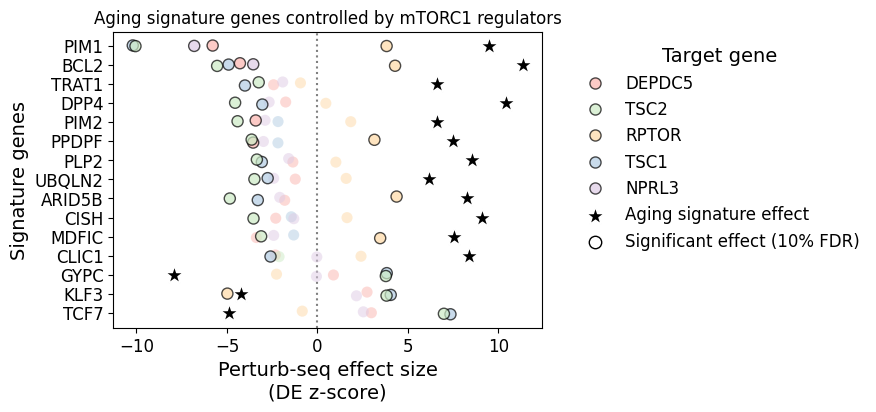

In [359]:
pl_genes = [
    'PPDPF',  'CISH', 'MDFIC', 'PIM1', 'DPP4', 'TRAT1', 'UBQLN2', 'ARID5B', 'CLIC1', 'PLP2', 'BCL2', 'PIM2', # down
    'TCF7','KLF3', 'GYPC', # up
    ]
gr = ['DEPDC5', 'TSC1','TSC2', 'NPRL3', 'RPTOR']

plot_regulator_effects(adata_de, pl_genes, gr, train_signatures['CD4T']['zscore'], figsize=(9,4), condition='Rest')
plt.title('Aging signature genes controlled by mTORC1 regulators')
plt.savefig('./results/aging_regulators_effect_on_signature.pdf')
plt.savefig('./results/aging_regulators_effect_on_signature.png')

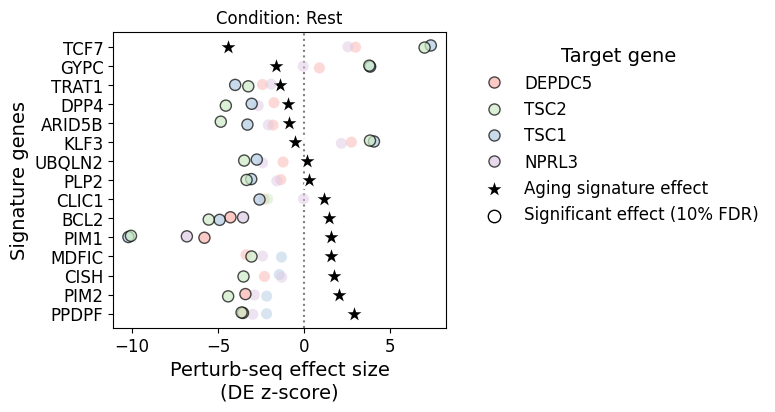

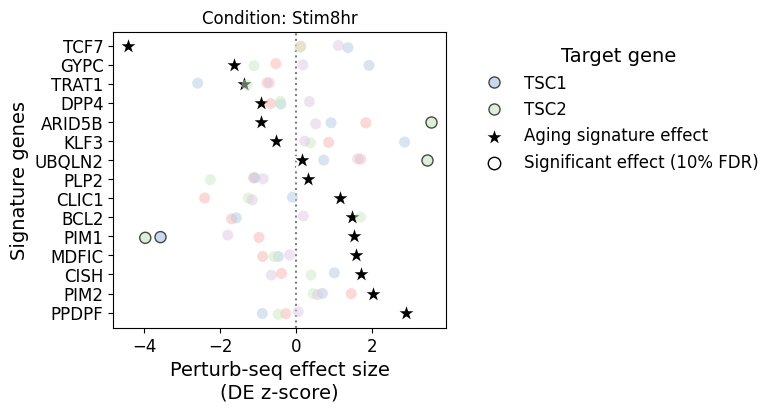

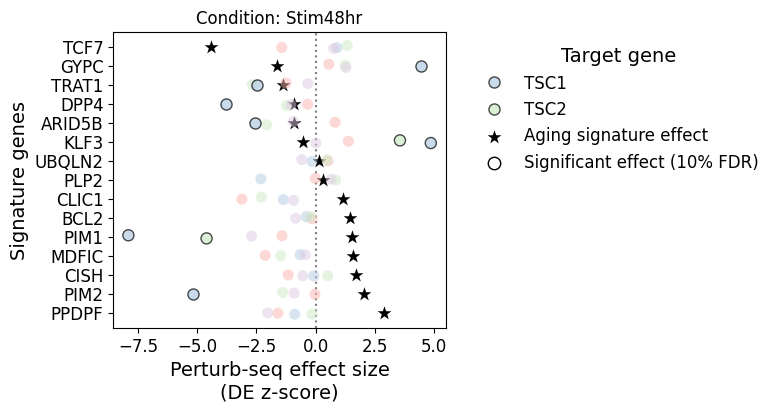

In [216]:
plot_regulator_effects(adata_de, pl_genes, gr, y_target, figsize=(8,4), condition='Rest', sort_by='aging')
plt.title('Condition: Rest')
plt.savefig('./results/aging_regulators_effect_on_signature.Rest.pdf')
plt.savefig('./results/aging_regulators_effect_on_signature.Rest.png')
plot_regulator_effects(adata_de, pl_genes, gr, y_target, figsize=(8,4), condition='Stim8hr', sort_by='aging')
plt.title('Condition: Stim8hr')
plt.savefig('./results/aging_regulators_effect_on_signature.Stim8hr.pdf')
plt.savefig('./results/aging_regulators_effect_on_signature.Stim8hr.png')
plot_regulator_effects(adata_de, pl_genes, gr, y_target, figsize=(8,4), condition='Stim48hr', sort_by='aging')
plt.title('Condition: Stim48hr')
plt.savefig('./results/aging_regulators_effect_on_signature.Stim48hr.pdf')
plt.savefig('./results/aging_regulators_effect_on_signature.Stim48hr.png')


### Regulators of the most DE genes

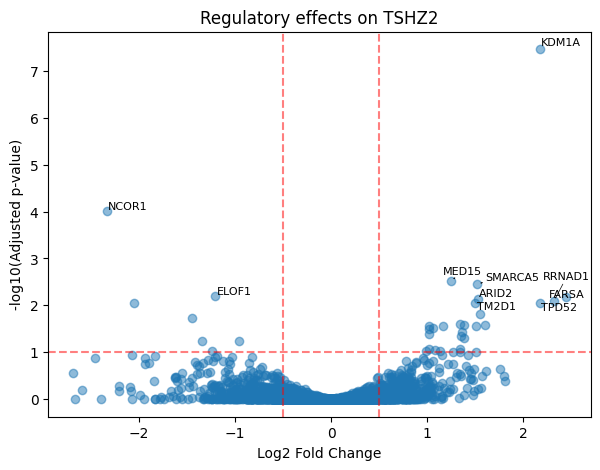

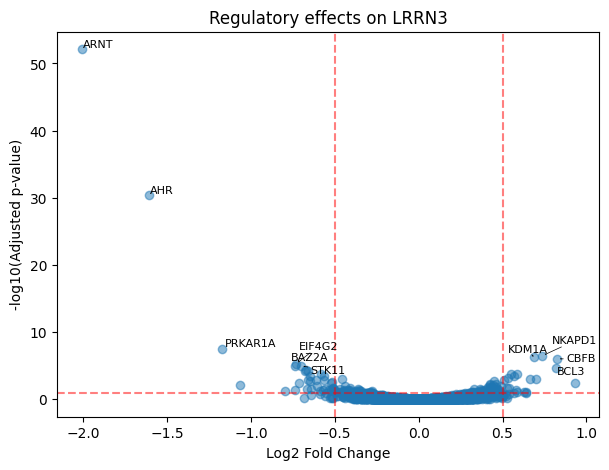

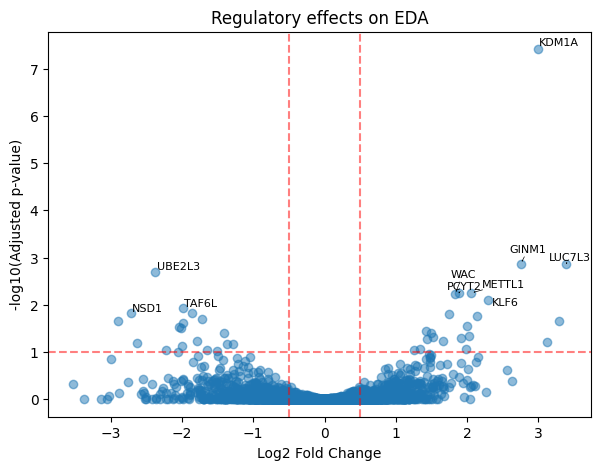

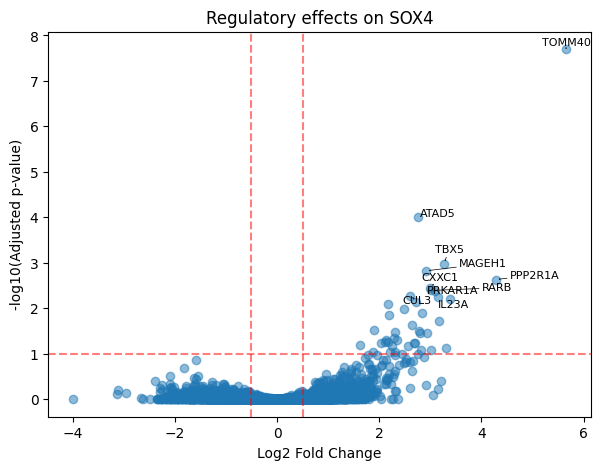

In [180]:
for g in ['TSHZ2', 'LRRN3', 'EDA', 'SOX4']:
    marker_effects = get_DE_results_long(adata_de, genes=[g])
    marker_effects = marker_effects[marker_effects['culture_condition'] == 'Rest']
    # coefs = p2t_model.get_coefs().loc[marker_effects['target_contrast_gene_name']]
    # # Calculate correlation coefficient
    # corr = np.corrcoef(marker_effects['zscore'], coefs['coef_mean'])[0,1]

    # plt.figure(figsize=(8,6))
    # plt.scatter(marker_effects['zscore'], coefs['coef_mean'])
    # plt.xlabel('zscore')
    # plt.ylabel('coef_mean') 
    # plt.title(f'Coefficient vs Z-score (r = {corr:.2f})')
    # plt.show()

    plt.figure(figsize=(7,5))
    plt.scatter(marker_effects['log_fc'], -np.log10(marker_effects['adj_p_value']), alpha=0.5)
    plt.axhline(-np.log10(0.1), color='red', linestyle='--', alpha=0.5)
    plt.axvline(-0.5, color='red', linestyle='--', alpha=0.5)
    plt.axvline(0.5, color='red', linestyle='--', alpha=0.5)

    # Add labels for top 10 most significant points using adjustText
    from adjustText import adjust_text

    sig_points = marker_effects.nsmallest(10, 'adj_p_value')
    texts = []
    for _, row in sig_points.iterrows():
        texts.append(plt.text(row['log_fc'], -np.log10(row['adj_p_value']), 
                            row['target_contrast_gene_name'], fontsize=8))
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(Adjusted p-value)')
    plt.title(f'Regulatory effects on {g}')
    plt.show()

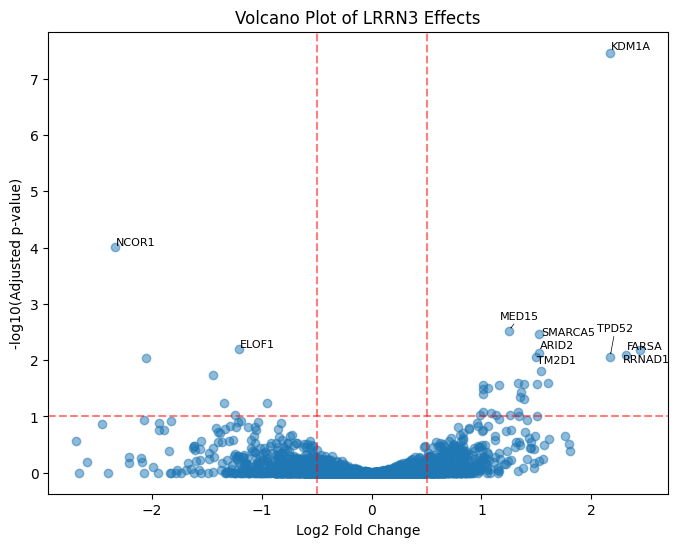